# ADR Study for PubMed Vioxx Dataset
* We start off by a detailed look into the word2vec algorithm and examine a python implementation of the skip-gram model with negative sampling

* We will use the Gensim package to speed up training time and investigate the translational properties of word embeddings. 

* We will examine GloVe embeddings as an alternative to word2vec. Both methods, however, are unable to handle antonymy, polysemy, and word-sense disambiguation. We consider document clustering by using an embeddings approach. 
* We study how an embedding method like sense2vec can better handle word sense disambiguation.
* Lastly, we try to give an intuition about Named Entity Recognition (NER) about the article dataset.

# 1. Exploratory Data Analysis

## Get Data

We load the abstracts of articles into a pandas dataframe. along with PMID, Title, and Publication Date.

In [180]:
import pandas as pd
from pymed import PubMed
pubmed = PubMed(tool="PubMedSearcher", email="example@gmail.com")

## PUT YOUR SEARCH TERM HERE ##
search_term = "vioxx"
results = pubmed.query(search_term, max_results=500)
articleList = []
articleInfo = []

for article in results:
# Print the type of object we've found (can be either PubMedBookArticle or PubMedArticle).
# We need to convert it to dictionary with available function
    articleDict = article.toDict()
    articleList.append(articleDict)

# Generate list of dict records which will hold all article details that could be fetch from PUBMED API
for article in articleList:
#Sometimes article['pubmed_id'] contains list separated with comma - take first pubmedId in that list - thats article pubmedId
    pubmedId = article['pubmed_id'].partition('\n')[0]
    # Append article info to dictionary 
    articleInfo.append({u'pubmed_id':pubmedId,
                        u'title':article['title'],
                        u'abstract':article['abstract'],
                        u'publication_date':article['publication_date']}) 
                        #u'authors':article['authors']})

# Generate Pandas DataFrame from list of dictionaries
articlesPD = pd.DataFrame.from_dict(articleInfo)
#Print first 10 rows of dataframe
articlesPD.head(10)

pubmed_id                                              title  \
0  32540483  Chronic treatment with rofecoxib but not ische...   
1  32508354  Role of Anti-inflammatory Drugs in the Colorec...   
2  32434933  An instrument for assessing the quality of inf...   
3  32352165  Aspirin and other non-steroidal anti-inflammat...   
4  32251635  Structural investigation on the selective COX-...   
5  32179835  Carboranyl Derivatives of Rofecoxib with Cytos...   
6  32111102  Hidden Cardiotoxicity of Rofecoxib Can be Reve...   
7  32025574  The National Institutes of Health funding for ...   
8  31999978  Inhibition of 20-hydroxyeicosatetraenoic acid ...   
9  31916080  Coronary Risks Associated with Diclofenac and ...   

                                            abstract publication_date  
0  There is some recent evidence that cardiac isc...       2020-06-17  
1                                                          2020-06-09  
2  To develop a nationally applicable tool for as...       2020-05-22  
3  Dementia is a worldwide concern. Its global pr...       2020-05-01  
4  Initially, the selective COX-2 inhibitors were...       2020-04-07  
5  Owing to the involvement of cyclooxygenase-2 (...       2020-03-18  
6  Cardiac adverse effects are among the leading ...       2020-03-01  
7  Machine learning (ML) techniques have become u...       2020-02-07  
8  20-hydroxyeicosatetraenoic acid (20-HETE) is a...       2020-01-31  
9  The risk of coronary events with non-steroidal...       2020-01-10

In [181]:
# Combine the 'title' and the 'abstract' column as 'body_text'.
articlesPD['body_text'] = articlesPD['title']+'. '+articlesPD['abstract']
articlesPD.head()

pubmed_id                                              title  \
0  32540483  Chronic treatment with rofecoxib but not ische...   
1  32508354  Role of Anti-inflammatory Drugs in the Colorec...   
2  32434933  An instrument for assessing the quality of inf...   
3  32352165  Aspirin and other non-steroidal anti-inflammat...   
4  32251635  Structural investigation on the selective COX-...   

                                            abstract publication_date  \
0  There is some recent evidence that cardiac isc...       2020-06-17   
1                                                          2020-06-09   
2  To develop a nationally applicable tool for as...       2020-05-22   
3  Dementia is a worldwide concern. Its global pr...       2020-05-01   
4  Initially, the selective COX-2 inhibitors were...       2020-04-07   

                                           body_text  
0  Chronic treatment with rofecoxib but not ische...  
1  Role of Anti-inflammatory Drugs in the Colorec...  
2  An instrument for assessing the quality of inf...  
3  Aspirin and other non-steroidal anti-inflammat...  
4  Structural investigation on the selective COX-...

##  Preprocessing

Word2vec needs clean word tokens for **training**, so lets clean up the sentences by preprocessing to remove punctuation, hidden characters, and uppercase characters.

In [182]:
# Take the subset of the data that includes the corpus to preprocess. 
ndf = articlesPD[['pubmed_id','body_text','publication_date']]
ndf.head()

pubmed_id                                          body_text  \
0  32540483  Chronic treatment with rofecoxib but not ische...   
1  32508354  Role of Anti-inflammatory Drugs in the Colorec...   
2  32434933  An instrument for assessing the quality of inf...   
3  32352165  Aspirin and other non-steroidal anti-inflammat...   
4  32251635  Structural investigation on the selective COX-...   

  publication_date  
0       2020-06-17  
1       2020-06-09  
2       2020-05-22  
3       2020-05-01  
4       2020-04-07

In [183]:
# Convert the type of the 'body_text' column to string
ndf['body_text'] = ndf['body_text'].astype(str) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [184]:
import datetime 
ndf['publication_date'] =  pd.to_datetime(ndf['publication_date'], format='%Y/%m/%d')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [185]:

ndf["publication_year"] = ndf["publication_date"].apply (lambda x : x.year if x.month < 9 else x.year + 1)
ndf.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


pubmed_id                                          body_text  \
0  32540483  Chronic treatment with rofecoxib but not ische...   
1  32508354  Role of Anti-inflammatory Drugs in the Colorec...   
2  32434933  An instrument for assessing the quality of inf...   
3  32352165  Aspirin and other non-steroidal anti-inflammat...   
4  32251635  Structural investigation on the selective COX-...   

  publication_date  publication_year  
0       2020-06-17              2020  
1       2020-06-09              2020  
2       2020-05-22              2020  
3       2020-05-01              2020  
4       2020-04-07              2020

In [186]:
# Convert into dataframe of sentences

nltk.download('punkt')

df = pd.DataFrame()
for f in ndf['body_text']:
    sentence = sent_tokenize(f)
    df = df.append(sentence)
df.columns = ['body_text']
df.count()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ahmetcakmak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


body_text    5246
dtype: int64

In [188]:
# Prepping our environment
# Basics
import glob
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.feature_extraction import stop_words
import math
import re
import string

# NLTK
import nltk
from nltk import tokenize, sent_tokenize

print("Packages imported")

Packages imported


In [189]:
import re
import string
def process_text(text):
    
    text = re.sub(r"\\n", " ", text)
    text = re.sub(r"\n", " ", text)

    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
#    stops = stop_words.ENGLISH_STOP_WORDS
#    body_text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
 
    return text

# apply the above function to df['body_text']
df['body_text'] = df['body_text'].map(lambda x: process_text(x))

corpus = df['body_text'].tolist()
df.head()

body_text
0  chronic treatment with rofecoxib but not ische...
1  there is some recent evidence that cardiac isc...
2  however it is not clear whether remote gut inj...
3  previously we found that chronic treatment wit...
4  in the present study we aimed to analyse the e...

In [190]:
df.body_text[0:10]

0    chronic treatment with rofecoxib but not ische...
1    there is some recent evidence that cardiac isc...
2    however it is not clear whether remote gut inj...
3    previously we found that chronic treatment wit...
4    in the present study we aimed to analyse the e...
5    we found that cardiac i r injury induced histo...
6    all these changes were prevented by rofecoxib ...
7    by contrast cardiac ipc failed to reduce intes...
8    our results demonstrate for the first time tha...
9    furthermore intestinal damage correlates with ...
Name: body_text, dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9df188c890>]],
      dtype=object)

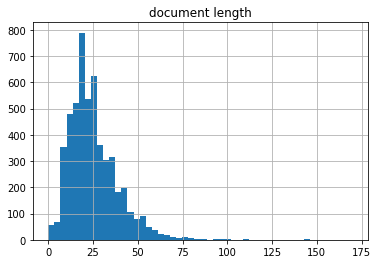

In [191]:
# calculate some basic statistics on this dataset, 
# starting with document length and sentence length.
# document length histogram:

pd.DataFrame([len(x.split()) for x in df['body_text']],columns= ['document length']).hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e90263fd0>]],
      dtype=object)

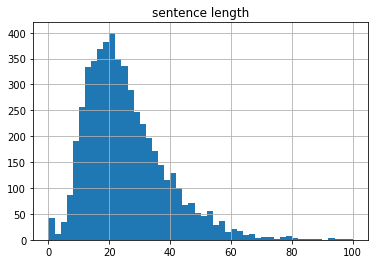

In [192]:

pd.DataFrame([len(x.split()) for x in df['body_text']],columns= ['sentence length']).hist(bins=50,range=(0,100))

Checking word-frequency by looking at the top 1000 terms in this corpus: The top 100 terms are what we typically consider stop-words, since they are common across most sentences and do not capture much, if any, semantic meaning. As we move further down, we start to see words that play a more important role in conveying the meaning within a sentence or document.

In [193]:

words = [tokenize.word_tokenize(x) for x in corpus]
words = [y for x in words for y in x]
word_freq = pd.DataFrame(nltk.FreqDist(words).most_common(1000), columns=['word','frequency'])
print(word_freq)

          word  frequency
0            -       5811
1           of       5234
2          the       5093
3          and       4238
4           in       3002
..         ...        ...
995     update         17
996     smooth         17
997  responses         17
998   blockade         17
999     linked         17

[1000 rows x 2 columns]


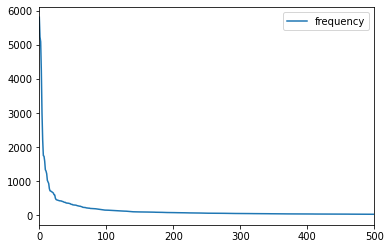

In [207]:
word_freq.plot(xlim=(0,500))

# 2. Word Embeddings

Our goal is to train a set of word embeddings for the corpus above. Let's build a skip-gram model with negative sampling. Before we train either model, let's see how many unique words exist.

## Create Dictionary of Vocabulary

In [194]:
# Tokenize and create dictionary

class VocabWord:
    def __init__(self, word):
        self.word = word
        self.count = 0


vocab_items = []
vocab_hash = {}
word_count = 0
        
for token in ['<bol>', '<eol>']:
        vocab_hash[token] = len(vocab_items)
        vocab_items.append(VocabWord(token))

for line in df['body_text']:
    tokens = line.split()
    for token in tokens:
        if token not in vocab_hash:
            vocab_hash[token] = len(vocab_items)
            vocab_items.append(VocabWord(token))

        #assert vocab_items[vocab_hash[token]].word == token, 'Wrong vocab_hash index'
        vocab_items[vocab_hash[token]].count += 1
        word_count += 1

        if word_count % 1000000 == 0:
            print("\rReading word %d" % word_count)

    # Add special tokens <bol> (beginning of line) and <eol> (end of line)
    vocab_items[vocab_hash['<bol>']].count += 1
    vocab_items[vocab_hash['<eol>']].count += 1
    word_count += 2

print('Total words in training file: %d' % word_count)
print('Vocab size: %d' % len(vocab_items))

Total words in training file: 142667
Vocab size: 9703


##  Word2Vec

We are now ready to train the neural network of the word2vec model. Let's define our model parameters:

*  **di** = dimension of the word vectors
*  **win** = context window size (number of tokens)
*  **start_alpha** = starting learning rate
*  **neg** = number of samples for negative sampling
*  **min_count** = minimum number of mentions for a word to be included in vocabulary





In [195]:
# Initialize parameters of neural network

dim = 100
win = 10
start_alpha = 0.05
neg = 10
min_count = 5

##  Handling Rare Words

We want to filter out rare words that have few mentions than our min_count threshold. We will be mapping all of these words to a special out-of-vocabulary token.

In [196]:
# truncate dictionary and map rare words to <unk> token
truncated = []
truncated.append(VocabWord('<unk>'))
unk_hash = 0

count_unk = 0
for token in vocab_items:
    if token.count < min_count:
        count_unk += 1
        truncated[unk_hash].count += token.count
    else:
        truncated.append(token)

truncated.sort(key=lambda token : token.count, reverse=True)

vocab_hash = {}
for i, token in enumerate(truncated):
    vocab_hash[token.word] = i

vocab_items = truncated
vocab_hash = vocab_hash
vocab_size = len(vocab_items)
print('Unknown vocab size:', count_unk)
print('Truncated vocab size: %d' % vocab_size)

Unknown vocab size: 6778
Truncated vocab size: 2926


## Negative Sampling

To speed up training, let's create a negative sampling lookup table that we will use during training.

In [197]:
# Create table of probabilities for negative sampling

power = 0.75
norm = sum([math.pow(t.count, power) for t in vocab_items]) # Normalizing constant

table_size = int(1e8) # Length of the unigram table
table = np.zeros(table_size, dtype=np.int)

p = 0 # Cumulative probability
i = 0
for j, unigram in enumerate(vocab_items):
    p += float(math.pow(unigram.count, power))/norm
    while i < table_size and float(i) / table_size < p:
        table[i] = j
        i += 1
        
def sample(table,count):
    indices = np.random.randint(low=0, high=len(table), size=count)
    return [table[i] for i in indices]

## Training the Model

We are now ready to train the word2vec model. The approach is to train a two-layer (syn0, syn1) neural network by iterating over the sentences in the corpus and adjusting lawyer weights to maximize the probabilities of context words given a target word (skip-gram) with negative sampling. After completion, the weights of the hidden layer syn0 are the word embeddings that we seek.

In [198]:
# Train skip-gram with negative sampling
import struct

# Sigmoid Function
def sigmoid(z):
    if z > 6:
        return 1.0
    elif z < -6:
        return 0.0
    else:
        return 1 / (1 + math.exp(-z))
    
# Init syn0 with uniform distribution on the interval [-0.5, 0.5]/dim
tmp = np.random.uniform(low=-0.5/dim, high=0.5/dim, size=(vocab_size, dim))
syn0 = np.ctypeslib.as_ctypes(tmp)
syn0 = np.array(syn0)


tmp = np.zeros(shape=(vocab_size, dim))
syn1 = np.ctypeslib.as_ctypes(tmp)
syn1 = np.array(syn1)
    
current_sent = 0
truncated_vocabulary = [x.word for x in vocab_items]
corpus = df['body_text'].tolist()

while current_sent < df.count()[0]:
    line = corpus[current_sent]
    sent = [vocab_hash[token] if token in truncated_vocabulary else vocab_hash['<unk>'] 
            for token in [['<bol>'] + line.split() + ['<eol>']]]
    for sent_pos, token in enumerate(sent):
        
        current_win = np.random.randint(low=1, high=win+1)
        context_start = max(sent_pos - current_win, 0)
        context_end = min(sent_pos + current_win + 1, len(sent))
        context = sent[context_start:sent_pos] + sent[sent_pos+1:context_end]

        for context_word in context:
            embed = np.zeros(DIM)
            classifiers = [(token, 1)] + [(target, 0) for target in table.sample(neg)]
            for target, label in classifiers:
                z = np.dot(syn0[context_word], syn1[target])
                p = sigmoid(z)
                g = alpha * (label - p)
                embed += g * syn1[target] 
                syn1[target] += g * syn0[context_word] 
            syn0[context_word] += embed

        word_count += 1
    current_sent += 1
    if current_sent % 2000 == 0:
        print("\rReading sentence %d" % current_sent)


embedding = dict(zip(truncated_vocabulary,syn0))
print("Trained embeddings")

# Save embedding

fo = open("word2vec", 'w+')
for token, vector in zip(truncated_vocabulary, syn0):
    fo.write('%s ' % token)
    for s in vector:
        fo.write(('%f '% s))
    fo.write('\n')
fo.close()

print(syn0.shape)
    

Reading sentence 2000
Reading sentence 4000
Trained embeddings
(2926, 100)


The semantic translation properties of these embeddings are noteworthy. Let's examine the cosine similarity between two similar words (heart, myocardial) and two dissimilar words (adverse, inhibitor). We would expect the similar words to exhibit higher similarity.

In [225]:
from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity([embedding['heart']],[embedding['myocardial']]))
print(cosine_similarity([embedding['adverse']],[embedding['inhibitor']]))

[[-0.13509716]]
[[0.00568114]]


## Visualize Embedding space

We can visualize the word embeddings using the T-SNE algorithm to map the embeddings to 2D space. Note that T-SNE is a dimensionality reduction technique that preserves notions of proximity within a vector space (points close together in 2D are close in proximity in higher dimensions). The figure below shows the relationships of a 300 word sample from the vocabulary.  

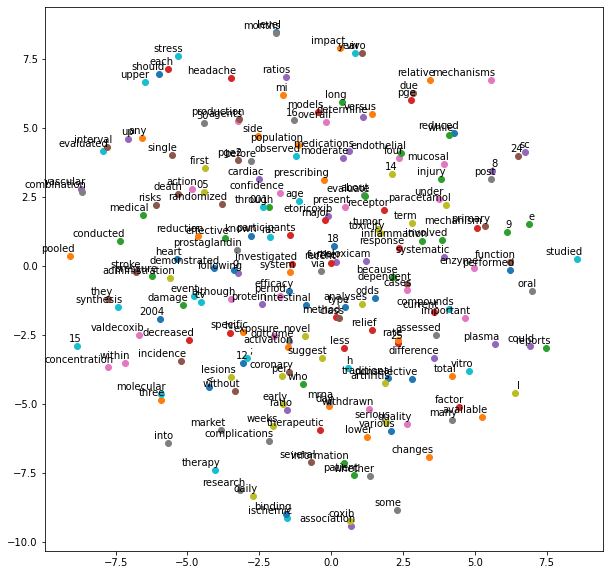

In [200]:
from sklearn.manifold import TSNE
from matplotlib import pylab

words = truncated_vocabulary[200:400]
embeddings = syn0
words_embedded = TSNE(n_components=2).fit_transform(embeddings[200:400])

pylab.figure(figsize=(10, 10))
for i, label in enumerate(words):
    x, y = words_embedded[i, :]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                 ha='right', va='bottom')
pylab.show()

## The Gensim package

The gensim package provides an API to the word2vec library, as well as several useful methods to examine vectors neighborhoods. Let's see how we can use gensim to train on the sample data corpus.

In [201]:
!pip install -q gensim==3.2.0

import gensim


Gensim expects us to provide a set of documents as a list of list of tokens. We will call the simple_preprocess() method of gensim to remove punctuation, special and uppercase characters.

In [202]:
documents = [gensim.utils.simple_preprocess(df['body_text'].iloc[i]) for i in range(len(df))]

With the wrapper api provided by the gensim package, training word2vec is as simple as defining a model and passing the set of training documents.

In [203]:
model = gensim.models.Word2Vec(documents,
                                size=100,
                                window=10,
                                min_count=2,
                                workers=10)
model.train(documents, total_examples=len(documents), epochs=10)

/opt/anaconda3/lib/python3.7/site-packages/gensim/models/word2vec.py:930: UserWarning: C extension not loaded for Word2Vec, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded for Word2Vec, training will be slow. "


847353

## Similarity

Let's assess the quality of the learned word embeddings by examining word neighborhoods.

In [208]:
model.wv.most_similar("heart",topn=5)

[('coronary', 0.9521228075027466),
 ('stroke', 0.9495779871940613),
 ('mi', 0.9485104084014893),
 ('hypertension', 0.9460744857788086),
 ('infarction', 0.9457910656929016)]

In [209]:
model.wv.most_similar("cardiovascular",topn=5)

[('cv', 0.9362390041351318),
 ('consequences', 0.9290031790733337),
 ('complications', 0.927950918674469),
 ('thrombotic', 0.9225413203239441),
 ('compatible', 0.921358585357666)]

Let's look at some polysemic words. The similar words to the word **'cox'** is the abbrevation of cyclooxygenase which is a type of **'nsaid'**. That is, they only capture a single word sense (there are no words related to the sea captan meaning of **'cox'**). Similarly, words similar to **'attack'** all reflect its medical word sense, but no sports or battle related. This is one of the major shortcomings of word2vec.

In [229]:
model.wv.most_similar("cox",topn=5)

[('oxygenase', 0.9193297624588013),
 ('cyclo', 0.9175556302070618),
 ('preferential', 0.882222592830658),
 ('never', 0.8707627654075623),
 ('cyclooxygenase', 0.8668040633201599)]

In [211]:
model.wv.most_similar("attack",topn=5)

[('failure', 0.9606034159660339),
 ('complication', 0.948014497756958),
 ('complications', 0.9312598705291748),
 ('chf', 0.9285649061203003),
 ('admission', 0.9277679324150085)]

We can examine the semantic translation properties in more detail with some vector algebra. If we start with the word **'nsaid'** and subtract **'vioxx'** and add **'rofecoxib'**, we indeed find that **'diclofenac'** is the closest word to the resulting sum. Similarly, if we invert the operation and start with the word **'cardiovascular'** and subtract **'failure'** and add **'vioxx'**, we find that **'concerns'** is closest to the sum. Note that reciprocity is not guaranteed with word2vec.

In [233]:
model.wv.similar_by_vector(model.wv['nsaid']-model.wv['vioxx'] + model.wv['rofecoxib'],topn=5)

[('diclofenac', 0.904255747795105),
 ('nsnsaid', 0.8824019432067871),
 ('ddds', 0.8794234991073608),
 ('corticosteroid', 0.8785091638565063),
 ('meloxicam', 0.870672345161438)]

In [235]:
model.wv.similar_by_vector(model.wv['cardiovascular']-model.wv['failure']+model.wv['vioxx'],topn=5)

[('concerns', 0.9304425716400146),
 ('cardiovascular', 0.9304152727127075),
 ('profile', 0.9165636301040649),
 ('toxicity', 0.9096089601516724),
 ('consequences', 0.9087710380554199)]

In [214]:
model.wv.similar_by_vector(model.wv['vioxx']-model.wv['effect']+model.wv['adverse'],topn=5)

[('adverse', 0.8966748714447021),
 ('pressures', 0.8804482221603394),
 ('withholding', 0.8287896513938904),
 ('outcomes', 0.8223862648010254),
 ('serious', 0.816508948802948)]

Tthe most similar word to **'adverse'** is **'serious'**, or the most similar word to **'headaches'** is **'migraine'**. Antonymy is hard! 

In [236]:
model.wv.most_similar("adverse",topn=5)

[('serious', 0.8877343535423279),
 ('saes', 0.8830042481422424),
 ('sudden', 0.8580660820007324),
 ('aes', 0.8564164638519287),
 ('event', 0.8485634922981262)]

In [240]:
model.wv.most_similar("headaches",topn=5)

[('migraine', 0.988572359085083),
 ('severe', 0.963401198387146),
 ('antiemetic', 0.9521772265434265),
 ('adults', 0.94819575548172),
 ('narcotic', 0.9478296637535095)]

# 3.  GloVe

Whereas word2vec captures the local context of words within sentences, GloVe embeddings can additionally account for global context across the corpus. Let's take a deeper dive on how to calculate GloVe embeddings. We begin by building a vocabulary dictionary from the corpus.



In [271]:
# Build vocab

from collections import Counter

vocab_count = Counter()

for line in corpus:
    tokens = line.strip().split()
    vocab_count.update(tokens)

vocab = {word: (i, freq) for i, (word, freq) in enumerate(vocab_count.items())}

## Co-occurence matrix



In [242]:
# Build co-occurrence matrix

from scipy import sparse

min_count = 10
window_size = 5

vocab_size = len(vocab)
id2word = dict((i, word) for word, (i, _) in vocab.items())
occurrence = sparse.lil_matrix((vocab_size, vocab_size),dtype=np.float64)

for i, line in enumerate(corpus):
    tokens = line.split()
    token_ids = [vocab[word][0] for word in tokens]

    for center_i, center_id in enumerate(token_ids):
        # Collect all word IDs in left window of center word
        context_ids = token_ids[max(0, center_i - window_size) : center_i]
        contexts_len = len(context_ids)

        for left_i, left_id in enumerate(context_ids):
            # Distance from center word
            distance = contexts_len - left_i

            # Weight by inverse of distance between words
            increment = 1.0 / float(distance)

            # Build co-occurrence matrix symmetrically (pretend we
            # are calculating right contexts as well)
            occurrence[center_id, left_id] += increment
            occurrence[left_id, center_id] += increment
    if i % 10000 == 0:
        print("Processing sentence %d" % i)

# Create a generator for efficient calculation

def occur_matrix(vocab, coccurrence, min_count):
    for i, (row, data) in enumerate(zip(coccurrence.rows, coccurrence.data)):
        if min_count is not None and vocab[id2word[i]][1] < min_count:
            continue

    for data_idx, j in enumerate(row):
        if min_count is not None and vocab[id2word[j]][1] < min_count:
            continue

        yield i, j, data[data_idx]

print("Creating co-occurrence matrix generator")
comatrix = occur_matrix(vocab, occurrence, min_count)


Processing sentence 0
Creating co-occurrence matrix generator


## GloVe training

We can now train the embeddings by iterating over the documents (sentences) in the corpus.

In [127]:
# Train Glove Embeddings

from random import shuffle
from math import log
import pickle

iterations = 30
dim = 100
learning_rate = 0.05
x_max = 100
alpha = 0.75

vocab_size = len(vocab)
W = (np.random.rand(vocab_size * 2, dim) - 0.5) / float(dim + 1)
biases = (np.random.rand(vocab_size * 2) - 0.5) / float(dim + 1)

gradient_squared = np.ones((vocab_size * 2, dim), dtype=np.float64)
gradient_squared_biases = np.ones(vocab_size * 2, dtype=np.float64)

data = [(W[i_main], W[i_context + vocab_size],
             biases[i_main : i_main + 1],
             biases[i_context + vocab_size : i_context + vocab_size + 1],
             gradient_squared[i_main], gradient_squared[i_context + vocab_size],
             gradient_squared_biases[i_main : i_main + 1],
             gradient_squared_biases[i_context + vocab_size
                                     : i_context + vocab_size + 1],
             cooccurrence)
            for i_main, i_context, cooccurrence in comatrix]

for i in range(iterations):
    global_cost = 0
    shuffle(data)
    for (v_main, v_context, b_main, b_context, gradsq_W_main, gradsq_W_context,
         gradsq_b_main, gradsq_b_context, cooccurrence) in data:

        weight = (cooccurrence / x_max) ** alpha if cooccurrence < x_max else 1

        cost_inner = (v_main.dot(v_context)
                      + b_main[0] + b_context[0]
                      - log(cooccurrence))
        cost = weight * (cost_inner ** 2)
        global_cost += 0.5 * cost

        grad_main = weight * cost_inner * v_context
        grad_context = weight * cost_inner * v_main
        grad_bias_main = weight * cost_inner
        grad_bias_context = weight * cost_inner

        v_main -= (learning_rate * grad_main / np.sqrt(gradsq_W_main))
        v_context -= (learning_rate * grad_context / np.sqrt(gradsq_W_context))

        b_main -= (learning_rate * grad_bias_main / np.sqrt(gradsq_b_main))
        b_context -= (learning_rate * grad_bias_context / np.sqrt(
                gradsq_b_context))

        gradsq_W_main += np.square(grad_main)
        gradsq_W_context += np.square(grad_context)
        gradsq_b_main += grad_bias_main ** 2
        gradsq_b_context += grad_bias_context ** 2
    print('iteration = ',i,' cost = ',global_cost)
    
# Save model

with open("glove","wb") as f:
    pickle.dump(W, f, protocol=2)

iteration =  0  cost =  0.04441237205050004
iteration =  1  cost =  0.04408096194159057
iteration =  2  cost =  0.04375416506680551
iteration =  3  cost =  0.04343183064133041
iteration =  4  cost =  0.04311356869609691
iteration =  5  cost =  0.04279968219845298
iteration =  6  cost =  0.04249008042957041
iteration =  7  cost =  0.04218456332897707
iteration =  8  cost =  0.04188297166583433
iteration =  9  cost =  0.04158556939238708
iteration =  10  cost =  0.04129231383537323
iteration =  11  cost =  0.04100301198879565
iteration =  12  cost =  0.04071753409479622
iteration =  13  cost =  0.04043575599531453
iteration =  14  cost =  0.0401576389502597
iteration =  15  cost =  0.03988308146406986
iteration =  16  cost =  0.039612470123868995
iteration =  17  cost =  0.03934533127389502
iteration =  18  cost =  0.03908175012708802
iteration =  19  cost =  0.03882144395890209
iteration =  20  cost =  0.038564432651387426
iteration =  21  cost =  0.038310876906605534
iteration =  22  c

The learned weight matrix consists of two sets of vectors, one if the word is in the main word position and one for the context word position. We will average them to generate the final GloVe embeddings for each word.

In [243]:
# Merge main and context word vectors by taking average

def merge_vectors(W, merge_fun=lambda m, c: np.mean([m, c], axis=0)):

    vocab_size = int(len(W) / 2)
    for i, row in enumerate(W[:vocab_size]):
        merged = merge_fun(row, W[i + vocab_size])
        merged /= np.linalg.norm(merged)
        W[i, :] = merged

    return W[:vocab_size]

embedding = merge_vectors(W)
len(embedding)

9701

## GloVe Vector Similarity

Let's examine the translational properties of these vectors. We define a simple function that returns the 5 most similar words to the word "man".

In [270]:
# Find most similar words

def most_similar(W, vocab, id2word, word, n=5):
    """
    Find the `n` words most similar to the given `word`. The provided
    `W` must have unit vector rows, and must have merged main- and
    context-word vectors (i.e., `len(W) == len(word2id)`).
    Returns a list of word strings.
    """

    assert len(W) == len(vocab)

    word_id = vocab[word][0]

    dists = np.dot(W, W[word_id])
    top_ids = np.argsort(dists)[::-1][:n + 1]

    return [(id2word[id],dists[id]) for id in top_ids if id != word_id][:n]

for term in most_similar(embedding, vocab, id2word, 'adverse', 5): print(term)

('cinahl', 0.3819067458708242)
('macrolide', 0.37869647943232354)
('deposited', 0.35962271176509064)
('gao', 0.3471241825856099)
('influenced', 0.3398312351149807)


Interestingly, the similarirty results fall into two categories. Whereas "woman" and "girl" have similar semantic meaning to 'man', the words "dead" and "young" do not. But these words do co-occur often, with phrases such as "young man" or "dead man". GloVe embeddings can capture both contexts. We can see this when we visualize the embeddings using T-SNE.

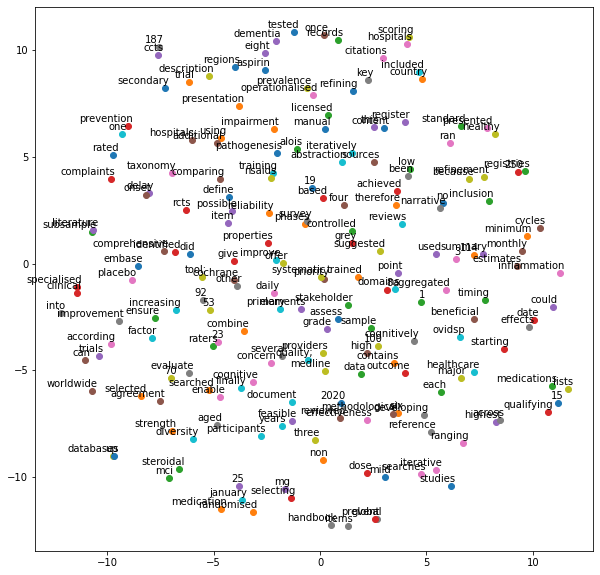

In [246]:
from sklearn.manifold import TSNE
from matplotlib import pylab

words = list(vocab.keys())[200:400]
words_embedded = TSNE(n_components=2).fit_transform(embedding[200:400])

pylab.figure(figsize=(10, 10))
for i, label in enumerate(words):
    x, y = words_embedded[i, :]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
pylab.show()

## Using the Glove Package

While useful, our python implemention is too slow to run with a large corpus. The 'glove' and 'glove_python' libraries are python packages that implement the GloVe algoritm efficiently. Let's retrain our embeddings using the 'glove_python' package.

In [255]:
# !pip install glove_python

# from glove import Corpus, Glove

# 4. Word Sense Disambiguation

Word sense disambiguation is an important task in computational linguistics. However, word2vec or GloVe embeddings map words to a single embedding vector, and therefore lack the ability to disambiguate between multiple senses of words. The sense2vec algorithm is an improved approach that can deal with polysemy or antonymy through supervised disambiguation. Moreover, sense2vec is computationally inexpensive and can be implemented as a preprocessing task prior to training a word2vec or GloVe model. To see this, let's apply the sense2vec algoritm to our corpus by leveraging the spaCy library to generate part-of-speech labels that will serve as our supervised disambiguation labels.

## Load spaCy

In [248]:
!pip install spacy
!python -m spacy download en

import spacy
nlp = spacy.load('en',disable=['parser', 'ner'])

print('Model loaded')

     |████████████████████████████████| 12.0 MB 4.8 MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.0-py3-none-any.whl size=12048606 sha256=a29a307af20b60d6fc4d9c2eb2e74a790ae963fb3d5d643d061d6db648c40863
  Stored in directory: /private/var/folders/k1/zdg8vql15kd6x75fwvjccs740000gn/T/pip-ephem-wheel-cache-y1z9dxfz/wheels/71/4a/56/e48f8ad9359a6780edd8cdd42955519b1a21d6365ad15628a2
Successfully built en-core-web-sm
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.0
    Uninstalling en-core-web-sm-2.2.0:
      Successfully uninstalled en-core-web-sm-2.2.0
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/opt/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')
Model loaded


## Supervised Disambiguation Annotations

Let's process the sentences in our corpus using the spaCy NLP annotations.

In [252]:
corpus = df['body_text'].tolist()
print("Number of docs = ",len(corpus))

docs = []
count = 0
for item in corpus:
    docs.append(nlp(item))
    count += 1
    if count % 10000 == 0:
        print("Processed document #",count)

Number of docs =  5246


In [253]:
sense_corpus = [[x.text+"_"+x.pos_ for x in y] for y in docs]
print(corpus[0])
print(' '.join(sense_corpus[0]))

chronic treatment with rofecoxib but not ischemic preconditioning of the myocardium ameliorates early intestinal damage following cardiac ischemia reperfusion injury in rats 
chronic_ADJ treatment_NOUN with_ADP rofecoxib_PROPN but_CCONJ not_PART ischemic_ADJ preconditioning_NOUN of_ADP the_DET myocardium_NOUN ameliorates_VERB early_ADJ intestinal_ADJ damage_NOUN following_VERB cardiac_ADJ ischemia_PROPN reperfusion_NOUN injury_NOUN in_ADP rats_NOUN


## Train using word2vec

With the new preprocessed corpus, we can proceed with training word2vec.

In [254]:
model = gensim.models.Word2Vec(sense_corpus,
                                size=100,
                                window=10,
                                min_count=2,
                                workers=10)
model.train(sense_corpus, total_examples=len(sense_corpus), epochs=10)

/opt/anaconda3/lib/python3.7/site-packages/gensim/models/word2vec.py:930: UserWarning: C extension not loaded for Word2Vec, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded for Word2Vec, training will be slow. "


983571

In [259]:
model.wv.most_similar("help_VERB",topn=5)

[('approval_NOUN', 0.964263916015625),
 ('inform_VERB', 0.9624056816101074),
 ('us_PRON', 0.9595066905021667),
 ('regulators_NOUN', 0.9588785171508789),
 ('multiple_ADJ', 0.9583879709243774)]

In [260]:
model.wv.most_similar("help_NOUN",topn=5)

[('relying_VERB', 0.9874491691589355),
 ('seek_VERB', 0.9864762425422668),
 ('calcineurin_PROPN', 0.9825722575187683),
 ('hepatitis_PROPN', 0.9823427200317383),
 ('oxoferryl_NOUN', 0.9811988472938538)]

# 5. Named Entity Recognition

In [170]:
df1 = articlesPD[['pubmed_id','body_text','publication_date']]
df1.head()

pubmed_id                                          body_text  \
0  32540483  Chronic treatment with rofecoxib but not ische...   
1  32508354  Role of Anti-inflammatory Drugs in the Colorec...   
2  32434933  An instrument for assessing the quality of inf...   
3  32352165  Aspirin and other non-steroidal anti-inflammat...   
4  32251635  Structural investigation on the selective COX-...   

  publication_date  
0       2020-06-17  
1       2020-06-09  
2       2020-05-22  
3       2020-05-01  
4       2020-04-07

In [171]:
# Combine all the rows of. the data as a corpus.
text = df1['body_text'].str.cat(sep=', ')

### Basic Named Entity (NE) tagging using NLTK - Word based

In [172]:
#tokenize to words
words = nltk.word_tokenize(text)
words

['Chronic',
 'treatment',
 'with',
 'rofecoxib',
 'but',
 'not',
 'ischemic',
 'preconditioning',
 'of',
 'the',
 'myocardium',
 'ameliorates',
 'early',
 'intestinal',
 'damage',
 'following',
 'cardiac',
 'ischemia/reperfusion',
 'injury',
 'in',
 'rats..',
 'There',
 'is',
 'some',
 'recent',
 'evidence',
 'that',
 'cardiac',
 'ischemia/reperfusion',
 '(',
 'I/R',
 ')',
 'injury',
 'induces',
 'intestinal',
 'damage',
 'within',
 'days',
 ',',
 'which',
 'contributes',
 'to',
 'adverse',
 'cardiovascular',
 'outcomes',
 'after',
 'myocardial',
 'infarction',
 '.',
 'However',
 ',',
 'it',
 'is',
 'not',
 'clear',
 'whether',
 'remote',
 'gut',
 'injury',
 'has',
 'any',
 'detectable',
 'early',
 'signs',
 ',',
 'and',
 'whether',
 'different',
 'interventions',
 'aiming',
 'to',
 'reduce',
 'cardiac',
 'damage',
 'are',
 'also',
 'effective',
 'at',
 'protecting',
 'the',
 'intestine',
 '.',
 'Previously',
 ',',
 'we',
 'found',
 'that',
 'chronic',
 'treatment',
 'with',
 'rofecoxi

In [173]:
#Part of speech tagging
pos_tags = nltk.pos_tag(words)
pos_tags

[('Chronic', 'JJ'),
 ('treatment', 'NN'),
 ('with', 'IN'),
 ('rofecoxib', 'NNS'),
 ('but', 'CC'),
 ('not', 'RB'),
 ('ischemic', 'JJ'),
 ('preconditioning', 'NN'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('myocardium', 'NN'),
 ('ameliorates', 'VBZ'),
 ('early', 'JJ'),
 ('intestinal', 'JJ'),
 ('damage', 'NN'),
 ('following', 'VBG'),
 ('cardiac', 'JJ'),
 ('ischemia/reperfusion', 'NN'),
 ('injury', 'NN'),
 ('in', 'IN'),
 ('rats..', 'NN'),
 ('There', 'EX'),
 ('is', 'VBZ'),
 ('some', 'DT'),
 ('recent', 'JJ'),
 ('evidence', 'NN'),
 ('that', 'IN'),
 ('cardiac', 'JJ'),
 ('ischemia/reperfusion', 'NN'),
 ('(', '('),
 ('I/R', 'NNP'),
 (')', ')'),
 ('injury', 'NN'),
 ('induces', 'NNS'),
 ('intestinal', 'JJ'),
 ('damage', 'NN'),
 ('within', 'IN'),
 ('days', 'NNS'),
 (',', ','),
 ('which', 'WDT'),
 ('contributes', 'VBZ'),
 ('to', 'TO'),
 ('adverse', 'VB'),
 ('cardiovascular', 'JJ'),
 ('outcomes', 'NNS'),
 ('after', 'IN'),
 ('myocardial', 'JJ'),
 ('infarction', 'NN'),
 ('.', '.'),
 ('However', 'RB'),
 (',', '

### ne_chunk

### Binary=True

In [174]:
chunks = nltk.ne_chunk(pos_tags, binary=True) #either NE or not NE
for chunk in chunks:
    print(chunk)

(NE Chronic/JJ)
('treatment', 'NN')
('with', 'IN')
('rofecoxib', 'NNS')
('but', 'CC')
('not', 'RB')
('ischemic', 'JJ')
('preconditioning', 'NN')
('of', 'IN')
('the', 'DT')
('myocardium', 'NN')
('ameliorates', 'VBZ')
('early', 'JJ')
('intestinal', 'JJ')
('damage', 'NN')
('following', 'VBG')
('cardiac', 'JJ')
('ischemia/reperfusion', 'NN')
('injury', 'NN')
('in', 'IN')
('rats..', 'NN')
('There', 'EX')
('is', 'VBZ')
('some', 'DT')
('recent', 'JJ')
('evidence', 'NN')
('that', 'IN')
('cardiac', 'JJ')
('ischemia/reperfusion', 'NN')
('(', '(')
('I/R', 'NNP')
(')', ')')
('injury', 'NN')
('induces', 'NNS')
('intestinal', 'JJ')
('damage', 'NN')
('within', 'IN')
('days', 'NNS')
(',', ',')
('which', 'WDT')
('contributes', 'VBZ')
('to', 'TO')
('adverse', 'VB')
('cardiovascular', 'JJ')
('outcomes', 'NNS')
('after', 'IN')
('myocardial', 'JJ')
('infarction', 'NN')
('.', '.')
('However', 'RB')
(',', ',')
('it', 'PRP')
('is', 'VBZ')
('not', 'RB')
('clear', 'JJ')
('whether', 'IN')
('remote', 'JJ')
('gut'

('.', '.')
('There', 'EX')
('is', 'VBZ')
('no', 'DT')
('evidence', 'NN')
('to', 'TO')
('support', 'VB')
('the', 'DT')
('use', 'NN')
('of', 'IN')
('low-dose', 'JJ')
('aspirin', 'NN')
('or', 'CC')
('other', 'JJ')
(NE NSAIDs/NNP)
('of', 'IN')
('any', 'DT')
('class', 'NN')
('(', '(')
('celecoxib', 'NN')
(',', ',')
('rofecoxib', 'NN')
('or', 'CC')
('naproxen', 'NN')
(')', ')')
('for', 'IN')
('the', 'DT')
('prevention', 'NN')
('of', 'IN')
('dementia', 'NN')
(',', ',')
('but', 'CC')
('there', 'EX')
('was', 'VBD')
('evidence', 'NN')
('of', 'IN')
('harm', 'NN')
('.', '.')
('Although', 'IN')
('there', 'EX')
('were', 'VBD')
('limitations', 'NNS')
('in', 'IN')
('the', 'DT')
('available', 'JJ')
('evidence', 'NN')
(',', ',')
('it', 'PRP')
('seems', 'VBZ')
('unlikely', 'JJ')
('that', 'IN')
('there', 'EX')
('is', 'VBZ')
('any', 'DT')
('need', 'NN')
('for', 'IN')
('further', 'JJ')
('trials', 'NNS')
('of', 'IN')
('low-dose', 'JJ')
('aspirin', 'NN')
('for', 'IN')
('dementia', 'NN')
('prevention', 'NN')
(

(',', ',')
('stimulated', 'VBD')
('extracellular', 'JJ')
('regulated', 'JJ')
('kinase', 'NN')
('(', '(')
(NE ERK/NNP)
(')', ')')
('1/2', 'CD')
('activity', 'NN')
('in', 'IN')
('a', 'DT')
('time-', 'JJ')
('and', 'CC')
('concentration-dependent', 'JJ')
('manner', 'NN')
('.', '.')
('Oxytocin', 'NNP')
('and', 'CC')
('atosiban', 'RB')
('stimulated', 'VBD')
('cyclo-oxygenase', 'JJ')
('2', 'CD')
('activity', 'NN')
('and', 'CC')
('subsequent', 'JJ')
('production', 'NN')
('of', 'IN')
('prostaglandin', 'NN')
('E2', 'NNP')
('and', 'CC')
(NE F2α/NNP)
('.', '.')
('Prostaglandin', 'NNP')
('production', 'NN')
('was', 'VBD')
('inhibited', 'VBN')
('by', 'IN')
('rofecoxib', 'NN')
(',', ',')
('pertussin', 'NN')
('toxin', 'NN')
(',', ',')
('and', 'CC')
(NE ERK/NNP)
('inhibitor', 'NN')
('U0126', 'NNP')
('.', '.')
('Oxytocin', 'NNP')
('but', 'CC')
('not', 'RB')
('retosiban', 'VB')
('or', 'CC')
('atosiban', 'VB')
('stimulated', 'JJ')
('coupling', 'NN')
('of', 'IN')
('the', 'DT')
(NE OTR/NNP)
('to', 'TO')
('G

('binding', 'NN')
('site', 'NN')
('for', 'IN')
(NE LAML/NNP)
('was', 'VBD')
('located', 'VBN')
('at', 'IN')
('β-37', 'JJ')
('tryptophan', 'NN')
('in', 'IN')
('the', 'DT')
('central', 'JJ')
('cavity', 'NN')
('of', 'IN')
(NE BHb/NNP)
('.', '.')
(NE Van/NNP)
('der', 'NN')
('Waals', 'NNP')
('force', 'NN')
('and', 'CC')
('hydrogen', 'NN')
('bonds', 'NNS')
('played', 'VBD')
('major', 'JJ')
('roles', 'NNS')
('in', 'IN')
('this', 'DT')
('binding', 'NN')
('process', 'NN')
(',', ',')
('and', 'CC')
('the', 'DT')
('number', 'NN')
('of', 'IN')
('binding', 'VBG')
('sites', 'NNS')
('(', '(')
('n', 'NN')
(')', ')')
('in', 'IN')
('the', 'DT')
('binary', 'JJ')
('system', 'NN')
('was', 'VBD')
('approximately', 'RB')
('equal', 'JJ')
('to', 'TO')
('1', 'CD')
('.', '.')
('Multiple', 'JJ')
('spectroscopy', 'NN')
('experiments', 'NNS')
('(', '(')
('FT-IR', 'CD')
('and', 'CC')
('three-dimensional', 'JJ')
('fluorescence', 'NN')
('spectrometry', 'NN')
(')', ')')
('and', 'CC')
('a', 'DT')
('dynamics', 'NNS')
('si

(')', ')')
('.', '.')
('Similar', 'JJ')
('results', 'NNS')
('were', 'VBD')
('seen', 'VBN')
('for', 'IN')
('each', 'DT')
('outcome', 'NN')
('separately', 'RB')
('.', '.')
('When', 'WRB')
('celecoxib', 'NN')
('was', 'VBD')
('used', 'VBN')
('as', 'IN')
('reference', 'NN')
(',', ',')
('ibuprofen', 'NN')
('(', '(')
('HRs', 'NNP')
(':', ':')
('0.81', 'CD')
('[', 'JJ')
('CI', 'NNP')
(':', ':')
('0.74-0.90', 'JJ')
(']', 'NN')
(')', ')')
('and', 'CC')
('naproxen', '$')
('(', '(')
('HRs', 'NNP')
(':', ':')
('0.81', 'CD')
('[', 'IN')
('0.68-0.97', 'JJ')
(']', 'NN')
(')', ')')
('exhibited', 'VBD')
('a', 'DT')
('lower', 'JJR')
('cardiovascular', 'NN')
('risk', 'NN')
(',', ',')
('even', 'RB')
('when', 'WRB')
('low', 'JJ')
('doses', 'NNS')
('were', 'VBD')
('compared', 'VBN')
('.', '.')
('Low-dose', 'JJ')
('naproxen', 'NN')
('and', 'CC')
('ibuprofen', 'NN')
('were', 'VBD')
('associated', 'VBN')
('with', 'IN')
('the', 'DT')
('lowest', 'JJS')
('risks', 'NNS')
('of', 'IN')
('the', 'DT')
('composite', 'JJ

('Overall', 'NNP')
(',', ',')
(NE NSAIDs/NNP)
('were', 'VBD')
('found', 'VBN')
('to', 'TO')
('be', 'VB')
('associated', 'VBN')
('with', 'IN')
('a', 'DT')
('statistically', 'RB')
('significantly', 'RB')
('increased', 'VBN')
(NE CVR/NNP)
('(', '(')
('RR', 'NNP')
(',', ',')
('1.24', 'CD')
('[', 'JJ')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
(',', ',')
('1.19-1.28', 'JJ')
(']', 'NN')
(')', ')')
('.', '.')
('The', 'DT')
('risk', 'NN')
('was', 'VBD')
('slightly', 'RB')
('higher', 'JJR')
('for', 'IN')
('coxibs', 'NN')
('(', '(')
('RR', 'NNP')
(',', ',')
('1.22', 'CD')
('[', 'JJ')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
(',', ',')
('1.17-1.28', 'JJ')
(']', 'NN')
(')', ')')
('as', 'IN')
('compared', 'VBN')
('with', 'IN')
('nonselective', 'JJ')
(NE NSAIDs/NNP)
('(', '(')
('RR', 'NNP')
(',', ',')
('1.18', 'CD')
('[', 'JJ')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
(',', ',')
('1.12-1.24', 'JJ')
(']', 'NN')
(')', ')')
('.', '.')
('Data', 'NNP')
('analysis', 'NN')
('by', 'IN')
('drug', 'NN')
('disclosed'

('(', '(')
('32.4', 'CD')
('%', 'NN')
(')', ')')
('.', '.')
('The', 'DT')
('percentage', 'NN')
('of', 'IN')
('reports', 'NNS')
('of', 'IN')
('disability', 'NN')
('was', 'VBD')
('highest', 'JJS')
('during', 'IN')
('2006', 'CD')
('(', '(')
('12.1', 'CD')
('%', 'NN')
(')', ')')
('.', '.')
('Overall', 'UH')
(',', ',')
('the', 'DT')
('``', '``')
('other', 'JJ')
('serious', 'JJ')
('outcomes', 'NNS')
("''", "''")
('category', 'NN')
('accounted', 'VBD')
('for', 'IN')
('almost', 'RB')
('65', 'CD')
('%', 'NN')
('of', 'IN')
('serious', 'JJ')
('ADEs', 'NNP')
('reports', 'NNS')
('.', '.')
('Expedited', 'VBN')
('reports', 'NNS')
('from', 'IN')
('drug', 'NN')
('manufacturers', 'NNS')
('were', 'VBD')
('most', 'RBS')
('common', 'JJ')
('(', '(')
('about', 'IN')
('72', 'CD')
('%', 'NN')
(')', ')')
('of', 'IN')
('the', 'DT')
('serious', 'JJ')
('ADEs', 'NNP')
('with', 'IN')
('available', 'JJ')
('data', 'NNS')
('on', 'IN')
('report', 'NN')
('type', 'NN')
('.', '.')
('Health', 'NNP')
('professionals', 'NNS')

('.', '.')
('Most', 'JJS')
('adult', 'JJ')
(NE PWH/NNP)
('experience', 'NN')
('limitations', 'NNS')
('in', 'IN')
('activities', 'NNS')
('of', 'IN')
('daily', 'JJ')
('living', 'NN')
(',', ',')
('and', 'CC')
('chronic', 'JJ')
('articular', 'NN')
('pain', 'NN')
('affects', 'VBZ')
('their', 'PRP$')
('mental', 'JJ')
('health', 'NN')
('.', '.')
('Pharmacologic', 'NNP')
('treatment', 'NN')
('of', 'IN')
('pain', 'NN')
('in', 'IN')
('adult', 'NN')
(NE PWH/NNP)
('has', 'VBZ')
('frequently', 'RB')
('proven', 'VBN')
('to', 'TO')
('be', 'VB')
('inadequate', 'JJ')
('.', '.')
('The', 'DT')
('optimal', 'JJ')
('pharmacologic', 'JJ')
('treatment', 'NN')
('of', 'IN')
('chronic', 'JJ')
('articular', 'JJ')
('pain', 'NN')
('in', 'IN')
('these', 'DT')
('patients', 'NNS')
('is', 'VBZ')
('the', 'DT')
('use', 'NN')
('of', 'IN')
('paracetamol', 'NN')
('and', 'CC')
('COX-2', 'JJ')
('inhibitors', 'NNS')
('.', '.')
('Physical', 'JJ')
('medicine', 'NN')
(',', ',')
('rehabilitation', 'NN')
('and', 'CC')
('intra-artic

('the', 'DT')
(NE Cochrane/NNP Central/NNP)
('databases', 'NNS')
(',', ',')
('and', 'CC')
('ClinicalTrials.gov', 'NNP')
(',', ',')
('up', 'RB')
('until', 'IN')
('March', 'NNP')
('26', 'CD')
(',', ',')
('2017', 'CD')
(',', ',')
('identified', 'VBN')
('relevant', 'JJ')
('randomized', 'VBN')
('controlled', 'JJ')
('trials', 'NNS')
('.', '.')
('Data', 'NNP')
('analysis', 'NN')
('was', 'VBD')
('performed', 'VBN')
('using', 'VBG')
('Stata', 'NNP')
('12.0', 'CD')
('.', '.')
('Six', 'NNP')
('eligible', 'JJ')
('trials', 'NNS')
('(', '(')
('1,794', 'CD')
('patients', 'NNS')
(')', ')')
('were', 'VBD')
('selected', 'VBN')
('from', 'IN')
('the', 'DT')
('407', 'CD')
('studies', 'NNS')
('that', 'WDT')
('were', 'VBD')
('identified', 'VBN')
('initially', 'RB')
('.', '.')
('A', 'DT')
('significant', 'JJ')
('difference', 'NN')
(',', ',')
('favoring', 'VBG')
('COX-2', 'JJ')
('inhibitors', 'NNS')
('plus', 'CC')
('chemotherapy', 'NN')
('over', 'IN')
('chemotherapy', 'NN')
('alone', 'RB')
(',', ',')
('was', '

('effect', 'NN')
('and', 'CC')
('deserves', 'VBZ')
('further', 'RB')
('study', 'NN')
('as', 'IN')
('a', 'DT')
('possible', 'JJ')
('mechanism', 'NN')
('to', 'TO')
('modulate', 'VB')
('disease', 'NN')
('risk.', 'NN')
(',', ',')
(NE Abacavir/NNP Induces/NNP Arterial/NNP Thrombosis/NNP)
('in', 'IN')
('a', 'DT')
(NE Murine/NNP)
('Model..', 'NNP')
('The', 'DT')
('purinergic', 'NN')
('system', 'NN')
('is', 'VBZ')
('known', 'VBN')
('to', 'TO')
('underlie', 'VB')
('prothrombotic', 'JJ')
('and', 'CC')
('proinflammatory', 'JJ')
('vascular', 'JJ')
('programs', 'NNS')
(',', ',')
('making', 'VBG')
('the', 'DT')
('profile', 'NN')
('of', 'IN')
('experimental', 'JJ')
('actions', 'NNS')
('demonstrated', 'VBN')
('by', 'IN')
('abacavir', 'NN')
('compatible', 'JJ')
('with', 'IN')
('thrombogenesis', 'NN')
('.', '.')
('However', 'RB')
(',', ',')
('direct', 'JJ')
('evidence', 'NN')
('of', 'IN')
('a', 'DT')
('prothrombotic', 'JJ')
('effect', 'NN')
('by', 'IN')
('the', 'DT')
('drug', 'NN')
('has', 'VBZ')
('been

('toxic', 'NN')
(',', ',')
('efficacious', 'JJ')
('treatment', 'NN')
('and', 'CC')
('principally', 'RB')
('demonstrates', 'VBZ')
('that', 'IN')
('such', 'JJ')
('approaches', 'NNS')
('should', 'MD')
('be', 'VB')
('followed', 'VBN')
('further', 'JJ')
('for', 'IN')
('treatment', 'NN')
('of', 'IN')
('advanced', 'JJ')
('HCC.', 'NNP')
(',', ',')
(NE Synthesis/NNP)
('and', 'CC')
(NE Biological/NNP Evaluation/NNP)
('of', 'IN')
('2H-Indazole', 'JJ')
('Derivatives', 'NNS')
(':', ':')
('Towards', 'NNP')
('Antimicrobial', 'NNP')
('and', 'CC')
('Anti-Inflammatory', 'NNP')
('Dual', 'NNP')
('Agents..', 'NNP')
('Indazole', 'NNP')
('is', 'VBZ')
('considered', 'VBN')
('a', 'DT')
('very', 'RB')
('important', 'JJ')
('scaffold', 'NN')
('in', 'IN')
('medicinal', 'JJ')
('chemistry', 'NN')
('.', '.')
('It', 'PRP')
('is', 'VBZ')
('commonly', 'RB')
('found', 'VBN')
('in', 'IN')
('compounds', 'NNS')
('with', 'IN')
('diverse', 'JJ')
('biological', 'JJ')
('activities', 'NNS')
(',', ',')
('e.g.', 'NN')
(',', ',')
(

('of', 'IN')
('morbidity', 'NN')
('in', 'IN')
('the', 'DT')
('world', 'NN')
('today', 'NN')
(',', ',')
('chronic', 'JJ')
('disease', 'NN')
('(', '(')
('and', 'CC')
('its', 'PRP$')
('associated', 'JJ')
('pain', 'NN')
(')', ')')
('is', 'VBZ')
('a', 'DT')
('major', 'JJ')
('health', 'NN')
('concern', 'NN')
('.', '.')
('Chronic', 'NNP')
('pain', 'NN')
('(', '(')
('that', 'WDT')
('is', 'VBZ')
('pain', 'JJ')
('lasting', 'JJ')
('three', 'CD')
('months', 'NNS')
('or', 'CC')
('longer', 'JJR')
(')', ')')
('can', 'MD')
('arise', 'VB')
('in', 'IN')
('the', 'DT')
('paediatric', 'JJ')
('population', 'NN')
('in', 'IN')
('a', 'DT')
('variety', 'NN')
('of', 'IN')
('pathophysiological', 'JJ')
('classifications', 'NNS')
('(', '(')
('nociceptive', 'JJ')
(',', ',')
('neuropathic', 'JJ')
(',', ',')
('or', 'CC')
('idiopathic', 'JJ')
(')', ')')
('from', 'IN')
('genetic', 'JJ')
('conditions', 'NNS')
(',', ',')
('nerve', 'NN')
('damage', 'NN')
('pain', 'NN')
(',', ',')
('chronic', 'JJ')
('musculoskeletal', 'NN')

('rofecoxib', 'NN')
('and', 'CC')
('indomethacin', 'NN')
('as', 'IN')
('standard', 'JJ')
('drugs', 'NNS')
('.', '.')
('In', 'IN')
('vitro', 'JJ')
('antioxidant', 'JJ')
('activity', 'NN')
('of', 'IN')
('the', 'DT')
('compounds', 'NNS')
('was', 'VBD')
('assessed', 'VBN')
('by', 'IN')
('potassium', 'NN')
('ferricyanide', 'NN')
('reducing', 'VBG')
('power', 'NN')
('(', '(')
(NE PFRAP/NNP)
(')', ')')
('assay', 'VBP')
('.', '.')
('The', 'DT')
('compounds', 'NNS')
('9', 'CD')
(',', ',')
('10', 'CD')
('and', 'CC')
('11', 'CD')
('showed', 'VBD')
('anti-inflammatory', 'JJ')
('activity', 'NN')
('comparable', 'JJ')
('to', 'TO')
('the', 'DT')
('standard', 'JJ')
('group', 'NN')
('and', 'CC')
('were', 'VBD')
('also', 'RB')
('non-ulcerogenic', 'JJ')
('at', 'IN')
('the', 'DT')
('test', 'NN')
('doses', 'VBZ')
('.', '.')
('Compounds', 'VBZ')
('6-11', 'JJ')
('exhibited', 'JJ')
('good', 'JJ')
('antioxidant', 'NN')
('effect', 'NN')
('in', 'IN')
('the', 'DT')
('concentration', 'NN')
('range', 'NN')
('(', '('

('same', 'JJ')
('medication', 'NN')
('as', 'IN')
('intervention', 'NN')
(',', ',')
('or', 'CC')
('other', 'JJ')
('nonnarcotic', 'JJ')
('or', 'CC')
('narcotic', 'JJ')
('medication', 'NN')
('.', '.')
('Study', 'NNP')
('data', 'NNS')
('were', 'VBD')
('extracted', 'VBN')
('by', 'IN')
('one', 'CD')
('reviewer', 'NN')
('and', 'CC')
('confirmed', 'VBN')
('by', 'IN')
('a', 'DT')
('second', 'JJ')
('reviewer', 'NN')
('.', '.')
('For', 'IN')
('each', 'DT')
('outcome', 'NN')
('we', 'PRP')
('graded', 'VBD')
('the', 'DT')
('quality', 'NN')
('of', 'IN')
('the', 'DT')
('evidence', 'NN')
('.', '.')
('Studies', 'NNS')
('were', 'VBD')
('classified', 'VBN')
('by', 'IN')
('the', 'DT')
('type', 'NN')
('of', 'IN')
('medication', 'NN')
('used', 'VBN')
('and', 'CC')
('by', 'IN')
('outcome', 'JJ')
('type', 'NN')
('.', '.')
('Eighty-four', 'JJ')
('trials', 'NNS')
('met', 'VBD')
('eligibility', 'NN')
(',', ',')
('with', 'IN')
('69', 'CD')
('included', 'NNS')
('.', '.')
('Among', 'IN')
('nonnarcotic', 'JJ')
('medi

('hospital', 'NN')
('stay', 'NN')
(',', ',')
('and', 'CC')
('patient', 'JJ')
('satisfaction', 'NN')
('.', '.')
('There', 'EX')
('were', 'VBD')
('26', 'CD')
('clinical', 'JJ')
('trials', 'NNS')
('included', 'VBD')
('in', 'IN')
('the', 'DT')
('review', 'NN')
('.', '.')
('Oral', 'NNP')
('oxycodone', 'NN')
('showed', 'VBD')
('superior', 'JJ')
('postoperative', 'JJ')
('analgesic', 'JJ')
('efficacy', 'NN')
('compared', 'VBN')
('with', 'IN')
('placebo', 'NN')
('in', 'IN')
('patients', 'NNS')
('undergoing', 'VBG')
('laparoscopic', 'JJ')
('cholecystectomy', 'NN')
(',', ',')
('abdominal', 'JJ')
('or', 'CC')
('pelvic', 'JJ')
('surgery', 'NN')
(',', ',')
('bunionectomy', 'NN')
(',', ',')
('breast', 'NN')
('surgery', 'NN')
(',', ',')
('and', 'CC')
('spine', 'NN')
('surgery', 'NN')
('.', '.')
('When', 'WRB')
('compared', 'VBN')
('with', 'IN')
('intravenous', 'JJ')
('opioids', 'NNS')
(',', ',')
('oral', 'JJ')
('oxycodone', 'NN')
('provided', 'VBD')
('better', 'RBR')
('or', 'CC')
('comparable', 'JJ')


('(', '(')
('composite', 'JJ')
('CV', 'NNP')
('outcomes', 'NNS')
(')', ')')
('.', '.')
('Twenty-six', 'JJ')
('studies', 'NNS')
('were', 'VBD')
('found', 'VBN')
('that', 'IN')
('met', 'JJ')
('inclusion', 'NN')
('and', 'CC')
('exclusion', 'NN')
('criteria', 'NNS')
('.', '.')
('Comparisons', 'NNS')
('were', 'VBD')
('made', 'VBN')
('between', 'IN')
('all', 'DT')
('included', 'VBD')
('drugs', 'NNS')
(',', ',')
('against', 'IN')
('placebo', 'NN')
(',', ',')
('and', 'CC')
('against', 'IN')
('non-selective', 'JJ')
(NE NSAIDs/NNP)
('(', '(')
(NE nsNSAIDs/NN)
(')', ')')
('.', '.')
('Drugs', 'NNS')
('were', 'VBD')
('also', 'RB')
('compared', 'VBN')
('against', 'IN')
('COX-2', 'NNP')
('selective', 'JJ')
('inhibitors', 'NNS')
('(', '(')
(NE COXIBs/NNP)
(')', ')')
('with', 'IN')
('and', 'CC')
('without', 'IN')
('inclusion', 'NN')
('of', 'IN')
('rofecoxib', 'NN')
('.', '.')
('Incidence', 'NN')
('of', 'IN')
(NE MI/NNP)
('was', 'VBD')
('increased', 'VBN')
('by', 'IN')
('rofecoxib', 'NN')
('in', 'IN')
(

('of', 'IN')
('these', 'DT')
('side', 'NN')
('effects', 'NNS')
('are', 'VBP')
('associated', 'VBN')
('with', 'IN')
('or', 'CC')
('caused', 'VBN')
('by', 'IN')
('generation', 'NN')
('of', 'IN')
('oxidative', 'JJ')
('stress', 'NN')
('.', '.')
('Following', 'VBG')
('the', 'DT')
('withdrawal', 'NN')
('of', 'IN')
('a', 'DT')
('cyclo-oxygenase-2', 'JJ')
('(', '(')
('COX-2', 'NNP')
(')', ')')
('inhibitor', 'NN')
('drug', 'NN')
(',', ',')
('rofecoxib', 'NN')
('(', '(')
('VIOXX®', 'NNP')
(')', ')')
('due', 'JJ')
('to', 'TO')
('cardiovascular', 'JJ')
('complications', 'NNS')
(',', ',')
('scientists', 'NNS')
('suggested', 'VBD')
('that', 'IN')
('natural', 'JJ')
('COX-2', 'NNP')
('inhibitors', 'NNS')
('might', 'MD')
('provide', 'VB')
('valuable', 'JJ')
('alternatives', 'NNS')
('to', 'TO')
(NE COX/NNP)
('inhibitors', 'NNS')
('.', '.')
('Although', 'IN')
(',', ',')
('most', 'JJS')
('of', 'IN')
('medicinal', 'JJ')
('plants', 'NNS')
('reduce', 'VB')
('pain', 'NN')
('and', 'CC')
('inflammation', 'NN')


(',', ',')
('a', 'DT')
('flawed', 'VBN')
('peer-review', 'NN')
('system', 'NN')
('and', 'CC')
('an', 'DT')
('uncritical', 'JJ')
('medical', 'JJ')
('readership', 'NN')
('.', '.')
('Perhaps', 'RB')
('the', 'DT')
('most', 'RBS')
('troubling', 'JJ')
('is', 'VBZ')
('that', 'IN')
('the', 'DT')
('factors', 'NNS')
('that', 'WDT')
('coalesced', 'VBD')
('into', 'IN')
('the', 'DT')
(NE Vioxx/NNP)
('scandal', 'NN')
('are', 'VBP')
(',', ',')
('if', 'IN')
('anything', 'NN')
(',', ',')
('more', 'RBR')
('ubiquitous', 'JJ')
('today', 'NN')
(',', ',')
('mandating', 'VBG')
('increased', 'VBN')
('vigilance', 'NN')
('to', 'TO')
('decrease', 'VB')
('the', 'DT')
('probability', 'NN')
('of', 'IN')
('``', '``')
('getting', 'VBG')
('fooled', 'VBN')
("''", "''")
('again.', 'NN')
(',', ',')
(NE Ibuprofen/NNP)
('arginate', 'NN')
('retains', 'NNS')
('eNOS', 'VBP')
('substrate', 'JJ')
('activity', 'NN')
('and', 'CC')
('reverses', 'VBZ')
('endothelial', 'JJ')
('dysfunction', 'NN')
(':', ':')
('implications', 'NNS')
(

('increase', 'NN')
('in', 'IN')
(NE GBF/NNP)
('and', 'CC')
('the', 'DT')
('reduction', 'NN')
('in', 'IN')
('basal', 'NN')
('and', 'CC')
('histamine-', 'NN')
('or', 'CC')
('pentagastrin-stimulated', 'JJ')
('gastric', 'JJ')
('acid', 'NN')
('secretion', 'NN')
('.', '.')
('The', 'DT')
('protective', 'JJ')
('and', 'CC')
('hyperemic', 'JJ')
('activities', 'NNS')
('of', 'IN')
('curcumin', 'NN')
('(', '(')
('50', 'CD')
('mg/kg', 'NN')
('i.g', 'NN')
('.', '.')
(')', ')')
('against', 'IN')
(NE WRS/NNP)
('lesions', 'NNS')
('were', 'VBD')
('significantly', 'RB')
('attenuated', 'VBN')
('(', '(')
('P', 'NNP')
('<', 'NNP')
('0.05', 'CD')
(')', ')')
('in', 'IN')
('rats', 'NNS')
('pretreated', 'VBN')
('with', 'IN')
('rofecoxib', 'NN')
('and', 'CC')
('SC-560', 'NNP')
('and', 'CC')
('completely', 'RB')
('reversed', 'VBN')
('(', '(')
('P', 'NNP')
('<', 'NNP')
('0.01', 'CD')
(')', ')')
('by', 'IN')
('indomethacin', 'NN')
('.', '.')
('L-NNA', 'NNP')
('significantly', 'RB')
('reduced', 'VBD')
('(', '(')
('P'

(':', ':')
('a', 'DT')
('UK', 'JJ')
('population-based', 'JJ')
('case-control', 'NN')
('study..', 'NN')
('We', 'PRP')
('aimed', 'VBD')
('to', 'TO')
('examine', 'VB')
('whether', 'IN')
('the', 'DT')
('current', 'JJ')
('users', 'NNS')
('of', 'IN')
('specific', 'JJ')
('NSAIDs', 'NNP')
('have', 'VBP')
('an', 'DT')
('increased', 'VBN')
('risk', 'NN')
('of', 'IN')
('venous', 'JJ')
('thromboembolism', 'NN')
('(', '(')
(NE VTE/NNP)
(')', ')')
('among', 'IN')
('knee', 'JJ')
('OA', 'NNP')
('patients', 'NNS')
('.', '.')
('We', 'PRP')
('conducted', 'VBD')
('a', 'DT')
('population-based', 'JJ')
('case-control', 'NN')
('study', 'NN')
('using', 'VBG')
('The', 'DT')
(NE Health/NNP Improvement/NNP Network/NNP)
(',', ',')
('a', 'DT')
('database', 'NN')
('of', 'IN')
('patient', 'NN')
('records', 'NNS')
('from', 'IN')
('general', 'JJ')
('practices', 'NNS')
('in', 'IN')
('the', 'DT')
('UK', 'NNP')
('.', '.')
('For', 'IN')
('every', 'DT')
('VTE', 'NNP')
('case', 'NN')
(',', ',')
('we', 'PRP')
('identified',

('measures', 'NNS')
('of', 'IN')
('benefits', 'NNS')
('and', 'CC')
('risks', 'NNS')
('into', 'IN')
('a', 'DT')
('single', 'JJ')
('value', 'NN')
('.', '.')
('To', 'TO')
('examine', 'VB')
(NE BRA/NNP)
('metrics', 'NNS')
('for', 'IN')
('prospective', 'JJ')
('monitoring', 'NN')
('of', 'IN')
('new', 'JJ')
('drugs', 'NNS')
('in', 'IN')
('electronic', 'JJ')
('health', 'NN')
('care', 'NN')
('data', 'NNS')
('.', '.')
('Using', 'VBG')
('two', 'CD')
('electronic', 'JJ')
('health', 'NN')
('care', 'NN')
('databases', 'NNS')
(',', ',')
('we', 'PRP')
('emulated', 'VBD')
('prospective', 'JJ')
('monitoring', 'NN')
('of', 'IN')
('three', 'CD')
('drugs', 'NNS')
('(', '(')
('rofecoxib', 'NN')
('vs.', 'FW')
('nonselective', 'JJ')
('nonsteroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
(',', ',')
('prasugrel', 'NN')
('vs.', 'FW')
('clopidogrel', 'NN')
(',', ',')
('and', 'CC')
('denosumab', 'NN')
('vs.', 'FW')
('bisphosphonates', 'NNS')
(')', ')')
('using', 'VBG')
('a', 'DT')
('sequential', 'JJ')

('attributed', 'VBD')
('to', 'TO')
('the', 'DT')
('various', 'JJ')
('prostanoid', 'JJ')
('receptors', 'NNS')
('.', '.')
('Multitargeting', 'NNP')
('of', 'IN')
('selected', 'VBN')
('prostanoid', 'NN')
('receptors', 'NNS')
('yielded', 'VBD')
('a', 'DT')
('prototype', 'NN')
('compound', 'NN')
(',', ',')
('compound', 'NN')
('1', 'CD')
('(', '(')
('AGN', 'NNP')
('211377', 'CD')
(')', ')')
(',', ',')
('that', 'WDT')
('antagonizes', 'VBZ')
('prostaglandin', 'JJ')
('D2', 'NNP')
('receptors', 'NNS')
('(', '(')
(NE DPs/NNP)
(')', ')')
('DP1', 'NNP')
('(', '(')
('49', 'CD')
(')', ')')
('and', 'CC')
(NE DP2/NNP)
('(', '(')
('558', 'CD')
(')', ')')
(',', ',')
('prostaglandin', 'JJ')
('E2', 'NNP')
('receptors', 'NNS')
('(', '(')
(NE EPs/NNP)
(')', ')')
('EP1', 'NNP')
('(', '(')
('266', 'CD')
(')', ')')
('and', 'CC')
(NE EP4/NNP)
('(', '(')
('117', 'CD')
(')', ')')
(',', ',')
('prostaglandin', 'JJ')
(NE F2α/NNP)
('receptor', 'NN')
('(', '(')
('FP', 'NNP')
(')', ')')
('(', '(')
('61', 'CD')
(')', ')')

('and', 'CC')
('health', 'NN')
('care', 'NN')
('professionals', 'NNS')
('but', 'CC')
('also', 'RB')
('product', 'NN')
('sales', 'NNS')
('and', 'CC')
('prescribing', 'VBG')
('habits', 'NNS')
('in', 'IN')
('the', 'DT')
('5', 'CD')
('years', 'NNS')
('since', 'IN')
('its', 'PRP$')
('implementation', 'NN')
('.', '.')
('Recognizing', 'VBG')
('that', 'IN')
('in', 'IN')
('the', 'DT')
('past', 'JJ')
('2', 'CD')
('years', 'NNS')
(',', ',')
('the', 'DT')
('use', 'NN')
('of', 'IN')
(NE REMS/NNP)
('has', 'VBZ')
('shifted', 'VBN')
('markedly', 'RB')
(',', ',')
('we', 'PRP')
('sought', 'VBD')
('to', 'TO')
('provide', 'VB')
('greater', 'JJR')
('clarity', 'NN')
('on', 'IN')
('the', 'DT')
('duration', 'NN')
('of', 'IN')
(NE REMS/NNP)
('requirements', 'NNS')
('and', 'CC')
('impact', 'NN')
('of', 'IN')
(NE REMS/NNP)
('on', 'IN')
('drug', 'NN')
('sales', 'NNS')
('.', '.')
('While', 'IN')
('in', 'IN')
('absolute', 'NN')
('terms', 'NNS')
(',', ',')
('the', 'DT')
('use', 'NN')
('of', 'IN')
(NE REMS/NNP)
('may

(',', ',')
('trametinib', 'JJ')
('treatment', 'NN')
('reduced', 'VBD')
('the', 'DT')
(NE Ccl2/NNP)
('mRNA', 'MD')
('level', 'VB')
('in', 'IN')
(NE Apc/NNP)
('(', '(')
('Δ716', 'NNP')
(')', ')')
('tumors', 'NNS')
('in', 'IN')
('vivo', 'NN')
('.', '.')
('These', 'DT')
('results', 'NNS')
('suggest', 'VBP')
('that', 'IN')
('MEK/ERK', 'NNP')
('signaling', 'VBG')
('plays', 'NNS')
('key', 'JJ')
('roles', 'NNS')
('in', 'IN')
('intestinal', 'JJ')
('adenoma', 'NN')
('formation', 'NN')
('in', 'IN')
(NE Apc/NNP)
('(', '(')
('Δ716', 'NNP')
(')', ')')
('mice', 'NN')
(',', ',')
('at', 'IN')
('least', 'JJS')
('in', 'IN')
('part', 'NN')
(',', ',')
('through', 'IN')
('COX-2', 'NNP')
('induction', 'NN')
('in', 'IN')
('tumor', 'NN')
('stromal', 'JJ')
('cells.', 'NN')
(',', ',')
('[', 'NNP')
('Cardiovascular', 'NNP')
('safety', 'NN')
('of', 'IN')
('non-steroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
(']', 'VBP')
('..', 'PDT')
('The', 'DT')
('selective', 'JJ')
('cyclooxygenase', 'NN')
('(', '

('CI', 'NNP')
('-0.7', 'NNP')
('to', 'TO')
('0.56', 'CD')
(';', ':')
('P', 'NNP')
('=', 'NNP')
('0.82', 'CD')
(')', ')')
(',', ',')
('and', 'CC')
('0.35', 'CD')
('(', '(')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('-0.34', 'NNP')
('to', 'TO')
('1.04', 'CD')
(';', ':')
('P', 'NNP')
('=', 'NNP')
('0.32', 'CD')
(')', ')')
(',', ',')
('respectively', 'RB')
('.', '.')
('Current', 'NNP')
('preliminary', 'JJ')
('evidence', 'NN')
('suggests', 'VBZ')
('no', 'DT')
('beneficial', 'JJ')
('effect', 'NN')
('of', 'IN')
(NE NSAIDs/NNP)
('on', 'IN')
('cognition', 'NN')
('or', 'CC')
('overall', 'JJ')
('AD', 'NNP')
('severity', 'NN')
('.', '.')
('Thus', 'RB')
(',', ',')
('although', 'IN')
('more', 'JJR')
('research', 'NN')
('is', 'VBZ')
('needed', 'VBN')
('in', 'IN')
('the', 'DT')
('field', 'NN')
(',', ',')
('the', 'DT')
('evidence', 'NN')
('available', 'JJ')
('does', 'VBZ')
('not', 'RB')
('support', 'VB')
('the', 'DT')
('use', 'NN')
('of', 'IN')
(NE NSAIDs/NNP)
('for', 'IN')
('AD', 'NNP')
('treatment.', '

('time', 'NN')
('compared', 'VBN')
('to', 'TO')
('untreated', 'JJ')
('participants', 'NNS')
('(', '(')
('one', 'CD')
('trial', 'NN')
(',', ',')
('61', 'CD')
('participants', 'NNS')
(',', ',')
('very', 'RB')
('low', 'JJ')
('quality', 'NN')
('evidence', 'NN')
(')', ')')
('.', '.')
('No', 'DT')
('significant', 'JJ')
('adverse', 'JJ')
('events', 'NNS')
('were', 'VBD')
('noted', 'VBN')
('within', 'IN')
('the', 'DT')
('included', 'JJ')
('trials', 'NNS')
('.', '.')
('C.', 'NNP')
('frutescens', 'VBZ')
('(', '(')
(NE Cayenne/NNP)
(')', ')')
('reduces', 'VBZ')
('pain', 'NN')
('more', 'JJR')
('than', 'IN')
('placebo', 'NN')
('.', '.')
('Although', 'IN')
('H.', 'NNP')
('procumbens', 'NNS')
(',', ',')
('S.', 'NNP')
('alba', 'NN')
(',', ',')
('S.', 'NNP')
('officinale', 'NNP')
('L.', 'NNP')
(',', ',')
('S.', 'NNP')
('chilensis', 'NN')
(',', ',')
('and', 'CC')
('lavender', 'VB')
('essential', 'JJ')
('oil', 'NN')
('also', 'RB')
('seem', 'VBP')
('to', 'TO')
('reduce', 'VB')
('pain', 'NN')
('more', 'JJR

('and', 'CC')
('the', 'DT')
('secondary', 'JJ')
('endpoints', 'NNS')
('were', 'VBD')
('stroke', 'RB')
(',', ',')
('hypertension', 'NN')
('and', 'CC')
('congestive', 'JJ')
('heart', 'NN')
('failure', 'NN')
('.', '.')
('A', 'DT')
('total', 'NN')
('of', 'IN')
('19', 'CD')
('studies', 'NNS')
('were', 'VBD')
('analysed', 'VBN')
('.', '.')
('Studies', 'NNS')
('conducted', 'VBN')
('in', 'IN')
('the', 'DT')
('osteoarthritis', 'NN')
('and', 'CC')
('rheumatoid', 'JJ')
('arthritis', 'NN')
('patients', 'NNS')
("'", 'POS')
('population', 'NN')
('that', 'WDT')
('reported', 'VBD')
('on', 'IN')
('cardiovascular', 'JJ')
('events', 'NNS')
('were', 'VBD')
('included', 'VBN')
('in', 'IN')
('the', 'DT')
('analysis', 'NN')
('.', '.')
('The', 'DT')
('analysis', 'NN')
('was', 'VBD')
('conducted', 'VBN')
('using', 'VBG')
('the', 'DT')
('software', 'NN')
(NE Review/NNP)
('Manager', 'NNP')
('5.1', 'CD')
('and', 'CC')
(NE Cochrane/NNP)
('methodology', 'NN')
('.', '.')
('Using', 'VBG')
('the', 'DT')
('primary', 'J

(';', ':')
('P', 'NNP')
('<', 'VBZ')
('0.01', 'CD')
(',', ',')
('P', 'NNP')
('<', 'NNP')
('0.001', 'CD')
('and', 'CC')
('P', 'NNP')
('<', 'NNP')
('0.05', 'CD')
(',', ',')
('respectively', 'RB')
(',', ',')
('compared', 'VBN')
('to', 'TO')
('baseline', 'VB')
('and', 'CC')
('P', 'NNP')
('<', 'NNP')
('0.05', 'CD')
('vs.', 'FW')
('nonselective', 'JJ')
('COX-Is', 'NNP')
('for', 'IN')
(NE BMI/NNP)
('.', '.')
('This', 'DT')
('study', 'NN')
('portrays', 'VBZ')
('the', 'DT')
('potential', 'JJ')
('CV', 'NNP')
('risk', 'NN')
('of', 'IN')
('selective', 'JJ')
('COX-2-Is', 'NNP')
(';', ':')
('confirms', 'NNS')
('and', 'CC')
('re-evaluate', 'VB')
('the', 'DT')
('results', 'NNS')
('of', 'IN')
('earlier', 'JJR')
('studies', 'NNS')
('in', 'IN')
('this', 'DT')
('regard.', 'NN')
(',', ',')
('Effects', 'NNS')
('of', 'IN')
('cyclooxygenase', 'NN')
('inhibition', 'NN')
('on', 'IN')
('insulin', 'NN')
('release', 'NN')
('and', 'CC')
('pancreatic', 'JJ')
('islet', 'NN')
('blood', 'NN')
('flow', 'NN')
('in', 'IN'

('adequate', 'JJ')
('policy', 'NN')
('for', 'IN')
('regulating', 'VBG')
('medications', 'NNS')
('that', 'WDT')
('increase', 'VBP')
('blood', 'NN')
('pressure', 'NN')
('(', '(')
('BP', 'NNP')
(')', ')')
('.', '.')
('Some', 'DT')
('FDA', 'NNP')
('reviewers', 'NNS')
('consider', 'VBP')
('a', 'DT')
('clinically', 'RB')
('significant', 'JJ')
('increase', 'NN')
('in', 'IN')
('BP', 'NNP')
('to', 'TO')
('occur', 'VB')
('only', 'RB')
('if', 'IN')
('a', 'DT')
('drug', 'NN')
('raises', 'VBZ')
(NE SBP/NNP)
('≥', 'NNP')
('20', 'CD')
('mm', 'NN')
('Hg', 'NNP')
('or', 'CC')
('if', 'IN')
('a', 'DT')
('drug', 'NN')
('raises', 'VBZ')
(NE DBP/NNP)
('≥', '$')
('10', 'CD')
('to', 'TO')
('15', 'CD')
('mm', 'NN')
('Hg', 'NNP')
('.', '.')
('In', 'IN')
('recent', 'JJ')
('years', 'NNS')
(',', ',')
('numerous', 'JJ')
('drugs', 'NNS')
('have', 'VBP')
('been', 'VBN')
('regulated', 'VBN')
('or', 'CC')
('taken', 'VBN')
('off', 'RP')
('the', 'DT')
('market', 'NN')
('due', 'JJ')
('to', 'TO')
('cardiovascular', 'JJ')
(

('ratios', 'NNS')
('associated', 'VBN')
('with', 'IN')
('most', 'JJS')
('drugs', 'NNS')
('are', 'VBP')
('mostly', 'RB')
('well', 'RB')
('below', 'IN')
('2.', 'CD')
(',', ',')
('Structure-activity', 'NNP')
('relationship', 'NN')
('of', 'IN')
('celecoxib', 'NN')
('and', 'CC')
('rofecoxib', 'NN')
('for', 'IN')
('the', 'DT')
('membrane', 'NN')
('permeabilizing', 'VBG')
('activity..', 'JJ')
('Non-steroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
('(', '(')
(NE NSAIDs/NNP)
(')', ')')
('achieve', 'VBP')
('their', 'PRP$')
('anti-inflammatory', 'JJ')
('effect', 'NN')
('by', 'IN')
('inhibiting', 'VBG')
('cyclooxygenase', 'NN')
('activity', 'NN')
('.', '.')
('We', 'PRP')
('previously', 'RB')
('suggested', 'VBD')
('that', 'IN')
('in', 'IN')
('addition', 'NN')
('to', 'TO')
('cyclooxygenase-inhibition', 'NN')
('at', 'IN')
('the', 'DT')
('gastric', 'JJ')
('mucosa', 'NN')
(',', ',')
('NSAID-induced', 'NNP')
('gastric', 'NN')
('mucosal', 'NN')
('cell', 'NN')
('death', 'NN')
('is', 'VBZ')
(

('of', 'IN')
('prostaglandins', 'NNS')
('participating', 'VBG')
('in', 'IN')
('inflammation', 'NN')
('and', 'CC')
('was', 'VBD')
('found', 'VBN')
('to', 'TO')
('lead', 'VB')
('to', 'TO')
('vascular', 'JJ')
('complications', 'NNS')
('including', 'VBG')
('an', 'DT')
('increased', 'VBN')
('risk', 'NN')
('for', 'IN')
('stroke', 'NN')
('.', '.')
('The', 'DT')
('connection', 'NN')
('between', 'IN')
('inflammation', 'NN')
('and', 'CC')
('neuronal', 'JJ')
('degeneration', 'NN')
('is', 'VBZ')
('well', 'RB')
('established', 'VBN')
('.', '.')
('Most', 'JJS')
('studies', 'NNS')
(',', ',')
('including', 'VBG')
('the', 'DT')
('prospective', 'JJ')
(NE Rotterdam/NNP)
('study', 'NN')
(',', ',')
('have', 'VBP')
('found', 'VBN')
('an', 'DT')
('inverse', 'JJ')
('correlation', 'NN')
('between', 'IN')
('the', 'DT')
('use', 'NN')
('of', 'IN')
(NE NSAIDs/NNP)
('and', 'CC')
('the', 'DT')
('risk', 'NN')
('for', 'IN')
('dementia', 'NN')
('.', '.')
('Two', 'CD')
('meta-analyses', 'NNS')
('have', 'VBP')
('found', 

('exhibits', 'VBZ')
('NO-mediated', 'NNP')
('positive', 'JJ')
('effects', 'NNS')
('on', 'IN')
('blood', 'NN')
('pressure', 'NN')
(',', ',')
('coronary', 'JJ')
('flow', 'NN')
('and', 'CC')
('endothelium', 'NN')
('in', 'IN')
('an', 'DT')
('experimental', 'JJ')
('model', 'NN')
('of', 'IN')
('hypertension', 'NN')
('and', 'CC')
('endothelial', 'JJ')
('dysfunction..', 'NN')
('Selective', 'NNP')
('cyclooxygenase', 'NN')
('2', 'CD')
('(', '(')
(NE COX2/NNP)
(')', ')')
('inhibitors', 'NNS')
('(', '(')
(NE COXIBs/NNP)
(')', ')')
('are', 'VBP')
('effective', 'JJ')
('anti-inflammatory', 'JJ')
('and', 'CC')
('analgesic', 'JJ')
('drugs', 'NNS')
('with', 'IN')
('improved', 'JJ')
('gastrointestinal', 'NN')
('(', '(')
('GI', 'NNP')
(')', ')')
('safety', 'NN')
('compared', 'VBN')
('to', 'TO')
('nonselective', 'JJ')
('nonsteroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
('known', 'VBN')
('as', 'IN')
('traditional', 'JJ')
('(', '(')
(NE tNSAIDs/NN)
(')', ')')
('.', '.')
('However', 'RB')
(','

('plasma', 'JJ')
('concentration-time', 'JJ')
('curve', 'NN')
(')', ')')
('of', 'IN')
('rats', 'NNS')
('after', 'IN')
('single', 'JJ')
('administration', 'NN')
('was', 'VBD')
('a', 'DT')
('few', 'JJ')
('times', 'NNS')
('higher', 'JJR')
('than', 'IN')
('that', 'DT')
('of', 'IN')
('humans', 'NNS')
('in', 'IN')
('clinical', 'JJ')
('use', 'NN')
('.', '.')
('These', 'DT')
('findings', 'NNS')
('indicate', 'VBP')
('that', 'IN')
('rofecoxib', 'NN')
('did', 'VBD')
('not', 'RB')
('directly', 'RB')
('inhibit', 'JJ')
('formation', 'NN')
('of', 'IN')
('cross-linkages', 'NNS')
('in', 'IN')
('elastin', 'NN')
('of', 'IN')
('the', 'DT')
('aorta', 'NN')
('in', 'IN')
('rats', 'NNS')
('.', '.')
('However', 'RB')
(',', ',')
('the', 'DT')
('treatment', 'NN')
('with', 'IN')
('rofecoxib', 'NN')
('for', 'IN')
('several', 'JJ')
('weeks', 'NNS')
('disrupted', 'VBN')
('elastic', 'JJ')
('lamellae', 'NN')
('and', 'CC')
('caused', 'VBD')
('depression', 'NN')
('of', 'IN')
('vaso-regulatory', 'JJ')
('function', 'NN')


('the', 'DT')
('indication', 'NN')
('for', 'IN')
('pain', 'NN')
('relief', 'NN')
('and', 'CC')
('risk', 'NN')
('factors', 'NNS')
('for', 'IN')
('adverse', 'JJ')
('effects', 'NNS')
(',', ',')
('and', 'CC')
('not', 'RB')
('automatically', 'RB')
('be', 'VB')
('avoided', 'VBN')
('due', 'JJ')
('to', 'TO')
('concerns', 'NNS')
('of', 'IN')
('severe', 'JJ')
('cardiovascular', 'JJ')
('outcomes', 'NNS')
('alone.', 'RB')
(',', ',')
('In', 'IN')
('-silico', 'NNP')
('molecular', 'JJ')
('docking', 'VBG')
('analysis', 'NN')
('of', 'IN')
('prodigiosin', 'NN')
('and', 'CC')
('cycloprodigiosin', 'NN')
('as', 'IN')
('COX-2', 'NNP')
('inhibitors..', 'NN')
('Prodigiosin', 'NNP')
('and', 'CC')
('cycloprodigiosin', 'NN')
('are', 'VBP')
('tripyrrole', 'JJ')
('red', 'JJ')
('pigmented', 'VBD')
('compounds', 'NNS')
('with', 'IN')
('medical', 'JJ')
('importance', 'NN')
('for', 'IN')
('their', 'PRP$')
('anticancer', 'NN')
('property', 'NN')
('.', '.')
('In', 'IN')
('the', 'DT')
('present', 'JJ')
('investigation', 

('decrease', 'NN')
('in', 'IN')
('the', 'DT')
('grooming', 'NN')
('time', 'NN')
('in', 'IN')
('the', 'DT')
('splash', 'JJ')
('test', 'NN')
(',', ',')
('(', '(')
('ii', 'NN')
(')', ')')
('reduced', 'VBD')
('levels', 'NNS')
('of', 'IN')
('dopamine', 'NN')
('and', 'CC')
('serotonin', 'NN')
('and', 'CC')
('increased', 'JJ')
('levels', 'NNS')
('of', 'IN')
('glutamate', 'NN')
('in', 'IN')
('the', 'DT')
('prefrontal', 'JJ')
('cortex', 'NN')
(',', ',')
('(', '(')
('iii', 'NN')
(')', ')')
('altered', 'VBD')
('levels', 'NNS')
('of', 'IN')
('proteins', 'NNS')
('associated', 'VBN')
('to', 'TO')
('depression', 'VB')
('such', 'JJ')
('as', 'IN')
(NE VEGF/NNP)
('and', 'CC')
('synaptophysin', 'NN')
('and', 'CC')
('(', '(')
('iv', 'NN')
(')', ')')
('microgliosis', 'NN')
('.', '.')
('Furthermore', 'NNP')
(',', ',')
('treatment', 'NN')
('of', 'IN')
(NE Nrf2/NNP)
('knockout', 'NN')
('mice', 'NN')
('with', 'IN')
('the', 'DT')
('anti-inflammatory', 'JJ')
('drug', 'NN')
('rofecoxib', 'NNS')
('reversed', 'VBD'

('inducible', 'JJ')
('(', '(')
('COX-2', 'NNP')
(')', ')')
(',', ',')
('responsible', 'JJ')
('for', 'IN')
('inflammatory', 'JJ')
('effects', 'NNS')
('but', 'CC')
('not', 'RB')
('constitutive', 'JJ')
('cyclooxygenase-1', 'NN')
('(', '(')
('COX-1', 'NNP')
(')', ')')
('(', '(')
(NE COX/NNP)
(')', ')')
(';', ':')
('responsible', 'JJ')
('for', 'IN')
('cytoprotective', 'JJ')
('effects', 'NNS')
('on', 'IN')
('gastric', 'JJ')
('mucosa', 'NN')
('.', '.')
('In', 'IN')
('addition', 'NN')
(',', ',')
('several', 'JJ')
('reports', 'NNS')
('have', 'VBP')
('identified', 'VBN')
('an', 'DT')
('increased', 'VBN')
('risk', 'NN')
('of', 'IN')
('cardiovascular', 'JJ')
('events', 'NNS')
('associated', 'VBN')
('with', 'IN')
('the', 'DT')
('use', 'NN')
('of', 'IN')
(NE COXib/NNP)
('.', '.')
('We', 'PRP')
('have', 'VBP')
('developed', 'VBN')
('a', 'DT')
('new', 'JJ')
('series', 'NN')
('of', 'IN')
('anti-inflammatory', 'JJ')
('agents', 'NNS')
('(', '(')
('1,5-diarylpyrrole-3-alkoxyethyl', 'JJ')
('esters', 'NNS')

('endpoints', 'NNS')
(':', ':')
('cardiovascular', 'JJ')
('death', 'NN')
(',', ',')
('the', 'DT')
('composite', 'NN')
('of', 'IN')
('coronary', 'JJ')
('death', 'NN')
('and', 'CC')
('nonfatal', 'JJ')
('MI', 'NNP')
(',', ',')
('and', 'CC')
('the', 'DT')
('composite', 'NN')
('of', 'IN')
('fatal', 'JJ')
('and', 'CC')
('nonfatal', 'JJ')
('stroke', 'NN')
(',', ',')
('associated', 'VBN')
('with', 'IN')
(NE NSAID/NNP)
('use', 'NN')
('was', 'VBD')
('analyzed', 'VBN')
('by', 'IN')
(NE Cox/NNP)
('proportional', 'JJ')
('hazard', 'NN')
('analyses', 'NNS')
('.', '.')
('Of', 'IN')
('97,698', 'CD')
('patients', 'NNS')
('included', 'VBD')
('44.0', 'CD')
('%', 'NN')
('received', 'JJ')
(NE NSAIDs/NNP)
('during', 'IN')
('follow-up', 'JJ')
('.', '.')
('Overall', 'JJ')
('use', 'NN')
('of', 'IN')
(NE NSAIDs/NNP)
('was', 'VBD')
('associated', 'VBN')
('with', 'IN')
('an', 'DT')
('increased', 'VBN')
('risk', 'NN')
('of', 'IN')
('cardiovascular', 'JJ')
('death', 'NN')
('(', '(')
('hazard', 'JJ')
('ratio', 'NN')


('than', 'IN')
('2', 'CD')
('for', 'IN')
('aceclofenac', 'NN')
(',', ',')
('celecoxib', 'NN')
('(', '(')
('RR', 'NNP')
('1.45', 'CD')
(';', ':')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('1.17', 'CD')
(',', ',')
('1.81', 'CD')
(')', ')')
('and', 'CC')
('ibuprofen', 'NN')
('(', '(')
('RR', 'NNP')
('1.84', 'CD')
(';', ':')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('1.54', 'CD')
(',', ',')
('2.20', 'CD')
(')', ')')
(';', ':')
('2', 'CD')
('to', 'TO')
('less', 'JJR')
('than', 'IN')
('4', 'CD')
('for', 'IN')
('rofecoxib', 'NN')
('(', '(')
('RR', 'NNP')
('2.32', 'CD')
(';', ':')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('1.89', 'CD')
(',', ',')
('2.86', 'CD')
(')', ')')
(',', ',')
('sulindac', 'FW')
('(', '(')
('RR', 'NNP')
('2.89', 'CD')
(';', ':')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('1.90', 'CD')
(',', ',')
('4.42', 'CD')
(')', ')')
(',', ',')
('diclofenac', 'FW')
('(', '(')
('RR', 'NNP')
('3.34', 'CD')
(';', ':')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('2.79', 'CD')
(',', ',')
('3.99', 'CD'

('is', 'VBZ')
('promoted', 'VBN')
('by', 'IN')
('5-LOX', 'JJ')
('through', 'IN')
('several', 'JJ')
('mechanisms', 'NNS')
('that', 'WDT')
('are', 'VBP')
('similar', 'JJ')
('to', 'TO')
('those', 'DT')
('of', 'IN')
('cyclooxygenase-2', 'JJ')
('(', '(')
('COX-2', 'NNP')
(')', ')')
('.', '.')
('Expression', 'NN')
('of', 'IN')
('5-LOX', 'JJ')
('is', 'VBZ')
('upregulated', 'VBN')
('in', 'IN')
('colorectal', 'JJ')
('adenoma', 'NN')
('and', 'CC')
('cancer', 'NN')
('.', '.')
('The', 'DT')
('aim', 'NN')
('of', 'IN')
('this', 'DT')
('study', 'NN')
('was', 'VBD')
('to', 'TO')
('investigate', 'VB')
('the', 'DT')
('shunting', 'NN')
('of', 'IN')
('arachidonic', 'JJ')
('acid', 'NN')
('metabolism', 'NN')
('to', 'TO')
('the', 'DT')
('5-LOX', 'JJ')
('pathway', 'NN')
('by', 'IN')
('cyclooxygenase', 'NN')
('inhibition', 'NN')
('and', 'CC')
('to', 'TO')
('determine', 'VB')
('if', 'IN')
('this', 'DT')
('process', 'NN')
('antagonizes', 'VBZ')
('the', 'DT')
('anti-cancer', 'JJ')
('effect', 'NN')
('in', 'IN')
('

('of', 'IN')
('the', 'DT')
('neuroinflammation', 'NN')
('in', 'IN')
('kainic', 'JJ')
('acid', 'NN')
('induced', 'VBD')
('cognitive', 'JJ')
('dysfunction', 'NN')
('in', 'IN')
('rats.', 'NN')
(',', ',')
('Under-reporting', 'NNP')
('of', 'IN')
('cardiovascular', 'JJ')
('events', 'NNS')
('in', 'IN')
('the', 'DT')
('rofecoxib', 'NN')
('Alzheimer', 'NNP')
('disease', 'NN')
('studies..', 'NN')
('In', 'IN')
('September', 'NNP')
('2004', 'CD')
(',', ',')
('rofecoxib', 'NN')
('(', '(')
('Vioxx', 'NNP')
(')', ')')
('was', 'VBD')
('removed', 'VBN')
('from', 'IN')
('the', 'DT')
('market', 'NN')
('after', 'IN')
('it', 'PRP')
('was', 'VBD')
('found', 'VBN')
('to', 'TO')
('produce', 'VB')
('a', 'DT')
('near', 'JJ')
('doubling', 'NN')
('of', 'IN')
('cardiovascular', 'JJ')
('thrombotic', 'JJ')
('(', '(')
(NE CVT/NNP)
(')', ')')
('events', 'NNS')
('in', 'IN')
('a', 'DT')
('placebo-controlled', 'JJ')
('study', 'NN')
('.', '.')
('Its', 'PRP$')
('manufacturer', 'NN')
('stated', 'VBD')
('that', 'IN')
('this'

('COX-2', 'NNP')
(')', ')')
('inhibitor', 'NN')
(',', ',')
('prevented', 'VBD')
('lung', 'NN')
('metastases', 'NNS')
('but', 'CC')
('did', 'VBD')
('not', 'RB')
('affect', 'JJ')
('tumor', 'NN')
('growth', 'NN')
('in', 'IN')
('a', 'DT')
('model', 'NN')
('of', 'IN')
('Ewing', 'NNP')
('sarcoma', 'NN')
('.', '.')
('Cyclooxygenase-2', 'JJ')
('inhibition', 'NN')
('has', 'VBZ')
('been', 'VBN')
('proposed', 'VBN')
('as', 'IN')
('an', 'DT')
('antimetastatic', 'JJ')
('strategy', 'NN')
('.', '.')
('The', 'DT')
('mechanism', 'NN')
('of', 'IN')
('action', 'NN')
('remains', 'VBZ')
('unclear', 'JJ')
('.', '.')
('Ewing', 'VBG')
('sarcoma', 'JJ')
('cells', 'NNS')
('were', 'VBD')
('suspended', 'VBN')
('in', 'IN')
('a', 'DT')
('soluble', 'JJ')
('basement', 'NN')
('membrane', 'NN')
('extract', 'NN')
('(', '(')
(NE Cultrex/NNP)
(';', ':')
(NE Trevigen/NNP)
(',', ',')
(NE Inc/NNP)
(',', ',')
(NE Gaithersburg/NNP)
(',', ',')
('MD', 'NNP')
(')', ')')
('and', 'CC')
('supplemented', 'VBN')
('with', 'IN')
('celec

('in', 'IN')
('Coxib-treated', 'JJ')
('rats', 'NNS')
('(', '(')
('Sham', 'NNP')
(':', ':')
('412', 'CD')
('±', 'NN')
('56.3', 'CD')
(',', ',')
(NE Coxib/NNP)
(':', ':')
('794', 'CD')
('±', '$')
('153.3', 'CD')
(')', ')')
('.', '.')
('The', 'DT')
(NE Coxib/NNP)
('effect', 'NN')
('was', 'VBD')
('inhibited', 'VBN')
('when', 'WRB')
('sulprostone', 'NN')
('was', 'VBD')
('used', 'VBN')
('in', 'IN')
('either', 'CC')
('the', 'DT')
('prevention', 'NN')
('(', '(')
('285', 'CD')
('±', 'RB')
('56.9', 'CD')
(')', ')')
('or', 'CC')
('regression', 'NN')
('(', '(')
('345', 'CD')
('±', 'RB')
('51.1', 'CD')
(')', ')')
('protocols', 'NNS')
('.', '.')
(NE Western/JJ)
('blot', 'NN')
('analysis', 'NN')
('revealed', 'VBD')
('a', 'DT')
('2.1', 'CD')
('±', 'JJ')
('0.3-fold', 'JJ')
('increase', 'NN')
('in', 'IN')
('COX-2', 'NNP')
('protein', 'NN')
('expression', 'NN')
('in', 'IN')
('the', 'DT')
('Coxib-treated', 'NNP')
('group', 'NN')
(',', ',')
('an', 'DT')
('effect', 'NN')
('abolished', 'VBN')
('by', 'IN')
('

(',', ',')
('race', 'NN')
(',', ',')
('morbidities', 'NNS')
(',', ',')
('medications', 'NNS')
(',', ',')
('and', 'CC')
('contrast', 'NN')
('media', 'NNS')
('.', '.')
('We', 'PRP')
('identified', 'VBD')
('18,326', 'CD')
('cases', 'NNS')
('of', 'IN')
('hyperkalemia', 'NN')
('and', 'CC')
('355,106', 'CD')
('matched', 'JJ')
('controls', 'NNS')
('.', '.')
('Risk', 'NN')
('of', 'IN')
('hyperkalemia', 'NN')
('did', 'VBD')
('not', 'RB')
('differ', 'VB')
('in', 'IN')
('patients', 'NNS')
('using', 'VBG')
('a', 'DT')
('single', 'JJ')
('NSAID', 'NNP')
('(', '(')
('adjusted', 'VBN')
('OR', 'NNP')
(',', ',')
('1.03', 'CD')
(';', ':')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
(',', ',')
('0.98-1.08', 'NNP')
(')', ')')
('or', 'CC')
('2', 'CD')
('or', 'CC')
('more', 'JJR')
(NE NSAIDs/NNP)
('(', '(')
('OR', 'NNP')
(',', ',')
('1.16', 'CD')
(';', ':')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
(',', ',')
('0.96-1.41', 'NNP')
(')', ')')
('compared', 'VBN')
('with', 'IN')
('patients', 'NNS')
('no', 'RB')
('longer

('09/29/2005', 'CD')
(')', ')')
(',', ',')
('selective', 'JJ')
('serotonin', 'NN')
('reuptake', 'NN')
('inhibitors', 'NNS')
('(', '(')
(NE SSRIs/NNP)
(')', ')')
('and', 'CC')
('risk', 'NN')
('of', 'IN')
('persistent', 'JJ')
('pulmonary', 'JJ')
('hypertension', 'NN')
('of', 'IN')
('the', 'DT')
('newborn', 'JJ')
('(', '(')
(NE PPHN/NNP)
(')', ')')
('(', '(')
('03/10/2006', 'CD')
(')', ')')
(',', ',')
('and', 'CC')
('impact', 'NN')
('of', 'IN')
('rofecoxib', 'NN')
('market', 'NN')
('withdrawal', 'NN')
('(', '(')
('09/30/2004', 'CD')
(')', ')')
('.', '.')
('Interrupted', 'VBN')
('auto-regressive', 'JJ')
('integrated', 'JJ')
('-moving', 'JJ')
('average', 'NN')
('(', '(')
(NE ARIMA/NNP)
(')', ')')
('analyses', 'NNS')
('were', 'VBD')
('used', 'VBN')
('to', 'TO')
('test', 'VB')
('the', 'DT')
('impact', 'NN')
('of', 'IN')
('each', 'DT')
('warning', 'NN')
('on', 'IN')
('the', 'DT')
('number', 'NN')
('of', 'IN')
('calls', 'NNS')
('received', 'VBN')
('to', 'TO')
(NE IMAGe/NNP)
('.', '.')
('61,505'

('.', '.')
('Cox', 'NNP')
('proportional', 'JJ')
('hazard', 'NN')
('ratios', 'NNS')
('(', '(')
(NE HRs/NNP)
(')', ')')
('revealed', 'VBD')
('no', 'DT')
('significant', 'JJ')
('association', 'NN')
('of', 'IN')
('coxib', 'NN')
('use', 'NN')
('with', 'IN')
('risk', 'NN')
('for', 'IN')
('myocardial', 'JJ')
('infarction', 'NN')
(',', ',')
('ischaemic', 'JJ')
('stroke', 'NN')
(',', ',')
('or', 'CC')
('heart', 'NN')
('failure', 'NN')
('.', '.')
('In', 'IN')
('contrast', 'NN')
('to', 'TO')
('these', 'DT')
('findings', 'NNS')
(',', ',')
('coxib', 'NN')
('use', 'NN')
('was', 'VBD')
('associated', 'VBN')
('with', 'IN')
('an', 'DT')
('increased', 'VBN')
('risk', 'NN')
('for', 'IN')
('a', 'DT')
('first', 'JJ')
('episode', 'NN')
('of', 'IN')
('atrial', 'JJ')
('fibrillation', 'NN')
('[', 'NNP')
('HR', 'NNP')
('1.16', 'CD')
(';', ':')
('95', 'CD')
('%', 'NN')
('confidence', 'NN')
('interval', 'NN')
('(', '(')
('CI', 'NNP')
(')', ')')
('1.05-1.29', 'CD')
(']', 'NN')
('.', '.')
('A', 'DT')
('post', 'NN'

('events', 'NNS')
('associated', 'VBN')
('with', 'IN')
('use', 'NN')
('of', 'IN')
('individual', 'JJ')
(NE NSAIDs/NNP)
(',', ',')
('in', 'IN')
('different', 'JJ')
('doses', 'NNS')
(',', ',')
('and', 'CC')
('in', 'IN')
('populations', 'NNS')
('with', 'IN')
('low', 'JJ')
('and', 'CC')
('high', 'JJ')
('background', 'NN')
('risks', 'NNS')
('of', 'IN')
('cardiovascular', 'JJ')
('events', 'NNS')
('.', '.')
('We', 'PRP')
('also', 'RB')
('compared', 'VBN')
('individual', 'JJ')
('drugs', 'NNS')
('in', 'IN')
('pair-wise', 'NN')
('(', '(')
('within', 'IN')
('study', 'NN')
(')', ')')
('analyses', 'VBZ')
(',', ',')
('generating', 'VBG')
('ratios', 'NNS')
('of', 'IN')
(NE RRs/NNP)
('(', '(')
(NE RRRs/NNP)
(')', ')')
('.', '.')
('Thirty', 'NNP')
('case-control', 'JJ')
('studies', 'NNS')
('included', 'VBD')
('184,946', 'CD')
('cardiovascular', 'JJ')
('events', 'NNS')
(',', ',')
('and', 'CC')
('21', 'CD')
('cohort', 'NN')
('studies', 'NNS')
('described', 'VBD')
('outcomes', 'NNS')
('in', 'IN')
('>', '$

('of', 'IN')
('pregnant', 'JJ')
('women', 'NNS')
('.', '.')
('Using', 'VBG')
('a', 'DT')
('nested', 'JJ')
('case-control', 'NN')
('design', 'NN')
(',', ',')
('we', 'PRP')
('obtained', 'VBD')
('data', 'NNS')
('from', 'IN')
('the', 'DT')
(NE Quebec/NNP)
('Pregnancy', 'NNP')
('Registry', 'NNP')
('for', 'IN')
('4705', 'CD')
('women', 'NNS')
('who', 'WP')
('had', 'VBD')
('a', 'DT')
('spontaneous', 'JJ')
('abortion', 'NN')
('.', '.')
('For', 'IN')
('each', 'DT')
('instance', 'NN')
(',', ',')
('we', 'PRP')
('randomly', 'RB')
('selected', 'VBD')
('10', 'CD')
('controls', 'NNS')
('from', 'IN')
('the', 'DT')
('remaining', 'VBG')
('women', 'NNS')
('in', 'IN')
('the', 'DT')
('registry', 'NN')
('who', 'WP')
('were', 'VBD')
('matched', 'VBN')
('by', 'IN')
('index', 'NN')
('date', 'NN')
('(', '(')
('date', 'NN')
('of', 'IN')
('the', 'DT')
('spontaneous', 'JJ')
('abortion', 'NN')
(')', ')')
('and', 'CC')
('gestational', 'JJ')
('age', 'NN')
('.', '.')
('Use', 'NNP')
('of', 'IN')
('nonaspirin', 'JJ')
(N

('guidelines', 'NNS')
(',', ',')
('marketing', 'NN')
('pressures', 'NNS')
(',', ',')
('and', 'CC')
('lack', 'NN')
('of', 'IN')
('alternative', 'JJ')
('safe', 'JJ')
('medications', 'NNS')
('.', '.')
('Finally', 'RB')
(',', ',')
('the', 'DT')
('recent', 'JJ')
('withdrawal', 'NN')
('of', 'IN')
('co-proxamol', 'JJ')
('serves', 'NNS')
('as', 'IN')
('an', 'DT')
('example', 'NN')
('of', 'IN')
('how', 'WRB')
('clinical', 'JJ')
('toxicology', 'NN')
('data', 'NNS')
('can', 'MD')
('inform', 'VB')
('the', 'DT')
('drug', 'NN')
('regulation', 'NN')
('process', 'NN')
('and', 'CC')
('improve', 'VB')
('safety', 'NN')
('by', 'IN')
('minimising', 'VBG')
('the', 'DT')
('risk', 'NN')
('of', 'IN')
('death', 'NN')
('associated', 'VBN')
('with', 'IN')
('overdose', 'NN')
('.', '.')
('Greater', 'NNP')
('reliance', 'NN')
('on', 'IN')
('clinical', 'JJ')
('toxicology', 'NN')
('data', 'NNS')
('could', 'MD')
('better', 'VB')
('inform', 'VB')
('the', 'DT')
('drug', 'NN')
('regulation', 'NN')
('process', 'NN')
(',', '

('prolonged', 'JJ')
('72-hour', 'JJ')
('incubation', 'NN')
('.', '.')
('Other', 'JJ')
(NE NSAIDs/NNP)
('tested', 'VBD')
(':', ':')
('nimesulide', 'NN')
('and', 'CC')
('acetylsalicylic', 'JJ')
('acid', 'NN')
('were', 'VBD')
('devoid', 'NNS')
('of', 'IN')
('cytotoxic', 'JJ')
('effect', 'NN')
('on', 'IN')
('ovarian', 'JJ')
('cancer', 'NN')
('cells', 'NNS')
('.', '.')
('Our', 'PRP$')
('results', 'NNS')
('are', 'VBP')
('encourage', 'JJ')
('enough', 'RB')
('to', 'TO')
('conduct', 'VB')
('clinical', 'JJ')
('trials', 'NNS')
('that', 'WDT')
('could', 'MD')
('allow', 'VB')
('to', 'TO')
('draw', 'VB')
('conclusions', 'NNS')
('regarding', 'VBG')
('potential', 'JJ')
('application', 'NN')
('of', 'IN')
('sulindac', 'NN')
('in', 'IN')
('the', 'DT')
('adjuvant', 'JJ')
('treatment', 'NN')
('of', 'IN')
('a', 'DT')
('standard', 'JJ')
('chemotherapy', 'NN')
('of', 'IN')
('ovarian', 'JJ')
('cancer.', 'NN')
(',', ',')
(NE Sorbitan/NNP)
('ester', 'NN')
('niosomes', 'NNS')
('for', 'IN')
('topical', 'JJ')
('del

('to', 'TO')
('control', 'VB')
('the', 'DT')
('familywise', 'NN')
('type', 'NN')
('I', 'PRP')
('error', 'VBP')
('rate', 'NN')
('.', '.')
('Sensitivity', 'NNP')
('and', 'CC')
('positive', 'JJ')
('predictive', 'JJ')
('value', 'NN')
('(', '(')
(NE PPV/NNP)
(')', ')')
('for', 'IN')
('empirical', 'JJ')
('drug-AE', 'JJ')
('associations', 'NNS')
('as', 'IN')
('judged', 'VBN')
('against', 'IN')
('drug-AE', 'JJ')
('associations', 'NNS')
('subject', 'VBP')
('to', 'TO')
(NE FDA/NNP)
('warnings', 'NNS')
('.', '.')
('In', 'IN')
('testing', 'VBG')
(',', ',')
('the', 'DT')
('statistical', 'JJ')
('document', 'NN')
('classifier', 'NN')
('identified', 'VBN')
('relevant', 'JJ')
('articles', 'NNS')
('with', 'IN')
('81', 'CD')
('%', 'NN')
('sensitivity', 'NN')
('and', 'CC')
('87', 'CD')
('%', 'NN')
('PPV', 'NNP')
('.', '.')
('Using', 'NNP')
('data', 'NNS')
('filtered', 'VBN')
('by', 'IN')
('the', 'DT')
('statistical', 'JJ')
('document', 'NN')
('classifier', 'NN')
(',', ',')
('base-case', 'NN')
('models', '

('complained', 'VBD')
('of', 'IN')
('high', 'JJ')
('fever', 'NN')
('(', '(')
('39°C', 'CD')
(')', ')')
(',', ',')
('arthralgias', 'RB')
('and', 'CC')
('general', 'JJ')
('malaise', 'NN')
('.', '.')
('Laboratory', 'NNP')
('evaluation', 'NN')
('showed', 'VBD')
('an', 'DT')
('elevation', 'NN')
('of', 'IN')
('erythrocyte', 'JJ')
('sedimentation', 'NN')
('rate', 'NN')
('and', 'CC')
('C', 'NNP')
('reactive', 'JJ')
('protein', 'NN')
('.', '.')
('A', 'DT')
('biopsy', 'JJ')
('specimen', 'NNS')
('of', 'IN')
('skin', 'NN')
('lesions', 'NNS')
('showed', 'VBD')
('throughout', 'IN')
('the', 'DT')
('upper', 'JJ')
('reticular', 'NN')
('dermis', 'VBD')
('a', 'DT')
('dense', 'JJ')
('infiltrate', 'NN')
('of', 'IN')
('mature', 'NN')
('neutrophils', 'NNS')
('.', '.')
(NE Aceclofenac/NNP)
('was', 'VBD')
('discontinued', 'VBN')
('and', 'CC')
('oral', 'JJ')
('prednisolone', 'NN')
('(', '(')
('0.5', 'CD')
('mg/kg', 'NN')
(')', ')')
('was', 'VBD')
('started', 'VBN')
('.', '.')
('Fever', 'NNP')
('resolved', 'VBD'

('deposition', 'NN')
('.', '.')
('However', 'RB')
(',', ',')
('the', 'DT')
('abundance', 'NN')
('of', 'IN')
(NE mRNAs/NN)
('coding', 'VBG')
('for', 'IN')
('profibrotic', 'JJ')
('genes', 'NNS')
(',', ',')
('such', 'JJ')
('as', 'IN')
('collagen', 'NN')
(',', ',')
('α-smooth', 'JJ')
('muscle', 'NN')
('actin', 'NN')
(',', ',')
('and', 'CC')
('transforming', 'VBG')
('growth', 'NN')
('factor-β', 'NN')
('was', 'VBD')
('consistently', 'RB')
('lower', 'JJR')
('in', 'IN')
('COX-2', 'NNP')
('(', '(')
('-/-', 'NNP')
(')', ')')
('mice', 'NN')
('.', '.')
('In', 'IN')
('addition', 'NN')
(',', ',')
('comparable', 'JJ')
('histological', 'JJ')
('scores', 'NNS')
('and', 'CC')
('collagen', 'NN')
('deposition', 'NN')
('were', 'VBD')
('observed', 'VBN')
('in', 'IN')
('wild-type', 'JJ')
('mice', 'NN')
('treated', 'VBN')
('with', 'IN')
('a', 'DT')
('COX-2', 'JJ')
('inhibitor', 'NN')
('.', '.')
('We', 'PRP')
('conclude', 'VBP')
('that', 'DT')
(',', ',')
('in', 'IN')
('contrast', 'NN')
('to', 'TO')
('what', 'WP

('first', 'JJ')
('episode', 'NN')
(',', ',')
('number', 'NN')
('of', 'IN')
('previous', 'JJ')
('depressive', 'JJ')
('episodes', 'NNS')
('and', 'CC')
('duration', 'NN')
('of', 'IN')
('current', 'JJ')
('episode', 'NN')
('.', '.')
('The', 'DT')
('population', 'NN')
('will', 'MD')
('then', 'RB')
('be', 'VB')
('randomised', 'VBN')
('into', 'IN')
('two', 'CD')
('groups', 'NNS')
('.', '.')
('Subjects', 'NNS')
('will', 'MD')
('be', 'VB')
('interviewed', 'VBN')
('to', 'TO')
('determine', 'VB')
(NE HDRS/NNP)
('score', 'NN')
(',', ',')
('measure', 'NN')
('blood', 'NN')
('pressure', 'NN')
(',', ',')
('count', 'NN')
('pills', 'NNS')
('and', 'CC')
('discuss', 'VB')
('side-effects', 'NNS')
('.', '.')
('This', 'DT')
('will', 'MD')
('occur', 'VB')
('weekly', 'RB')
('for', 'IN')
('the', 'DT')
('first', 'JJ')
('four', 'CD')
('weeks', 'NNS')
(',', ',')
('and', 'CC')
('every', 'DT')
('four', 'CD')
('weeks', 'NNS')
('thereafter.', 'RB')
(',', ',')
(NE Hemicrania/NNP)
('continua', 'VBZ')
('changed', 'VBN')
(

('.', '.')
('Secondary', 'JJ')
('outcomes', 'NNS')
('included', 'VBD')
('stroke', 'NN')
(',', ',')
('death', 'NN')
('from', 'IN')
('cardiovascular', 'JJ')
('disease', 'NN')
(',', ',')
('and', 'CC')
('death', 'NN')
('from', 'IN')
('any', 'DT')
('cause', 'NN')
('.', '.')
('Two', 'CD')
('investigators', 'NNS')
('independently', 'RB')
('extracted', 'VBN')
('data', 'NN')
('.', '.')
('31', 'CD')
('trials', 'NNS')
('in', 'IN')
('116', 'CD')
('429', 'CD')
('patients', 'NNS')
('with', 'IN')
('more', 'JJR')
('than', 'IN')
('115', 'CD')
('000', 'CD')
('patient', 'JJ')
('years', 'NNS')
('of', 'IN')
('follow-up', 'NN')
('were', 'VBD')
('included', 'VBN')
('.', '.')
('Patients', 'NNS')
('were', 'VBD')
('allocated', 'VBN')
('to', 'TO')
('naproxen', 'VB')
(',', ',')
('ibuprofen', 'NN')
(',', ',')
('diclofenac', 'NN')
(',', ',')
('celecoxib', 'NN')
(',', ',')
('etoricoxib', 'NN')
(',', ',')
('rofecoxib', 'NN')
(',', ',')
('lumiracoxib', 'NN')
(',', ',')
('or', 'CC')
('placebo', 'NN')
('.', '.')
('Compa

('of', 'IN')
('gastroduodenal', 'JJ')
('lesions', 'NNS')
(',', ',')
('similar', 'JJ')
('as', 'IN')
('the', 'DT')
('one', 'CD')
('resulting', 'NN')
('from', 'IN')
('the', 'DT')
('combination', 'NN')
('of', 'IN')
('a', 'DT')
('conventional', 'JJ')
(NE NSAID/NNP)
('and', 'CC')
('a', 'DT')
('proton-pump', 'JJ')
('inhibitor', 'NN')
('.', '.')
('By', 'IN')
('adding', 'VBG')
('a', 'DT')
('proton-pump', 'JJ')
('inhibitor', 'NN')
('to', 'TO')
('a', 'DT')
('coxib', 'NN')
(',', ',')
('such', 'JJ')
('risk', 'NN')
('seems', 'VBZ')
('to', 'TO')
('become', 'VB')
('virtually', 'RB')
('non-existent', 'JJ')
(',', ',')
('even', 'RB')
('in', 'IN')
('a', 'DT')
('high', 'JJ')
('risk', 'NN')
('population', 'NN')
('and', 'CC')
('regardless', 'NN')
('of', 'IN')
(NE ASA/NNP)
('administration', 'NN')
('.', '.')
('It', 'PRP')
('is', 'VBZ')
('important', 'JJ')
('to', 'TO')
('stress', 'VB')
('that', 'IN')
('the', 'DT')
('better', 'JJR')
('tolerability', 'NN')
('of', 'IN')
('coxibs', 'NN')
('does', 'VBZ')
('not', 'R

('and', 'CC')
('other', 'JJ')
('changes', 'NNS')
('to', 'TO')
(NE Australia/NNP)
("'s", 'POS')
('drug', 'NN')
('regulatory', 'JJ')
('system', 'NN')
(',', ',')
('including', 'VBG')
('a', 'DT')
('replacement', 'NN')
('of', 'IN')
('self-regulation', 'NN')
('in', 'IN')
('pharmaceutical', 'JJ')
('promotion', 'NN')
('with', 'IN')
('a', 'DT')
(NE United/NNP)
('States-style', 'JJ')
('system', 'NN')
('of', 'IN')
('rewarded', 'JJ')
('informant-led', 'JJ')
('criminal', 'JJ')
('penalties', 'NNS')
('and', 'CC')
('civil', 'JJ')
('damages', 'NNS')
('claims.', 'VBP')
(',', ',')
('Development', 'NNP')
('of', 'IN')
('a', 'DT')
('combined', 'JJ')
('system', 'NN')
('for', 'IN')
('identification', 'NN')
('and', 'CC')
('classification', 'NN')
('of', 'IN')
('adverse', 'JJ')
('drug', 'NN')
('reactions', 'NNS')
(':', ':')
('Alerts', 'NNS')
('Based', 'VBD')
('on', 'IN')
(NE ADR/NNP Causality/NNP)
('and', 'CC')
(NE Severity/NNP)
('(', '(')
(NE ABACUS/NNP)
(')', ')')
('..', 'VBZ')
(NE Currently/NNP)
(',', ',')
('

('μM', 'NN')
(')', ')')
('.', '.')
('Finally', 'RB')
(',', ',')
('we', 'PRP')
('demonstrate', 'VBP')
('that', 'IN')
('celecoxib', 'NN')
('prolongs', 'NNS')
('the', 'DT')
('action', 'NN')
('potential', 'JJ')
('duration', 'NN')
('in', 'IN')
('mouse', 'NN')
('cardiac', 'NN')
('myocytes', 'NNS')
('and', 'CC')
('shortens', 'VBZ')
('it', 'PRP')
('in', 'IN')
('guinea', 'NN')
('pig', 'NN')
('cardiac', 'NN')
('myocytes', 'NNS')
(',', ',')
('suggesting', 'VBG')
('that', 'IN')
('Kv', 'NNP')
('block', 'NN')
('induced', 'VBN')
('by', 'IN')
('celecoxib', 'NN')
('may', 'MD')
('be', 'VB')
('of', 'IN')
('clinical', 'JJ')
('relevance.', 'NN')
(',', ',')
(NE Phase/NNP III/NNP)
('randomized', 'VBD')
('trial', 'NN')
('assessing', 'VBG')
('rofecoxib', 'NN')
('in', 'IN')
('the', 'DT')
('adjuvant', 'JJ')
('setting', 'NN')
('of', 'IN')
('colorectal', 'JJ')
('cancer', 'NN')
(':', ':')
('final', 'JJ')
('results', 'NNS')
('of', 'IN')
('the', 'DT')
(NE VICTOR/NNP)
('trial..', 'NN')
('Laboratory', 'NNP')
('and', 'C

('and', 'CC')
('laboratory', 'NN')
('studies', 'NNS')
('have', 'VBP')
('suggested', 'VBN')
('that', 'IN')
('non-steroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
('(', '(')
(NE NSAIDs/NNP)
(')', ')')
('may', 'MD')
('reduce', 'VB')
('the', 'DT')
('risk', 'NN')
('of', 'IN')
('breast', 'NN')
('cancer', 'NN')
('through', 'IN')
('inhibition', 'NN')
('of', 'IN')
('cyclooxygenase-2', 'JJ')
('(', '(')
('COX-2', 'NNP')
(')', ')')
('.', '.')
('We', 'PRP')
('conducted', 'VBD')
('a', 'DT')
('case-control', 'NN')
('study', 'NN')
('to', 'TO')
('measure', 'VB')
('the', 'DT')
('association', 'NN')
('between', 'IN')
('selective', 'JJ')
('cox-2', 'JJ')
('inhibitors', 'NNS')
(',', ',')
('particularly', 'RB')
('celecoxib', 'NN')
(',', ',')
('rofecoxib', 'NN')
(',', ',')
('valdecoxib', 'NN')
('and', 'CC')
('non-specific', 'JJ')
(NE NSAID/NNP)
('subgroups', 'NN')
(',', ',')
('and', 'CC')
('breast', 'NN')
('cancer', 'NN')
('risk', 'NN')
('.', '.')
('Between', 'JJ')
('2003', 'CD')
('and', 'CC')
(

('25', 'CD')
('%', 'NN')
('higher', 'JJR')
('risk', 'NN')
('of', 'IN')
('cardiovascular', 'JJ')
('events', 'NNS')
('.', '.')
('These', 'DT')
('data', 'NNS')
('have', 'VBP')
('been', 'VBN')
('confirmed', 'VBN')
('in', 'IN')
('randomized', 'JJ')
('studies', 'NNS')
('with', 'IN')
('rofecoxib', 'NN')
('and', 'CC')
('celecoxib', 'NN')
(',', ',')
('where', 'WRB')
('a', 'DT')
('modest', 'JJ')
('increase', 'NN')
('in', 'IN')
(NE BP/NNP)
('was', 'VBD')
('associated', 'VBN')
('with', 'IN')
('a', 'DT')
('significantly', 'RB')
('higher', 'JJR')
('risk', 'NN')
('of', 'IN')
('cardiovascular', 'JJ')
('disease', 'NN')
('.', '.')
('There', 'EX')
('is', 'VBZ')
('emerging', 'VBG')
('evidence', 'NN')
('that', 'IN')
('the', 'DT')
('COX-inhibiting', 'NNP')
('nitric', 'JJ')
('oxide', 'NN')
('donator', 'NN')
('(', '(')
(NE CINOD/NNP)
(')', ')')
('class', 'NN')
('is', 'VBZ')
('promising', 'VBG')
('in', 'IN')
('the', 'DT')
('treatment', 'NN')
('of', 'IN')
('patients', 'NNS')
('with', 'IN')
('OA', 'NNP')
('.', '

('over', 'IN')
('six', 'CD')
('hours', 'NNS')
(',', ',')
('compared', 'VBN')
('with', 'IN')
('8', 'CD')
('%', 'NN')
('given', 'VBN')
('placebo', 'NN')
(';', ':')
('RB', 'NNP')
('6.9', 'CD')
('(', '(')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('4.1', 'CD')
('to', 'TO')
('12', 'CD')
(')', ')')
(',', ',')
('NNT', 'NNP')
('2.4', 'CD')
('(', '(')
('2.1', 'CD')
('to', 'TO')
('2.8', 'CD')
(')', ')')
('.Median', 'JJ')
('time', 'NN')
('to', 'TO')
('onset', 'VB')
('of', 'IN')
('analgesia', 'NN')
('was', 'VBD')
('shorter', 'JJR')
('for', 'IN')
('lumiracoxib', 'NN')
('400', 'CD')
('mg', 'NN')
('(', '(')
('0.6', 'CD')
('to', 'TO')
('1.5', 'CD')
('hours', 'NNS')
(')', ')')
('than', 'IN')
('placebo', 'NN')
('(', '(')
('>', 'JJ')
('12', 'CD')
('hours', 'NNS')
(')', ')')
('.', '.')
('Fewer', 'JJR')
('participants', 'NNS')
('needed', 'VBD')
('rescue', 'NN')
('medication', 'NN')
('with', 'IN')
('lumiracoxib', 'NN')
('(', '(')
('64', 'CD')
('%', 'NN')
(')', ')')
('than', 'IN')
('with', 'IN')
('placebo', 'NN

('intestinal', 'JJ')
('damage..', 'NN')
(NE Cytosolic/NNP)
('phospholipase', 'NN')
('A', 'NNP')
('(', '(')
('2', 'CD')
(')', ')')
('(', '(')
(NE cPLA/NN)
('(', '(')
('2', 'CD')
(')', ')')
(')', ')')
('is', 'VBZ')
('the', 'DT')
('rate-limiting', 'JJ')
('enzyme', 'NN')
('responsible', 'JJ')
('for', 'IN')
('the', 'DT')
('generation', 'NN')
('of', 'IN')
('prostaglandins', 'NNS')
('(', '(')
(NE PGs/NNP)
(')', ')')
(',', ',')
('which', 'WDT')
('are', 'VBP')
('bioactive', 'JJ')
('lipids', 'NNS')
('that', 'WDT')
('play', 'VBP')
('critical', 'JJ')
('roles', 'NNS')
('in', 'IN')
('maintaining', 'VBG')
('gastrointestinal', 'JJ')
('(', '(')
('GI', 'NNP')
(')', ')')
('homeostasis', 'NN')
('.', '.')
('There', 'EX')
('has', 'VBZ')
('been', 'VBN')
('a', 'DT')
('long-standing', 'JJ')
('association', 'NN')
('between', 'IN')
('administration', 'NN')
('of', 'IN')
('cyclooxygenase', 'NN')
('(', '(')
(NE COX/NNP)
(')', ')')
('inhibitors', 'NNS')
('and', 'CC')
('GI', 'NNP')
('toxicity', 'NN')
('.', '.')
('GI'

('tendon', 'NN')
('repair', 'NN')
('.', '.')
('Because', 'IN')
('ibuprofen', 'JJ')
('inhibits', 'NNS')
('both', 'DT')
('COX-1', 'NNP')
('and', 'CC')
('COX-2', 'NNP')
(',', ',')
('whereas', 'WP')
('rofecoxib', 'VBZ')
('only', 'RB')
('inhibits', 'JJ')
('COX-2', 'NNP')
(',', ',')
('ibuprofen', 'NN')
('therapy', 'NN')
('appears', 'VBZ')
('to', 'TO')
('offer', 'VB')
('a', 'DT')
('greater', 'JJR')
('beneficial', 'JJ')
('effect', 'NN')
('on', 'IN')
('tendon', 'NN')
('repair', 'NN')
('by', 'IN')
('reducing', 'VBG')
('formation', 'NN')
('of', 'IN')
('adhesions.', 'NN')
(',', ',')
(NE Celecoxib/NNP)
(',', ',')
('but', 'CC')
('not', 'RB')
('rofecoxib', 'VB')
('or', 'CC')
('naproxen', 'VB')
(',', ',')
('attenuates', 'VBZ')
('cardiac', 'JJ')
('hypertrophy', 'NN')
('and', 'CC')
('fibrosis', 'NN')
('induced', 'VBN')
('in', 'IN')
('vitro', 'NN')
('by', 'IN')
('angiotensin', 'NN')
('and', 'CC')
('aldosterone..', '$')
('1', 'CD')
('.', '.')
('Cyclo-oxygenase', 'NN')
('(', '(')
(NE COX/NNP)
(')', ')')
('

('inhibitors', 'NNS')
('are', 'VBP')
('better', 'RB')
('tolerated', 'VBN')
('in', 'IN')
('the', 'DT')
('entire', 'JJ')
('GI', 'NNP')
('tract', 'NN')
('.', '.')
('More', 'JJR')
('evidence', 'NN')
('is', 'VBZ')
('required', 'VBN')
(',', ',')
('and', 'CC')
('a', 'DT')
('composite', 'JJ')
('end-point', 'NN')
('is', 'VBZ')
('being', 'VBG')
('evaluated', 'VBN')
('.', '.')
('Appropriate', 'NNP')
('treatment', 'NN')
('strategies', 'NNS')
('are', 'VBP')
('needed', 'VBN')
('depending', 'VBG')
('on', 'IN')
('the', 'DT')
('level', 'NN')
('of', 'IN')
('upper', 'JJ')
('and', 'CC')
('lower', 'JJR')
('GI', 'NNP')
('risk', 'NN')
('.', '.')
('Rheumatologists', 'NNS')
('must', 'MD')
('be', 'VB')
('vigilant', 'JJ')
('in', 'IN')
('assessing', 'VBG')
('benefit-risk', 'NN')
('when', 'WRB')
('prescribing', 'VBG')
('a', 'DT')
('Cox-2', 'JJ')
('selective', 'JJ')
('inhibitor', 'NN')
('or', 'CC')
('non-selective', 'JJ')
(NE NSAID/NNP)
('and', 'CC')
('should', 'MD')
('choose', 'VB')
('appropriate', 'JJ')
('agents'

('1.88', 'CD')
('(', '(')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('0.96-3.71', 'NN')
(')', ')')
('for', 'IN')
('coxibs', 'NN')
('.', '.')
('RRs', 'NNP')
('lower', 'JJR')
('than', 'IN')
('that', 'DT')
('for', 'IN')
(NE NSAIDs/NNP)
('overall', 'JJ')
('were', 'VBD')
('observed', 'VBN')
('for', 'IN')
('ibuprofen', 'NN')
('(', '(')
('2.69', 'CD')
('[', 'RB')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('2.17-3.33', 'CD')
(']', 'NNP')
(')', ')')
(',', ',')
('rofecoxib', 'NN')
('(', '(')
('2.12', 'CD')
('[', 'RB')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('1.59-2.84', 'CD')
(']', 'NNP')
(')', ')')
(',', ',')
('aceclofenac', 'RB')
('(', '(')
('1.44', 'CD')
('[', 'RB')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('0.65-3.2', 'NNP')
(']', 'NNP')
(')', ')')
(',', ',')
('and', 'CC')
('celecoxib', 'NN')
('(', '(')
('1.42', 'CD')
('[', 'RB')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('0.85-2.37', 'NNP')
(']', 'NNP')
(')', ')')
(',', ',')
('while', 'IN')
('higher', 'JJR')
('RRs', 'NNP')
('were', 'VBD')
('observed',

('ketorolac', 'FW')
('(', '(')
('n', 'JJ')
('=', 'NNP')
('1', 'CD')
(')', ')')
(',', ',')
('aspirin', 'FW')
('(', '(')
('n', 'JJ')
('=', 'NNP')
('1', 'CD')
(')', ')')
(',', ',')
('tenoxicam', 'NN')
('(', '(')
('n', 'JJ')
('=', 'NNP')
('1', 'CD')
(')', ')')
(',', ',')
('and', 'CC')
('rofecoxib', 'NN')
('(', '(')
('n', 'JJ')
('=', 'NNP')
('1', 'CD')
(')', ')')
('.', '.')
('The', 'DT')
('combination', 'NN')
('of', 'IN')
('paracetamol', 'NN')
('and', 'CC')
(NE NSAID/NNP)
('was', 'VBD')
('more', 'RBR')
('effective', 'JJ')
('than', 'IN')
('paracetamol', 'NN')
('or', 'CC')
(NE NSAID/NNP)
('alone', 'RB')
('in', 'IN')
('85', 'CD')
('%', 'NN')
('and', 'CC')
('64', 'CD')
('%', 'NN')
('of', 'IN')
('relevant', 'JJ')
('studies', 'NNS')
(',', ',')
('respectively', 'RB')
('.', '.')
('The', 'DT')
('pain', 'NN')
('intensity', 'NN')
('and', 'CC')
('analgesic', 'JJ')
('supplementation', 'NN')
('was', 'VBD')
('35.0', 'CD')
('%', 'NN')
('+/-', 'JJ')
('10.9', 'CD')
('%', 'NN')
('and', 'CC')
('38.8', 'CD')
('

('every', 'DT')
('day', 'NN')
('for', 'IN')
('15', 'CD')
('d.', 'NN')
('Then', 'RB')
(',', ',')
('the', 'DT')
('behavior', 'NN')
('(', '(')
('locomotor', 'NN')
('activity', 'NN')
(',', ',')
('anxiety', 'NN')
('and', 'CC')
('memory', 'NN')
(')', ')')
('and', 'CC')
('biochemical', 'JJ')
('(', '(')
('lipid', 'JJ')
('peroxidation', 'NN')
(',', ',')
('nitrite', 'JJ')
('level', 'NN')
(',', ',')
('reduced', 'VBD')
('glutathione', 'NN')
(',', ',')
('and', 'CC')
('catalase', 'NN')
(')', ')')
('alterations', 'NNS')
('were', 'VBD')
('assessed', 'VBN')
('.', '.')
('Forced', 'NNP')
('swimming', 'VBG')
('for', 'IN')
('15', 'CD')
('d', 'NN')
('caused', 'VBN')
('impaired', 'JJ')
('locomotor', 'NN')
('activity', 'NN')
(',', ',')
('anxiety-like', 'JJ')
('behavior', 'NN')
('and', 'CC')
('decreased', 'JJ')
('percentage', 'NN')
('of', 'IN')
('memory', 'NN')
('retention', 'NN')
(',', ',')
('as', 'IN')
('compared', 'VBN')
('to', 'TO')
('naive', 'JJ')
('mice', 'NN')
('(', '(')
('without', 'IN')
('chronic', 'J

('<', 'NNP')
('.0001', 'NNP')
(')', ')')
('.', '.')
('Etoricoxib', '$')
('120', 'CD')
('mg', 'NN')
('taken', 'VBN')
('prior', 'RB')
('to', 'TO')
('a', 'DT')
('25-hour', 'JJ')
('ritual', 'JJ')
('fast', 'NN')
('decreases', 'VBZ')
('incidence', 'NN')
('of', 'IN')
('and', 'CC')
('attenuates', 'NNS')
('fasting', 'VBG')
('headache.', 'NN')
(',', ',')
(NE Impact/NNP)
('of', 'IN')
('biomarker', 'NN')
('development', 'NN')
('on', 'IN')
('drug', 'NN')
('safety', 'NN')
('assessment..', 'JJ')
('Drug', 'NNP')
('safety', 'NN')
('has', 'VBZ')
('always', 'RB')
('been', 'VBN')
('a', 'DT')
('key', 'JJ')
('aspect', 'NN')
('of', 'IN')
('drug', 'NN')
('development', 'NN')
('.', '.')
('Recently', 'RB')
(',', ',')
('the', 'DT')
(NE Vioxx/NNP)
('case', 'NN')
('and', 'CC')
('several', 'JJ')
('cases', 'NNS')
('of', 'IN')
('serious', 'JJ')
('adverse', 'JJ')
('events', 'NNS')
('being', 'VBG')
('linked', 'VBN')
('to', 'TO')
('high-profile', 'JJ')
('products', 'NNS')
('have', 'VBP')
('increased', 'VBN')
('the', 'DT

('sulfides', 'NNS')
('(', '(')
('4/5a-o', 'JJ')
(')', ')')
('to', 'TO')
('the', 'DT')
('corresponding', 'JJ')
('sulfones', 'NNS')
('(', '(')
('6/7a-o', 'JJ')
(')', ')')
('using', 'VBG')
('sodium', 'NN')
('per', 'IN')
('borate', 'NN')
('system', 'NN')
('in', 'IN')
('aqueous', 'JJ')
('medium', 'NN')
('is', 'VBZ')
('reported', 'VBN')
('.', '.')
('The', 'DT')
('concise', 'NN')
('and', 'CC')
('two', 'CD')
('step', 'NN')
('synthesis', 'NN')
('of', 'IN')
('trisubstituted', 'JJ')
('pyrazoles', 'NNS')
('and', 'CC')
('isoxazoles', 'NNS')
('was', 'VBD')
('investigated', 'VBN')
('under', 'IN')
('variety', 'NN')
('of', 'IN')
('reaction', 'NN')
('condition', 'NN')
('.', '.')
('The', 'DT')
('newly', 'RB')
('developed', 'VBN')
('methodology', 'NN')
('has', 'VBZ')
('the', 'DT')
('advantage', 'NN')
('of', 'IN')
('excellent', 'JJ')
('yield', 'NN')
('and', 'CC')
('chemical', 'JJ')
('purity', 'NN')
('with', 'IN')
('short', 'JJ')
('reaction', 'NN')
('time', 'NN')
('using', 'VBG')
('water', 'NN')
('as', 'IN'

('mg/kg', 'NNS')
(',', ',')
('caffeic', 'JJ')
('acid', 'NN')
('did', 'VBD')
('not', 'RB')
('show', 'VB')
('any', 'DT')
('significant', 'JJ')
('effects', 'NNS')
('on', 'IN')
('these', 'DT')
('parameters', 'NNS')
('in', 'IN')
('QA-treated', 'JJ')
('rats', 'NNS')
('.', '.')
('Furthermore', 'RB')
(',', ',')
('the', 'DT')
('combination', 'NN')
('of', 'IN')
('rofecoxib', 'NN')
('(', '(')
('10', 'CD')
('mg/kg', 'NN')
(')', ')')
('and', 'CC')
('caffeic', 'JJ')
('acid', 'NN')
('(', '(')
('5', 'CD')
('mg/kg', 'NN')
(')', ')')
('could', 'MD')
('significantly', 'RB')
('protect', 'VB')
('against', 'IN')
(NE QA/NNP)
('neurotoxicity', 'NN')
('.', '.')
('The', 'DT')
('in', 'IN')
('vivo', 'NN')
('study', 'NN')
('indicates', 'VBZ')
('that', 'IN')
('excitotoxic', 'JJ')
('injury', 'NN')
('to', 'TO')
('the', 'DT')
('brain', 'NN')
('might', 'MD')
('affect', 'VB')
('oxidant/antioxidant', 'JJ')
('equilibrium', 'NN')
('by', 'IN')
('eliciting', 'VBG')
('changes', 'NNS')
('in', 'IN')
('glutathione', 'NN')
('.', 

('.', '.')
('Our', 'PRP$')
('results', 'NNS')
('suggest', 'VBP')
('that', 'IN')
('lactate', 'NN')
('may', 'MD')
('be', 'VB')
('useful', 'JJ')
('as', 'IN')
('an', 'DT')
('additional', 'JJ')
('biomarker', 'NN')
('of', 'IN')
('inflammatory', 'JJ')
('processes', 'NNS')
(',', ',')
('especially', 'RB')
('for', 'IN')
('monitoring', 'VBG')
('the', 'DT')
('non-cox-inhibitor', 'JJ')
('sensitive', 'JJ')
('cascade.', 'NN')
(',', ',')
('Proteomic', 'NNP')
('analysis', 'NN')
('in', 'IN')
('NSAIDs-treated', 'JJ')
('primary', 'JJ')
('cardiomyocytes..', 'NN')
(NE NSAIDs/NNP)
('(', '(')
('non-steroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
(')', ')')
('are', 'VBP')
('widely', 'RB')
('used', 'VBN')
('for', 'IN')
('the', 'DT')
('treatment', 'NN')
('of', 'IN')
('a', 'DT')
('variety', 'NN')
('of', 'IN')
('inflammatory', 'JJ')
('diseases', 'NNS')
(',', ',')
('but', 'CC')
('many', 'JJ')
('of', 'IN')
('them', 'PRP')
('were', 'VBD')
('withdrawn', 'VBN')
('from', 'IN')
('the', 'DT')
('market', 'NN

('and', 'CC')
('serum', 'JJ')
('electrolytes', 'NNS')
(',', ',')
('creatinine', 'JJ')
('clearance', 'NN')
(',', ',')
('plasma', 'JJ')
('renin', 'NN')
('activity', 'NN')
('(', '(')
(NE PRA/NNP)
(')', ')')
(',', ',')
('and', 'CC')
('Cox-2', 'NNP')
('expression', 'NN')
('in', 'IN')
('the', 'DT')
('renal', 'JJ')
('cortex', 'NN')
('.', '.')
('Forty', 'NNP')
('male', 'JJ')
(NE Wistar/NNP)
('albino', 'NN')
('rats', 'NNS')
('were', 'VBD')
('randomized', 'VBN')
('into', 'IN')
('four', 'CD')
('groups', 'NNS')
(',', ',')
('group', 'NN')
('1', 'CD')
(',', ',')
('group', 'NN')
('2', 'CD')
(',', ',')
('group', 'NN')
('3', 'CD')
(',', ',')
('and', 'CC')
('group', 'NN')
('4', 'CD')
(',', ',')
('and', 'CC')
('were', 'VBD')
('treated', 'VBN')
('with', 'IN')
('placebo', 'NN')
(',', ',')
('furosemide', 'NN')
('(', '(')
('20', 'CD')
('mg/kg', 'NN')
(')', ')')
(',', ',')
('rofecoxib', 'NN')
('(', '(')
('10', 'CD')
('mg/kg', 'NN')
(')', ')')
('plus', 'CC')
('furosemide', 'JJ')
('(', '(')
('12', 'CD')
('mg/kg

('pharmaceutical', 'JJ')
('industry', 'NN')
('and', 'CC')
('the', 'DT')
(NE FDA/NNP)
('.', '.')
('In', 'IN')
('reports', 'NNS')
('from', 'IN')
('2006', 'CD')
('and', 'CC')
('2007', 'CD')
(',', ',')
('the', 'DT')
('Institute', 'NNP')
('of', 'IN')
(NE Medicine/NNP)
('challenges', 'VBZ')
('the', 'DT')
('healthcare', 'NN')
('system', 'NN')
('and', 'CC')
('the', 'DT')
(NE FDA/NNP)
('to', 'TO')
('adopt', 'VB')
('the', 'DT')
('principles', 'NNS')
('of', 'IN')
('the', 'DT')
('culture', 'NN')
('of', 'IN')
('safety', 'NN')
('.', '.')
('While', 'IN')
('there', 'EX')
('have', 'VBP')
('been', 'VBN')
('steps', 'NNS')
('taken', 'VBN')
('to', 'TO')
('address', 'VB')
('the', 'DT')
('recommendations', 'NNS')
('of', 'IN')
('the', 'DT')
('reports', 'NNS')
(',', ',')
('as', 'IN')
('exemplified', 'VBN')
('by', 'IN')
('the', 'DT')
(NE FDA/NNP)
('Amendment', 'NNP')
('Act', 'NNP')
('of', 'IN')
('2007', 'CD')
('and', 'CC')
('the', 'DT')
(NE Pharmacoepidemiological/NNP Research/NNP)
('on', 'IN')
('Outcomes', 'NN

('that', 'WDT')
('may', 'MD')
('have', 'VB')
('undermined', 'VBN')
('these', 'DT')
('trials', 'NNS')
(';', ':')
('i', 'NN')
(')', ')')
('disease', 'NN')
('heterogeneity', 'NN')
(',', ',')
('ii', 'NN')
(')', ')')
('slow', 'VB')
('early', 'JJ')
('progression', 'NN')
('of', 'IN')
('the', 'DT')
('disease', 'NN')
(',', ',')
('and', 'CC')
('iii', 'NN')
(')', ')')
('insensitive', 'JJ')
('cognitive', 'NN')
('and', 'CC')
('functional', 'JJ')
('instruments', 'NNS')
('.', '.')
(NE Future/NNP)
('MCI', 'NNP')
('studies', 'NNS')
('may', 'MD')
('benefit', 'VB')
('from', 'IN')
('the', 'DT')
('use', 'NN')
('of', 'IN')
('biomarkers', 'NNS')
('such', 'JJ')
('as', 'IN')
('apolipoprotein', 'JJ')
('E', 'NNP')
('(', '(')
(NE APOE4/NNP)
(')', ')')
(',', ',')
('cerebrospinal', 'JJ')
('fluid', 'NN')
('amyloid-beta1-42', 'NN')
('and', 'CC')
(NE Tau/NNP)
('levels', 'NNS')
('and', 'CC')
(NE PIB/NNP)
('positivity', 'NN')
('on', 'IN')
('brain', 'NN')
(NE PET/NNP)
('scans', 'VBZ')
('as', 'RB')
('well', 'RB')
('as', '

('12.46', 'CD')
('for', 'IN')
('valdecoxib', 'NN')
('(', '(')
('aHR', 'JJ')
('1.30', 'CD')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('1.04-1.61', 'CD')
(')', ')')
(',', ',')
('and', 'CC')
('13.25', 'CD')
('for', 'IN')
('indomethacin', 'NN')
('(', '(')
('aHR', 'JJ')
('1.36', 'CD')
(',', ',')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('1.11-1.66', 'CD')
(')', ')')
('compared', 'VBN')
('to', 'TO')
('non-users', 'NNS')
('.', '.')
('Among', 'IN')
('patients', 'NNS')
('with', 'IN')
('a', 'DT')
('past', 'JJ')
('history', 'NN')
('of', 'IN')
(NE CVD/NNP)
('(', '(')
('N', 'NNP')
('=', 'NNP')
('84', 'CD')
('752', 'CD')
(')', ')')
('there', 'EX')
('were', 'VBD')
('397', 'CD')
('977', 'CD')
('person-years', 'NNS')
('of', 'IN')
('follow-up', 'NN')
('and', 'CC')
('10', 'CD')
('248', 'CD')
('events', 'NNS')
('.', '.')
('Non-users', 'NNS')
('had', 'VBD')
('28.30', 'CD')
('events/1000', 'RB')
('person-years', 'NNS')
('.', '.')
('Among', 'IN')
('those', 'DT')
('with', 'IN')
(NE CVD/NNP)
(',', ',')
('rofecoxib

('1', 'CD')
('459', 'CD')
('271', 'CD')
('new', 'JJ')
('NSAID', 'NNP')
('users', 'NNS')
(',', ',')
('we', 'PRP')
('identified', 'VBD')
('22', 'CD')
('824', 'CD')
('cases', 'NNS')
('of', 'IN')
(NE AKI/NNP)
('(', '(')
('97', 'CD')
('%', 'NN')
('male', 'NN')
(';', ':')
('mean', 'JJ')
('age', 'NN')
(':', ':')
('63', 'CD')
('years', 'NNS')
(')', ')')
(',', ',')
('and', 'CC')
('336', 'CD')
('734', 'CD')
('matched', 'VBD')
('controls', 'NNS')
('between', 'IN')
('2000', 'CD')
('and', 'CC')
('2006', 'CD')
('.', '.')
(NE AKI/NNP)
('was', 'VBD')
('defined', 'VBN')
('as', 'IN')
('a', 'DT')
('creatinine', 'JJ')
('increase', 'NN')
('of', 'IN')
('greater', 'JJR')
('than', 'IN')
('50', 'CD')
('%', 'NN')
('.', '.')
('We', 'PRP')
('found', 'VBD')
('higher', 'JJR')
('risk', 'NN')
('of', 'IN')
(NE AKI/NNP)
('in', 'IN')
('new', 'JJ')
('users', 'NNS')
('of', 'IN')
('any', 'DT')
('single', 'JJ')
('NSAID', 'NNP')
('(', '(')
('adjusted', 'VBN')
('odds', 'NNS')
('ratio', 'VBP')
('=', 'JJ')
('1.82', 'CD')
(';', 

('quantitative', 'JJ')
('real-time', 'JJ')
('polymerase', 'NN')
('chain', 'NN')
('reaction', 'NN')
('.', '.')
('Findings', 'NNS')
('were', 'VBD')
('further', 'RB')
('assessed', 'VBN')
('using', 'VBG')
('Apc', 'NNP')
('(', '(')
('lox/lox', 'NN')
(')', ')')
('vil-CreER', 'NN')
('(', '(')
('T2', 'NNP')
(')', ')')
('mice', 'NN')
(',', ',')
('the', 'DT')
(NE CT26/NNP)
('cancer', 'NN')
('cell', 'NN')
('line', 'NN')
(',', ',')
('and', 'CC')
('human', 'JJ')
('colon', 'NN')
('tumor', 'NN')
('samples', 'NNS')
('.', '.')
(NE Microarray/NNP)
('analysis', 'NN')
('revealed', 'VBD')
('that', 'IN')
('osteopontin', 'NN')
(',', ',')
('a', 'DT')
('marker', 'NN')
('of', 'IN')
('colon', 'NN')
('cancer', 'NN')
('progression', 'NN')
(',', ',')
('was', 'VBD')
('down-regulated', 'VBN')
('in', 'IN')
('polyps', 'NNS')
('from', 'IN')
(NE Apc/NNP)
('(', '(')
('Delta14/+', 'NNP')
(')', ')')
('mice', 'NN')
('given', 'VBN')
('parecoxib', 'NNS')
('compared', 'VBN')
('with', 'IN')
('controls', 'NNS')
('.', '.')
('Apc',

('by', 'IN')
('acetaminophen', 'NN')
('(', '(')
('5.4', 'CD')
('%', 'NN')
(')', ')')
('.', '.')
('Reports', 'NNS')
('containing', 'VBG')
('concomitant', 'JJ')
('use', 'NN')
('of', 'IN')
('anti-coagulants', 'NNS')
(',', ',')
('Cox-1', 'NNP')
(',', ',')
('and', 'CC')
('nonselective', 'JJ')
('inhibitors', 'NNS')
('(', '(')
('each', 'DT')
('p', 'NN')
('<', 'VBZ')
('0.001', 'CD')
(')', ')')
('but', 'CC')
('not', 'RB')
('Cox-2', 'JJ')
('inhibitors', 'NNS')
('were', 'VBD')
('associated', 'VBN')
('with', 'IN')
('increased', 'VBN')
('age', 'NN')
('while', 'IN')
('only', 'RB')
('anti-coagulants', 'NNS')
('and', 'CC')
('Cox-1', 'JJ')
('inhibitors', 'NNS')
('(', '(')
('each', 'DT')
('p', 'NN')
('<', 'VBZ')
('0.001', 'CD')
(')', ')')
('were', 'VBD')
('associated', 'VBN')
('with', 'IN')
('more', 'JJR')
('males', 'NNS')
('.', '.')
('Reports', 'NNS')
('containing', 'VBG')
('concomitant', 'JJ')
('use', 'NN')
('of', 'IN')
('an', 'DT')
('anti-coagulant', 'JJ')
('or', 'CC')
('an', 'DT')
(NE NSAID/NNP)
('a

('knee..', 'VB')
(NE Naproxcinod/NNP)
(',', ',')
('a', 'DT')
('cyclooxygenase-inhibiting', 'JJ')
('nitric', 'JJ')
('oxide', 'NN')
('donator', 'NN')
('antiinflammatory', 'JJ')
('drug', 'NN')
(',', ',')
('was', 'VBD')
('evaluated', 'VBN')
('in', 'IN')
('this', 'DT')
('phase', 'NN')
('2', 'CD')
(',', ',')
('double-blind', 'NN')
(',', ',')
('randomized', 'VBN')
(',', ',')
('parallel', 'JJ')
('group', 'NN')
('study', 'NN')
('to', 'TO')
('determine', 'VB')
('its', 'PRP$')
('optimal', 'JJ')
('dose', 'NN')
('in', 'IN')
('patients', 'NNS')
('with', 'IN')
('osteoarthritis', 'NN')
('(', '(')
('OA', 'NNP')
(')', ')')
('.', '.')
('In', 'IN')
('total', 'JJ')
('543', 'CD')
('patients', 'NNS')
('with', 'IN')
('OA', 'NNP')
('of', 'IN')
('the', 'DT')
('hip', 'NN')
('or', 'CC')
('knee', 'NN')
('were', 'VBD')
('randomized', 'VBN')
('to', 'TO')
('receive', 'VB')
('naproxcinod', 'RB')
('750', 'CD')
('mg', 'NNS')
('once', 'RB')
('daily', 'JJ')
('(', '(')
('qd', 'NN')
(')', ')')
(',', ',')
('750', 'CD')
('mg'

('of', 'IN')
('inflammatory', 'JJ')
('cells', 'NNS')
('.', '.')
('Regulation', 'NN')
('of', 'IN')
('this', 'DT')
('inflammatory', 'JJ')
('response', 'NN')
('is', 'VBZ')
('an', 'DT')
('essential', 'JJ')
('element', 'NN')
('in', 'IN')
('chronic', 'JJ')
('inflammatory', 'NN')
('diseases', 'NNS')
('such', 'JJ')
('as', 'IN')
('atherosclerosis', 'NN')
('.', '.')
('Nuclear', 'JJ')
('receptors', 'NNS')
('and', 'CC')
('particularly', 'RB')
('peroxisome', 'JJ')
('proliferator-activated', 'JJ')
('receptors', 'NNS')
('(', '(')
(NE PPARs/NNP)
(')', ')')
('have', 'VBP')
('emerged', 'VBN')
('as', 'IN')
('therapeutic', 'JJ')
('targets', 'NNS')
('with', 'IN')
('a', 'DT')
('widespread', 'JJ')
('impact', 'NN')
('on', 'IN')
('the', 'DT')
('treatment', 'NN')
('of', 'IN')
('metabolic', 'JJ')
('disorders', 'NNS')
('because', 'IN')
('they', 'PRP')
('can', 'MD')
('modulate', 'VB')
('gene', 'NN')
('expression', 'NN')
('involved', 'VBN')
('in', 'IN')
('lipid', 'JJ')
('and', 'CC')
('glucose', 'JJ')
('homeostasis'

(',', ',')
('selective', 'JJ')
('inhibition', 'NN')
('of', 'IN')
('Cyclooxygenase-2', 'NNP')
('with', 'IN')
('rofecoxib', 'NN')
('was', 'VBD')
('not', 'RB')
('associated', 'VBN')
('with', 'IN')
('early', 'JJ')
('detrimental', 'JJ')
('effects', 'NNS')
('on', 'IN')
('the', 'DT')
('hemodynamic', 'JJ')
('profile', 'NN')
('or', 'CC')
('the', 'DT')
('gross', 'JJ')
('extent', 'NN')
('of', 'IN')
('infarction', 'NN')
(';', ':')
('in', 'IN')
('fact', 'NN')
(',', ',')
('it', 'PRP')
('may', 'MD')
('be', 'VB')
('beneficial', 'JJ')
('by', 'IN')
('limiting', 'VBG')
('cell', 'NN')
('necrosis.', 'RB')
(',', ',')
('Antagonism', 'NNP')
('by', 'IN')
('haloperidol', 'NN')
('and', 'CC')
('its', 'PRP$')
('metabolites', 'NNS')
('of', 'IN')
('mechanical', 'JJ')
('hypersensitivity', 'NN')
('induced', 'VBN')
('by', 'IN')
('intraplantar', 'NN')
('capsaicin', 'NN')
('in', 'IN')
('mice', 'NN')
(':', ':')
('role', 'NN')
('of', 'IN')
('sigma-1', 'JJ')
('receptors..', 'NN')
('We', 'PRP')
('evaluated', 'VBD')
('the', '

(NE International/NNP Classification/NNP)
('of', 'IN')
(NE Headache/NNP Disorders/NNP)
(',', ',')
('2nd', 'CD')
('edition', 'NN')
('diagnostic', 'JJ')
('criteria', 'NNS')
('for', 'IN')
(NE HC/NNP)
('selected', 'VBD')
('among', 'IN')
('1612', 'CD')
('subjects', 'NNS')
('attending', 'VBG')
('the', 'DT')
(NE INI/NNP Grottaferrata/NNP Headache/NNP Clinic/NNP)
('over', 'IN')
('a', 'DT')
('3-year', 'JJ')
('period', 'NN')
('.', '.')
('No', 'DT')
('patient', 'NN')
('had', 'VBD')
('received', 'VBN')
('a', 'DT')
('correct', 'JJ')
('diagnosis', 'NN')
('before', 'IN')
('being', 'VBG')
('seen', 'VBN')
('at', 'IN')
('our', 'PRP$')
('headache', 'NN')
('clinic', 'NN')
('.', '.')
('In', 'IN')
('total', 'JJ')
(',', ',')
('85', 'CD')
('%', 'NN')
('of', 'IN')
('the', 'DT')
('patients', 'NNS')
('consulted', 'VBD')
('a', 'DT')
('physician', 'NN')
('within', 'IN')
('5', 'CD')
('months', 'NNS')
('of', 'IN')
('the', 'DT')
('onset', 'NN')
('of', 'IN')
('the', 'DT')
('symptoms', 'NNS')
('but', 'CC')
('mean', 'JJ

('the', 'DT')
('affected', 'JJ')
(NE DRG/NNP)
(',', ',')
('and', 'CC')
('thereby', 'RB')
('to', 'TO')
('the', 'DT')
('development', 'NN')
('of', 'IN')
('a', 'DT')
('dermatomally', 'RB')
('distributed', 'VBN')
('pain', 'NN')
('hypersensitivity.', 'NN')
(',', ',')
('Is', 'VBZ')
('new', 'JJ')
('drug', 'NN')
('prescribing', 'NN')
('in', 'IN')
('primary', 'JJ')
('care', 'NN')
('specialist', 'NN')
('induced', 'VBN')
('?', '.')
('.', '.')
('Medical', 'JJ')
('specialists', 'NNS')
('are', 'VBP')
('often', 'RB')
('seen', 'VBN')
('as', 'IN')
('the', 'DT')
('first', 'JJ')
('prescribers', 'NNS')
('of', 'IN')
('new', 'JJ')
('drugs', 'NNS')
('.', '.')
('However', 'RB')
(',', ',')
('the', 'DT')
('extent', 'NN')
('to', 'TO')
('which', 'WDT')
('specialists', 'NNS')
('influence', 'VBP')
('new', 'JJ')
('drug', 'NN')
('prescribing', 'NN')
('in', 'IN')
('primary', 'JJ')
('care', 'NN')
('is', 'VBZ')
('largely', 'RB')
('unknown', 'JJ')
('.', '.')
('This', 'DT')
('study', 'NN')
('estimates', 'VBZ')
('the', 'DT

('prostacyclin', 'NN')
('with', 'IN')
('anti-aggregatory', 'JJ')
('activity', 'NN')
('.', '.')
('The', 'DT')
('balancing', 'VBG')
('prostanoid', 'NN')
('theory', 'NN')
('to', 'TO')
('explain', 'VB')
('coxib', 'JJ')
('cardiovascular', 'JJ')
('complications', 'NNS')
('was', 'VBD')
('recently', 'RB')
('opposed', 'VBN')
('.', '.')
('Recent', 'JJ')
('investigations', 'NNS')
('of', 'IN')
(NE Aspirin/NNP)
('drug', 'NN')
('response', 'NN')
('have', 'VBP')
('unraveled', 'VBN')
('genetic', 'JJ')
('variations', 'NNS')
('in', 'IN')
('the', 'DT')
('cox-1', 'JJ')
('gene', 'NN')
('that', 'WDT')
('are', 'VBP')
('associated', 'VBN')
('with', 'IN')
('the', 'DT')
('occurrence', 'NN')
('of', 'IN')
(NE Aspirin/NNP)
('sensitivity', 'NN')
('or', 'CC')
('lack', 'NN')
('of', 'IN')
('protections', 'NNS')
('against', 'IN')
('cardiovascular', 'JJ')
('accidents', 'NNS')
('.', '.')
('Screening', 'VBG')
('for', 'IN')
('cox-1', 'JJ')
('gene', 'NN')
('variants', 'NNS')
('will', 'MD')
('identify', 'VB')
('susceptible',

('is', 'VBZ')
('altered', 'VBN')
('in', 'IN')
('diabetic', 'JJ')
(NE NOD/NNP)
('mice', 'NN')
('as', 'IN')
('in', 'IN')
('human', 'JJ')
('diabetes', 'NNS')
('.', '.')
('However', 'RB')
(',', ',')
(NE Vioxx/NNP)
('failed', 'VBD')
('to', 'TO')
('affect', 'VB')
('insulitis', 'NN')
('or', 'CC')
('diabetes', 'NNS')
('.', '.')
('We', 'PRP')
('conclude', 'VBP')
('that', 'IN')
('monocyte', 'NN')
('responses', 'NNS')
('are', 'VBP')
('altered', 'VBN')
('in', 'IN')
('diabetic', 'JJ')
(NE NOD/NNP)
('mice', 'NN')
('but', 'CC')
('COX-2', 'NNP')
('expression', 'NN')
('is', 'VBZ')
('unlikely', 'JJ')
('to', 'TO')
('be', 'VB')
('critical', 'JJ')
('to', 'TO')
('disease', 'VB')
('risk.', 'NN')
(',', ',')
(NE Selective/JJ)
('cyclooxygenase-2', 'NN')
('(', '(')
('COX-2', 'NNP')
(')', ')')
('inhibition', 'NN')
('reduces', 'NNS')
('proteinuria', 'VBP')
('in', 'IN')
('renal', 'JJ')
('patients..', 'NN')
('Renoprotection', 'NNP')
('is', 'VBZ')
('predicted', 'VBN')
('by', 'IN')
('the', 'DT')
('antiproteinuric', 'J

('it', 'PRP')
('is', 'VBZ')
('clear', 'JJ')
('that', 'IN')
(NE Merck/NNP)
("'s", 'POS')
('commercial', 'JJ')
('interest', 'NN')
('exceeded', 'VBD')
('its', 'PRP$')
('concern', 'NN')
('about', 'IN')
('the', 'DT')
('drug', 'NN')
("'s", 'POS')
('toxicity', 'NN')
("''", "''")
('(', '(')
('2', 'CD')
(')', ')')
('.', '.')
('More', 'JJR')
('and', 'CC')
('more', 'JJR')
('concerns', 'NNS')
('are', 'VBP')
('raised', 'VBN')
('by', 'IN')
('scholars', 'NNS')
('and', 'CC')
('major', 'JJ')
('journal', 'NN')
('editors', 'NNS')
('about', 'IN')
('the', 'DT')
('type', 'NN')
('and', 'CC')
('the', 'DT')
('quality', 'NN')
('of', 'IN')
('published', 'VBN')
('evidence', 'NN')
(',', ',')
('often', 'RB')
('biased', 'VBN')
('towards', 'NNS')
('efficacy', 'NN')
('of', 'IN')
('new', 'JJ')
('products', 'NNS')
('.', '.')
('The', 'DT')
('industry', 'NN')
(',', ',')
('funding', 'NN')
('over', 'IN')
('80', 'CD')
('%', 'NN')
('of', 'IN')
('trials', 'NNS')
(',', ',')
('sets', 'VBZ')
('up', 'RP')
('a', 'DT')
('research', 

('pressure', 'NN')
('destabilization', 'NN')
('and', 'CC')
('death', 'NN')
('.', '.')
('Patients', 'NNS')
('at', 'IN')
('risk', 'NN')
('of', 'IN')
('CV', 'NNP')
('disease', 'NN')
('or', 'CC')
('with', 'IN')
('a', 'DT')
('history', 'NN')
('of', 'IN')
('CV', 'NNP')
('disease', 'NN')
('were', 'VBD')
('the', 'DT')
('most', 'RBS')
('significant', 'JJ')
('determinants', 'NNS')
('of', 'IN')
('CV', 'NNP')
('events', 'NNS')
('after', 'IN')
('receiving', 'VBG')
(NE COX/NNP)
('inhibitors', 'NNS')
('.', '.')
('This', 'DT')
('CV', 'NNP')
('toxicity', 'NN')
('not', 'RB')
('only', 'RB')
('led', 'VBD')
('to', 'TO')
('the', 'DT')
('marketing', 'NN')
('withdrawal', 'NN')
('of', 'IN')
('rofecoxib', 'NN')
('and', 'CC')
('valdecoxib', 'NN')
('but', 'CC')
('also', 'RB')
('resulted', 'VBD')
('in', 'IN')
('more', 'RBR')
('restricted', 'JJ')
(',', ',')
('but', 'CC')
('essentially', 'RB')
('identical', 'JJ')
(',', ',')
('product', 'NN')
('labels', 'NNS')
('in', 'IN')
('the', 'DT')
(NE United/NNP States/NNPS)
('

('trials', 'NNS')
('and', 'CC')
('low', 'JJ')
('rates', 'NNS')
('of', 'IN')
('evaluated', 'JJ')
('adverse', 'JJ')
('events', 'NNS')
('.', '.')
('The', 'DT')
('presence', 'NN')
('of', 'IN')
('methodological', 'JJ')
('shortcomings', 'NNS')
('can', 'MD')
('predict', 'VB')
('lower', 'JJR')
('estimates', 'NNS')
('of', 'IN')
('serious', 'JJ')
('harms', 'NNS')
('.', '.')
('Clinicians', 'NNPS')
('and', 'CC')
('researchers', 'NNS')
('should', 'MD')
('carefully', 'RB')
('consider', 'VB')
('the', 'DT')
('potential', 'JJ')
('effects', 'NNS')
('of', 'IN')
('individual', 'JJ')
('methodological', 'JJ')
('shortcomings', 'NNS')
('when', 'WRB')
('evaluating', 'VBG')
('estimates', 'NNS')
('of', 'IN')
('harms', 'NNS')
('associated', 'VBN')
('with', 'IN')
('clinical', 'JJ')
('interventions', 'NNS')
('.', '.')
('However', 'RB')
(',', ',')
('we', 'PRP')
('were', 'VBD')
('unable', 'JJ')
('to', 'TO')
('develop', 'VB')
('a', 'DT')
('generic', 'JJ')
('summary', 'JJ')
('quality-rating', 'JJ')
('instrument', 'NN')

In [175]:
entities =[]
labels =[]
for chunk in chunks:
    if hasattr(chunk,'label'):
        #print(chunk)
        entities.append(' '.join(c[0] for c in chunk))
        labels.append(chunk.label())
        
entities_labels = list(set(zip(entities, labels)))
entities_df = pd.DataFrame(entities_labels)
entities_df.columns = ["Entities","Labels"]
entities_df

Entities Labels
0     Drug Administration     NE
1          Oral Oxycodone     NE
2                     WIN     NE
3              Dee Mangin     NE
4               Amorphous     NE
...                   ...    ...
1411                  NOS     NE
1412                  OPG     NE
1413               VICTOR     NE
1414               Leu382     NE
1415                 eGFR     NE

[1416 rows x 2 columns]

### Binary = False

In [176]:
chunks = nltk.ne_chunk(pos_tags, binary=False) #either NE or not NE
for chunk in chunks:
    print(chunk)
    
entities =[]
labels =[]
for chunk in chunks:
    if hasattr(chunk,'label'):
        #print(chunk)
        entities.append(' '.join(c[0] for c in chunk))
        labels.append(chunk.label())
        
entities_labels = list(set(zip(entities, labels)))
entities_df = pd.DataFrame(entities_labels)
entities_df.columns = ["Entities","Labels"]
entities_df

(GPE Chronic/JJ)
('treatment', 'NN')
('with', 'IN')
('rofecoxib', 'NNS')
('but', 'CC')
('not', 'RB')
('ischemic', 'JJ')
('preconditioning', 'NN')
('of', 'IN')
('the', 'DT')
('myocardium', 'NN')
('ameliorates', 'VBZ')
('early', 'JJ')
('intestinal', 'JJ')
('damage', 'NN')
('following', 'VBG')
('cardiac', 'JJ')
('ischemia/reperfusion', 'NN')
('injury', 'NN')
('in', 'IN')
('rats..', 'NN')
('There', 'EX')
('is', 'VBZ')
('some', 'DT')
('recent', 'JJ')
('evidence', 'NN')
('that', 'IN')
('cardiac', 'JJ')
('ischemia/reperfusion', 'NN')
('(', '(')
('I/R', 'NNP')
(')', ')')
('injury', 'NN')
('induces', 'NNS')
('intestinal', 'JJ')
('damage', 'NN')
('within', 'IN')
('days', 'NNS')
(',', ',')
('which', 'WDT')
('contributes', 'VBZ')
('to', 'TO')
('adverse', 'VB')
('cardiovascular', 'JJ')
('outcomes', 'NNS')
('after', 'IN')
('myocardial', 'JJ')
('infarction', 'NN')
('.', '.')
('However', 'RB')
(',', ',')
('it', 'PRP')
('is', 'VBZ')
('not', 'RB')
('clear', 'JJ')
('whether', 'IN')
('remote', 'JJ')
('gut

('associated', 'VBN')
('with', 'IN')
('cardiotoxicity', 'NN')
('.', '.')
('This', 'DT')
('review', 'NN')
('discusses', 'VBZ')
('the', 'DT')
('key', 'JJ')
('structural', 'JJ')
('features', 'NNS')
('of', 'IN')
('the', 'DT')
('selective', 'JJ')
('COX-2', 'JJ')
('inhibitors', 'NNS')
('and', 'CC')
('underlying', 'VBG')
('mechanisms', 'NNS')
('that', 'WDT')
('are', 'VBP')
('responsible', 'JJ')
('for', 'IN')
('the', 'DT')
('cardiotoxicity', 'NN')
('.', '.')
('This', 'DT')
('report', 'NN')
('also', 'RB')
('unfolds', 'JJ')
('different', 'JJ')
('strategies', 'NNS')
('that', 'WDT')
('have', 'VBP')
('been', 'VBN')
('reported', 'VBN')
('in', 'IN')
('the', 'DT')
('last', 'JJ')
('10', 'CD')
('years', 'NNS')
('to', 'TO')
('combat', 'VB')
('the', 'DT')
('problem', 'NN')
('of', 'IN')
('selective', 'JJ')
('COX-2', 'JJ')
('inhibitors', 'NNS')
('mediated', 'VBD')
('cardiotoxicity.', 'NN')
(',', ',')
(PERSON Carboranyl/NNP Derivatives/NNP)
('of', 'IN')
(GPE Rofecoxib/NNP)
('with', 'IN')
(ORGANIZATION Cytost

(',', ',')
('N-palmitoylethanolamine', 'NNP')
(',', ',')
('resveratrol', 'NN')
(',', ',')
('everolimus', 'NN')
(',', ',')
('cabergoline', 'NN')
('(', '(')
('Cb2', 'NNP')
(')', ')')
(',', ',')
('and', 'CC')
('simvastatin', 'NN')
('.', '.')
('Other', 'JJ')
('drugs', 'NNS')
('with', 'IN')
('similar', 'JJ')
('pharmacological', 'JJ')
('properties', 'NNS')
(',', ',')
('like', 'IN')
('parecoxib', 'NN')
(',', ',')
('celecoxib', 'NN')
(',', ',')
('endostatin', 'NN')
(',', ',')
('rapamycin', 'NN')
(',', ',')
('quinagolide', 'NN')
(',', ',')
('and', 'CC')
('atorvastatin', 'NN')
(',', ',')
('have', 'VBP')
('only', 'RB')
('been', 'VBN')
('tested', 'VBN')
('in', 'IN')
('animal', 'JJ')
('studies', 'NNS')
('.', '.')
(PERSON Clinical/NNP)
('data', 'NNS')
('about', 'IN')
('most', 'JJS')
('of', 'IN')
('the', 'DT')
('non-hormonal', 'JJ')
('agents', 'NNS')
('are', 'VBP')
('not', 'RB')
('sufficient', 'JJ')
('to', 'TO')
('support', 'VB')
('them', 'PRP')
('as', 'IN')
('options', 'NNS')
('for', 'IN')
('replace

('.', '.')
('Thirteen', 'JJ')
('studies', 'NNS')
('were', 'VBD')
('suitable', 'JJ')
('for', 'IN')
('meta-analysis', 'NN')
('.', '.')
('In', 'IN')
('pooled', 'JJ')
('analysis', 'NN')
(',', ',')
('paracetamol', 'NN')
(',', ',')
('dexamethasone', 'NN')
(',', ',')
('and', 'CC')
('gabapentinoids', 'NNS')
('reduced', 'VBD')
('pain', 'JJ')
('intensity', 'NN')
('on', 'IN')
('the', 'DT')
('day', 'NN')
('of', 'IN')
('operation', 'NN')
('.', '.')
('In', 'IN')
('individual', 'JJ')
('studies', 'NNS')
(',', ',')
('ketoprofen', 'NN')
(',', ',')
('ibuprofen', 'NN')
(',', ',')
('lornoxicam', 'NN')
(',', ',')
('parecoxib', 'NN')
(',', ',')
('rofecoxib', 'NN')
(',', ',')
('indomethacin', 'NN')
('and', 'CC')
('dextromethorphan', 'NN')
('reduced', 'VBD')
('pain', 'NN')
('intensity', 'NN')
(',', ',')
('need', 'NN')
('for', 'IN')
('rescue', 'NN')
('analgesics', 'NNS')
(',', ',')
('or', 'CC')
('both', 'DT')
('on', 'IN')
('the', 'DT')
('day', 'NN')
('of', 'IN')
('operation', 'NN')
('.', '.')
('Oral', 'NNP')
('

('PPPEs.', 'NNP')
(',', ',')
(GPE Differences/NNP)
('in', 'IN')
('cardiovascular', 'JJ')
('safety', 'NN')
('with', 'IN')
('non-steroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drug', 'NN')
('therapy-A', 'JJ')
('nationwide', 'JJ')
('study', 'NN')
('in', 'IN')
('patients', 'NNS')
('with', 'IN')
('osteoarthritis..', 'JJ')
('Osteoarthritis', 'NNP')
('(', '(')
('OA', 'NNP')
(')', ')')
('and', 'CC')
('the', 'DT')
('non-steroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
('(', '(')
(ORGANIZATION NSAIDs/NNP)
(')', ')')
('used', 'VBD')
('to', 'TO')
('relieve', 'VB')
('OA-associated', 'NNP')
('pain', 'NN')
('have', 'VBP')
('been', 'VBN')
('linked', 'VBN')
('independently', 'RB')
('to', 'TO')
('increased', 'VBD')
('cardiovascular', 'JJ')
('risk', 'NN')
('.', '.')
('We', 'PRP')
('examined', 'VBD')
('the', 'DT')
('risk', 'NN')
('of', 'IN')
('cardiovascular', 'JJ')
('events', 'NNS')
('associated', 'VBN')
('with', 'IN')
(ORGANIZATION NSAID/NNP)
('use', 'NN')
('in', 'IN')
('patients', 'NNS')

('of', 'IN')
('IS', 'NNP')
('.', '.')
('Risk', 'NN')
('of', 'IN')
('IS', 'NNP')
('differs', 'NNS')
('between', 'IN')
('individual', 'JJ')
(ORGANIZATION NSAIDs/NNP)
('and', 'CC')
('appears', 'VBZ')
('to', 'TO')
('be', 'VB')
('higher', 'JJR')
('in', 'IN')
('patients', 'NNS')
('with', 'IN')
('a', 'DT')
('prior', 'JJ')
('history', 'NN')
('of', 'IN')
('IS', 'NNP')
('or', 'CC')
('transient', 'JJ')
('ischemic', 'JJ')
('attack', 'NN')
('(', '(')
(ORGANIZATION TIA/NNP)
(')', ')')
(',', ',')
('in', 'IN')
('younger', 'JJR')
('or', 'CC')
('male', 'JJ')
('patients', 'NNS')
('.', '.')
('Co-medication', 'NN')
('with', 'IN')
('aspirin', 'NN')
(',', ',')
('other', 'JJ')
('antiplatelets', 'NNS')
('or', 'CC')
('anticoagulants', 'NNS')
('might', 'MD')
('mitigate', 'VB')
('this', 'DT')
('risk', 'NN')
('.', '.')
('The', 'DT')
('small', 'JJ')
('to', 'TO')
('moderate', 'VB')
('observed', 'VBN')
('risk', 'NN')
('increase', 'NN')
('(', '(')
('by', 'IN')
('13-46', 'CD')
('%', 'NN')
(')', ')')
('associated', 'VBN

('documented', 'VBN')
('.', '.')
('To', 'TO')
('assess', 'VB')
('recent', 'JJ')
('patterns', 'NNS')
('in', 'IN')
('serious', 'JJ')
('and', 'CC')
('fatal', 'JJ')
(ORGANIZATION ADE/NNP)
('reports', 'NNS')
('in', 'IN')
('the', 'DT')
(GPE United/NNP States/NNPS)
('.', '.')
('We', 'PRP')
('conducted', 'VBD')
('a', 'DT')
('retrospective', 'JJ')
('analysis', 'NN')
('of', 'IN')
('the', 'DT')
('publicly', 'RB')
('available', 'JJ')
('2006-2014', 'JJ')
(ORGANIZATION FDA/NNP Adverse/NNP)
('Event', 'NNP')
('Reporting', 'NNP')
('System', 'NNP')
('database', 'NN')
('.', '.')
('Non-U.S.', 'JJ')
('reports', 'NNS')
(',', ',')
('reports', 'NNS')
('from', 'IN')
('clinical', 'JJ')
('trials', 'NNS')
(',', ',')
('and', 'CC')
('reports', 'NNS')
('with', 'IN')
('missing', 'VBG')
('outcome', 'NN')
('data', 'NNS')
('were', 'VBD')
('excluded', 'VBN')
('.', '.')
('The', 'DT')
('annual', 'JJ')
('numbers', 'NNS')
('of', 'IN')
(ORGANIZATION ADEs/NNP)
('with', 'IN')
('reported', 'VBD')
('outcome', 'NN')
('of', 'IN')
(

('in', 'IN')
('pharmaceutical', 'JJ')
('formulations', 'NNS')
('and', 'CC')
('biological', 'JJ')
('fluids', 'NNS')
('based', 'VBN')
('on', 'IN')
('coupling', 'VBG')
('liquid-liquid', 'JJ')
('extraction', 'NN')
('with', 'IN')
('ultrasound', 'JJ')
('and', 'CC')
('dual', 'JJ')
('wavelength', 'NN')
('detection', 'NN')
('at', 'IN')
('λ', 'NNP')
(',', ',')
(ORGANIZATION Treatment/NNP)
('of', 'IN')
(PERSON Chronic/NNP Articular/NNP Pain/NNP)
('in', 'IN')
(GPE Adult/NNP)
('People', 'NNP')
('with', 'IN')
('Hemophilia..', 'NNP')
('Adult', 'NNP')
('People', 'NNP')
('With', 'IN')
(GPE Hemophilia/NNP)
('(', '(')
(ORGANIZATION PWH/NNP)
(')', ')')
('mainly', 'RB')
('use', 'VBP')
(PERSON Factor/NNP)
('VIII/Factor', 'NNP')
('IX', 'NNP')
('(', '(')
('FVIII/FIX', 'NNP')
(')', ')')
('to', 'TO')
('lessen', 'VB')
('chronic', 'JJ')
('articular', 'NN')
('pain', 'NN')
(',', ',')
('followed', 'VBN')
('in', 'IN')
('frequency', 'NN')
('by', 'IN')
('nonsteroidal', 'JJ')
('antiinflammatory', 'NN')
('drugs', 'NNS')


('acute', 'JJ')
('myocardial', 'JJ')
('infarction', 'NN')
('(', '(')
(ORGANIZATION AMI/NNP)
(')', ')')
('/ischemic', 'NNP')
('stroke', 'NN')
(';', ':')
('and', 'CC')
('gastrointestinal', 'JJ')
('bleeding', 'NN')
('(', '(')
(ORGANIZATION GIB/NNP)
(')', ')')
('/intracranial', 'JJ')
('hemorrhage', 'NN')
('(', '(')
(ORGANIZATION ICH/NNP)
(')', ')')
('.', '.')
('We', 'PRP')
('calculated', 'VBD')
('the', 'DT')
('hazard', 'NN')
('ratio', 'NN')
('of', 'IN')
('each', 'DT')
('NSAID', 'NNP')
('for', 'IN')
('each', 'DT')
('outcome', 'NN')
(',', ',')
('with', 'IN')
('ibuprofen', 'NN')
('as', 'IN')
('the', 'DT')
('reference', 'NN')
('drug', 'NN')
(',', ',')
('using', 'VBG')
('high-dimensional', 'JJ')
('propensity', 'NN')
('score-adjusted', 'JJ')
('proportional-hazards', 'NNS')
('regression', 'NN')
('models', 'NNS')
('.', '.')
('Of', 'IN')
('1,060,412', 'CD')
('clopidogrel', 'NN')
('users', 'NNS')
(',', ',')
('268,114', 'CD')
('concomitant', 'NN')
(ORGANIZATION NSAID/NNP)
('users', 'NNS')
('met', 'VB

('responses', 'NNS')
('.', '.')
('NSAID', 'NNP')
('use', 'NN')
('was', 'VBD')
('also', 'RB')
('categorized', 'VBN')
('by', 'IN')
('type', 'NN')
(':', ':')
('any', 'DT')
('NSAIDs', 'NNP')
(',', ',')
('aspirin', 'NN')
(',', ',')
('and/or', 'JJ')
('non-aspirin', 'JJ')
(ORGANIZATION NSAIDs/NNP)
('.', '.')
('Age', 'NNP')
(',', ',')
('race/ethnicity', 'NN')
(',', ',')
('smoking', 'VBG')
('status', 'NN')
(',', ',')
('education', 'NN')
(',', ',')
('income', 'NN')
(',', ',')
('alcohol', 'NN')
('use', 'NN')
(',', ',')
('and', 'CC')
(PERSON Charlson/NNP)
('comorbidity', 'NN')
('index', 'NN')
('score', 'NN')
('were', 'VBD')
('included', 'VBN')
('in', 'IN')
('the', 'DT')
('multivariate', 'NN')
('analysis', 'NN')
('as', 'IN')
('risk', 'NN')
('factors', 'NNS')
('for', 'IN')
(ORGANIZATION AMD/NNP)
('.', '.')
('A', 'NNP')
('total', 'NN')
('of', 'IN')
('51', 'CD')
('371', 'CD')
('men', 'NNS')
('were', 'VBD')
('included', 'VBN')
('.', '.')
('Average', 'JJ')
('follow-up', 'JJ')
('time', 'NN')
('was', 'VBD

('by', 'IN')
('elevating', 'VBG')
('the', 'DT')
('ratio', 'NN')
('of', 'IN')
('cardiotoxic', 'JJ')
('20-hydroxyeicosatetraenoic', 'JJ')
('acid', 'NN')
('over', 'IN')
('cardioprotective', 'JJ')
('epoxyeicosatrienoic', 'JJ')
('acids', 'NNS')
('in', 'IN')
('the', 'DT')
('heart', 'NN')
(',', ',')
('and', 'CC')
('reducing', 'VBG')
('the', 'DT')
('ratio', 'NN')
('in', 'IN')
('the', 'DT')
('kidney', 'NN')
('.', '.')
('The', 'DT')
('observed', 'JJ')
('imbalance', 'NN')
('was', 'VBD')
('augmented', 'VBN')
('by', 'IN')
('cardiotoxic', 'JJ')
('rofecoxib', 'NNS')
('but', 'CC')
('not', 'RB')
('by', 'IN')
('other', 'JJ')
('examined', 'JJ')
(ORGANIZATION NSAIDs/NNP)
('with', 'IN')
('known', 'VBN')
('milder', 'NN')
('cardiotoxicity', 'NN')
('.', '.')
('The', 'DT')
('cardio-renal', 'JJ')
('toxicity', 'NN')
('of', 'IN')
(ORGANIZATION NSAIDs/NNP)
('with', 'IN')
('known', 'VBN')
('severe', 'JJ')
('CV', 'NNP')
('side', 'NN')
('effects', 'NNS')
('may', 'MD')
('be', 'VB')
('due', 'JJ')
('to', 'TO')
('altered

('of', 'IN')
('morbidity', 'NN')
('in', 'IN')
('the', 'DT')
('world', 'NN')
('today', 'NN')
(',', ',')
('chronic', 'JJ')
('disease', 'NN')
('(', '(')
('and', 'CC')
('its', 'PRP$')
('associated', 'JJ')
('pain', 'NN')
(')', ')')
('is', 'VBZ')
('a', 'DT')
('major', 'JJ')
('health', 'NN')
('concern', 'NN')
('.', '.')
(PERSON Chronic/NNP)
('pain', 'NN')
('(', '(')
('that', 'WDT')
('is', 'VBZ')
('pain', 'JJ')
('lasting', 'JJ')
('three', 'CD')
('months', 'NNS')
('or', 'CC')
('longer', 'JJR')
(')', ')')
('can', 'MD')
('arise', 'VB')
('in', 'IN')
('the', 'DT')
('paediatric', 'JJ')
('population', 'NN')
('in', 'IN')
('a', 'DT')
('variety', 'NN')
('of', 'IN')
('pathophysiological', 'JJ')
('classifications', 'NNS')
('(', '(')
('nociceptive', 'JJ')
(',', ',')
('neuropathic', 'JJ')
(',', ',')
('or', 'CC')
('idiopathic', 'JJ')
(')', ')')
('from', 'IN')
('genetic', 'JJ')
('conditions', 'NNS')
(',', ',')
('nerve', 'NN')
('damage', 'NN')
('pain', 'NN')
(',', ',')
('chronic', 'JJ')
('musculoskeletal', 'NN

('known', 'VBN')
('safety', 'NN')
('information', 'NN')
('when', 'WRB')
('selecting', 'VBG')
('the', 'DT')
('preparation', 'NN')
('and', 'CC')
('dose', 'NN')
('for', 'IN')
('individual', 'JJ')
('patients', 'NNS')
('.', '.')
(PERSON Swiss/JJ National/NNP Science/NNP)
('Foundation', 'NNP')
('(', '(')
('grant', 'JJ')
('number', 'NN')
('405340-104762', 'JJ')
(')', ')')
('and', 'CC')
(PERSON Arco/NNP Foundation/NNP)
(',', ',')
('Switzerland.', 'NNP')
(',', ',')
(ORGANIZATION Synthesis/NNP)
('of', 'IN')
('methanesulphonamido-benzimidazole', 'JJ')
('derivatives', 'NNS')
('as', 'IN')
('gastro-sparing', 'JJ')
('antiinflammatory', 'NN')
('agents', 'NNS')
('with', 'IN')
('antioxidant', 'JJ')
('effect..', 'FW')
('A', 'NNP')
('series', 'NN')
('of', 'IN')
('5-methanesulphonamido', 'JJ')
('benzimidazole', 'JJ')
('derivatives', 'NNS')
('were', 'VBD')
('designed', 'VBN')
('by', 'IN')
('combining', 'VBG')
('the', 'DT')
('structural', 'JJ')
('features', 'NNS')
('of', 'IN')
('clinically', 'RB')
('useful',

('of', 'IN')
('the', 'DT')
('evidence', 'NN')
('.', '.')
('Studies', 'NNS')
('were', 'VBD')
('classified', 'VBN')
('by', 'IN')
('the', 'DT')
('type', 'NN')
('of', 'IN')
('medication', 'NN')
('used', 'VBN')
('and', 'CC')
('by', 'IN')
('outcome', 'JJ')
('type', 'NN')
('.', '.')
('Eighty-four', 'JJ')
('trials', 'NNS')
('met', 'VBD')
('eligibility', 'NN')
(',', ',')
('with', 'IN')
('69', 'CD')
('included', 'NNS')
('.', '.')
('Among', 'IN')
('nonnarcotic', 'JJ')
('medications', 'NNS')
(',', ',')
('paracetamol', 'NN')
(',', ',')
('gabapentin', 'NN')
(',', ',')
('and', 'CC')
('rofecoxib', 'NN')
('combined', 'VBN')
('with', 'IN')
('gabapentin', 'NN')
('resulted', 'VBN')
('in', 'IN')
('improvements', 'NNS')
('in', 'IN')
('pain', 'NN')
('assessment', 'NN')
('compared', 'VBN')
('with', 'IN')
('placebo', 'NN')
('and', 'CC')
('other', 'JJ')
('nonnarcotic', 'JJ')
('medications', 'NNS')
('.', '.')
('Patient', 'JJ')
('satisfaction', 'NN')
('was', 'VBD')
('higher', 'RBR')
('in', 'IN')
('patients', 'NNS

('pelvic', 'JJ')
('surgery', 'NN')
(',', ',')
('bunionectomy', 'NN')
(',', ',')
('breast', 'NN')
('surgery', 'NN')
(',', ',')
('and', 'CC')
('spine', 'NN')
('surgery', 'NN')
('.', '.')
('When', 'WRB')
('compared', 'VBN')
('with', 'IN')
('intravenous', 'JJ')
('opioids', 'NNS')
(',', ',')
('oral', 'JJ')
('oxycodone', 'NN')
('provided', 'VBD')
('better', 'RBR')
('or', 'CC')
('comparable', 'JJ')
('pain', 'NN')
('relief', 'NN')
('following', 'VBG')
('knee', 'NN')
('arthroplasty', 'NN')
(',', ',')
('spine', 'NN')
('surgery', 'NN')
(',', ',')
('caesarean', 'JJ')
('section', 'NN')
(',', ',')
('laparoscopic', 'JJ')
('colorectal', 'NN')
('surgery', 'NN')
(',', ',')
('and', 'CC')
('cardiac', 'JJ')
('surgery', 'NN')
('.', '.')
('One', 'CD')
('study', 'NN')
('of', 'IN')
('dental', 'JJ')
('postsurgery', 'NN')
('pain', 'NN')
('reported', 'VBD')
('inferior', 'JJ')
('pain', 'NN')
('control', 'NN')
('with', 'IN')
('oral', 'JJ')
('oxycodone', 'NN')
('versus', 'NN')
('rofecoxib', 'NN')
('.', '.')
('(', '(

('controlled', 'VBN')
('trials', 'NNS')
('and', 'CC')
('prospective', 'JJ')
('cohort', 'NN')
('studies', 'NNS')
('.', '.')
('We', 'PRP')
('selected', 'VBD')
('eight', 'CD')
('NSAIDs', 'NNP')
('based', 'VBN')
('on', 'IN')
('popularity', 'NN')
('and', 'CC')
(ORGANIZATION COX/NNP)
('selectivity', 'NN')
('and', 'CC')
('conducted', 'VBD')
('a', 'DT')
('search', 'NN')
('of', 'IN')
('the', 'DT')
(ORGANIZATION MEDLINE/NNP)
(',', ',')
(ORGANIZATION EMBASE/NNP)
(',', ',')
('and', 'CC')
(ORGANIZATION Cochrane/NNP)
('databases', 'NNS')
('.', '.')
('Primary', 'JJ')
('endpoints', 'NNS')
('included', 'VBD')
('any', 'DT')
('myocardial', 'JJ')
('infarction', 'NN')
('(', '(')
('MI', 'NNP')
(')', ')')
(',', ',')
('any', 'DT')
('stroke', 'NN')
(',', ',')
(ORGANIZATION CV/NNP)
('death', 'NN')
(',', ',')
('and', 'CC')
('a', 'DT')
('combination', 'NN')
('of', 'IN')
('all', 'DT')
('three', 'CD')
('(', '(')
('composite', 'JJ')
('CV', 'NNP')
('outcomes', 'NNS')
(')', ')')
('.', '.')
('Twenty-six', 'JJ')
('studi

('exploring', 'VBG')
('the', 'DT')
('real', 'JJ')
('impact', 'NN')
('of', 'IN')
('coxibs', 'NN')
('in', 'IN')
('liver', 'JJ')
('toxicity', 'NN')
('as', 'IN')
('compared', 'VBN')
('to', 'TO')
('non-selective', 'JJ')
('COX-2', 'NNP')
('inhibitor', 'NN')
(ORGANIZATION NSAIDs/NNP)
('.', '.')
(PERSON Expert/JJ)
('opinion', 'NN')
(':', ':')
('Although', 'IN')
('reliable', 'JJ')
('data', 'NNS')
('on', 'IN')
('the', 'DT')
('incidence', 'NN')
('of', 'IN')
('celecoxib-', 'JJ')
('and', 'CC')
('etoricoxib-induced', 'JJ')
('hepatotoxicity', 'NN')
('are', 'VBP')
('lacking', 'VBG')
(',', ',')
('because', 'IN')
('of', 'IN')
('cohort', 'NN')
('studies', 'NNS')
('have', 'VBP')
('been', 'VBN')
('generally', 'RB')
('underpowered', 'VBN')
('to', 'TO')
('detect', 'VB')
('hepatic', 'JJ')
('events', 'NNS')
(',', ',')
('coxibs', 'NNS')
('have', 'VBP')
('been', 'VBN')
('scarcely', 'RB')
('related', 'VBN')
('to', 'TO')
('hepatotoxicity', 'NN')
('.', '.')
(PERSON Hence/NNP)
(',', ',')
('coxib-induced', 'JJ')
('li

('.', '.')
('I', 'PRP')
('read', 'VBP')
('with', 'IN')
('interest', 'NN')
('the', 'DT')
('comment', 'NN')
('by', 'IN')
(PERSON Mark/NNP Wilson/NNP)
(',', ',')
('which', 'WDT')
('deals', 'VBZ')
('with', 'IN')
('possible', 'JJ')
('conflict', 'NN')
('of', 'IN')
('interest', 'NN')
('(', '(')
(ORGANIZATION CoI/NNP)
(')', ')')
('affecting', 'VBG')
('publications', 'NNS')
('in', 'IN')
('academic', 'JJ')
('medical', 'JJ')
('journals', 'NNS')
('.', '.')
('This', 'DT')
('comment', 'NN')
('has', 'VBZ')
('specifically', 'RB')
('targeted', 'VBN')
('the', 'DT')
(ORGANIZATION New/NNP England/NNP Journal/NNP)
('of', 'IN')
(GPE Medicine/NNP)
('(', '(')
(ORGANIZATION NEJM/NNP)
(')', ')')
('and', 'CC')
('its', 'PRP$')
('editor-in-chief', 'JJ')
(PERSON Jeffrey/NNP Drazen/NNP)
('on', 'IN')
('the', 'DT')
('``', '``')
('Vioxx', 'NNP')
('scandal', 'NN')
("''", "''")
('which', 'WDT')
('broke', 'VBD')
('15', 'CD')
('years', 'NNS')
('ago', 'RB')
('.', '.')
(PERSON Wilson/NNP)
("'s", 'POS')
('comment', 'NN')
('se

('influence', 'VB')
('gastric', 'JJ')
('acid', 'NN')
('secretion', 'NN')
('n', 'NN')
('in', 'IN')
('the', 'DT')
('stomach', 'NN')
('and', 'CC')
('to', 'TO')
('affect', 'VB')
('the', 'DT')
('gastric', 'JJ')
('mucosal', 'NN')
('damage', 'NN')
('induced', 'VBN')
('by', 'IN')
('non-topical', 'JJ')
('ulcerogenes', 'NNS')
('such', 'JJ')
('as', 'IN')
('stress', 'NN')
('has', 'VBZ')
('been', 'VBN')
('little', 'JJ')
('studied', 'JJ')
('.', '.')
('We', 'PRP')
('determined', 'VBD')
('the', 'DT')
('effect', 'NN')
('of', 'IN')
('curcumin', 'NN')
('on', 'IN')
('basal', 'NN')
('and', 'CC')
('pentagastrin-', 'NN')
('or', 'CC')
('histamine-stimulated', 'JJ')
('gastric', 'JJ')
('secretion', 'NN')
(',', ',')
('in', 'IN')
('rats', 'NNS')
('with', 'IN')
('surgically', 'RB')
('implemented', 'VBN')
('gastric', 'JJ')
('fistulas', 'NNS')
('and', 'CC')
('we', 'PRP')
('assessed', 'VBD')
('the', 'DT')
('contribution', 'NN')
('of', 'IN')
('gastric', 'JJ')
('secretion', 'NN')
(',', ',')
('endogenous', 'JJ')
('prost

('preparations', 'NNS')
(',', ',')
('irrespective', 'NN')
('of', 'IN')
('dose', 'NN')
(',', ',')
('improved', 'VBN')
('point', 'NN')
('estimates', 'NNS')
('of', 'IN')
('pain', 'NN')
('symptoms', 'NNS')
('when', 'WRB')
('compared', 'VBN')
('with', 'IN')
('placebo', 'NN')
('.', '.')
('For', 'IN')
('six', 'CD')
('interventions', 'NNS')
('(', '(')
('diclofenac', 'VB')
('150', 'CD')
('mg/day', 'NN')
(',', ',')
('etoricoxib', 'VBZ')
('30', 'CD')
('mg/day', 'NN')
(',', ',')
('60', 'CD')
('mg/day', 'NN')
(',', ',')
('and', 'CC')
('90', 'CD')
('mg/day', 'NN')
(',', ',')
('and', 'CC')
('rofecoxib', 'VBZ')
('25', 'CD')
('mg/day', 'NN')
('and', 'CC')
('50', 'CD')
('mg/day', 'NN')
(')', ')')
(',', ',')
('the', 'DT')
('probability', 'NN')
('that', 'IN')
('the', 'DT')
('difference', 'NN')
('to', 'TO')
('placebo', 'VB')
('is', 'VBZ')
('at', 'IN')
('or', 'CC')
('below', 'IN')
('a', 'DT')
('prespecified', 'JJ')
('minimum', 'NN')
('clinically', 'RB')
('important', 'JJ')
('effect', 'NN')
('for', 'IN')
('p

('of', 'IN')
('potency', 'NN')
('of', 'IN')
('inhibition', 'NN')
('of', 'IN')
(ORGANIZATION ATP/NNP)
('synthesis', 'NN')
('was', 'VBD')
(':', ':')
('lumiracoxib', 'NN')
('(', '(')
(ORGANIZATION IC50/NNP)
(':', ':')
('6.48', 'CD')
('±', '$')
('2.74', 'CD')
('μM', 'NNP')
(')', ')')
('>', 'VBP')
('celecoxib', 'NN')
('(', '(')
(ORGANIZATION IC50/NNP)
(':', ':')
('14.92', 'CD')
('±', '$')
('6.40', 'CD')
('μM', 'NNP')
(')', ')')
('>', 'VBP')
('valdecoxib', 'NN')
('(', '(')
(ORGANIZATION IC50/NNP)
(':', ':')
('161.4', 'CD')
('±', '$')
('28.6', 'CD')
('μM', 'NNP')
(')', ')')
('>', 'VBP')
('rofecoxib', 'NN')
('(', '(')
(ORGANIZATION IC50/NNP)
(':', ':')
('238.4', 'CD')
('±', '$')
('79.2', 'CD')
('μM', 'NNP')
(')', ')')
('>', 'VBP')
('etoricoxib', 'NN')
('(', '(')
(ORGANIZATION IC50/NNP)
(':', ':')
('405.1', 'CD')
('±', '$')
('116.3', 'CD')
('μM', 'NN')
(')', ')')
('.', '.')
('Mechanism', 'NNP')
('based', 'VBN')
('inhibition', 'NN')
('of', 'IN')
(ORGANIZATION ATP/NNP)
('synthesis', 'NN')
('(', '

('%', 'NN')
('confidence', 'NN')
('intervals', 'NNS')
('for', 'IN')
('conventional', 'JJ')
(ORGANIZATION NSAIDs/NNP)
(',', ',')
('celecoxib', 'NN')
('and', 'CC')
('rofecoxib', 'NN')
('were', 'VBD')
('calculated', 'VBN')
('using', 'VBG')
('random-effect', 'JJ')
(',', ',')
('generic', 'JJ')
('inverse', 'NN')
('variance', 'NN')
('method', 'NN')
('.', '.')
('Six', 'NNP')
('studies', 'NNS')
('were', 'VBD')
('identified', 'VBN')
('and', 'CC')
('included', 'VBN')
('in', 'IN')
('our', 'PRP$')
('data', 'NNS')
('analysis', 'NN')
('.', '.')
('Use', 'NNP')
('of', 'IN')
('conventional', 'JJ')
(ORGANIZATION NSAIDs/NNP)
('was', 'VBD')
('associated', 'VBN')
('with', 'IN')
('a', 'DT')
('significantly', 'RB')
('higher', 'JJR')
('risk', 'NN')
('of', 'IN')
('development', 'NN')
('of', 'IN')
('exacerbation', 'NN')
('of', 'IN')
('HF', 'NNP')
('with', 'IN')
('the', 'DT')
('pooled', 'JJ')
('RR', 'NNP')
('of', 'IN')
('1.39', 'CD')
('(', '(')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('1.20-1.62', 'CD')
(')', ')')

('until', 'IN')
('December', 'NNP')
('31', 'CD')
(',', ',')
('2012', 'CD')
('.', '.')
('Conditional', 'NNP')
('logistic', 'JJ')
('regression', 'NN')
('was', 'VBD')
('used', 'VBN')
('to', 'TO')
('estimate', 'VB')
('odds', 'NNS')
('ratios', 'NNS')
('(', '(')
(ORGANIZATION ORs/NNP)
(')', ')')
('with', 'IN')
('95', 'CD')
('%', 'NN')
('confidence', 'NN')
('intervals', 'NNS')
('(', '(')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
(')', ')')
('of', 'IN')
('cerebrovascular', 'JJ')
('events', 'NNS')
('(', '(')
('index', 'NN')
('date', 'NN')
(')', ')')
('associated', 'VBN')
('with', 'IN')
('current', 'JJ')
('(', '(')
('until', 'IN')
('30', 'CD')
('days', 'NNS')
('before', 'IN')
('the', 'DT')
('index', 'NN')
('date', 'NN')
(')', ')')
(',', ',')
('recent', 'JJ')
('(', '(')
('31-365', 'JJ')
('days', 'NNS')
(')', ')')
('and', 'CC')
('past', 'JJ')
('(', '(')
('>', 'JJ')
('365', 'CD')
('days', 'NNS')
(')', ')')
('use', 'NN')
('of', 'IN')
(ORGANIZATION NSAIDs/NNP)
('.', '.')
('Within', 'IN')
('a', 'DT')
('c

('a', 'DT')
('systematic', 'JJ')
('review', 'NN')
('and', 'CC')
('meta-analysis', 'NN')
('of', 'IN')
('cohort', 'NN')
('studies', 'NNS')
('that', 'WDT')
('reported', 'VBD')
('relative', 'JJ')
('risk', 'NN')
(',', ',')
('hazard', 'NN')
('ratio', 'NN')
('or', 'CC')
('standardized', 'VBN')
('incidence', 'NN')
('ratio', 'NN')
('with', 'IN')
('95', 'CD')
('%', 'NN')
('confidence', 'NN')
('comparing', 'VBG')
(ORGANIZATION AKI/NNP)
('risk', 'NN')
('in', 'IN')
(GPE NSAID/NNP)
('users', 'NNS')
('versus', 'VBP')
('non-users', 'NNS')
('.', '.')
('Pooled', 'VBN')
('risk', 'NN')
('ratios', 'NNS')
('and', 'CC')
('95', 'CD')
('%', 'NN')
('confidence', 'NN')
('intervals', 'NNS')
('for', 'IN')
('individual', 'JJ')
(ORGANIZATION NSAIDs/NNP)
('were', 'VBD')
('calculated', 'VBN')
('using', 'VBG')
('random-effect', 'JJ')
(',', ',')
('generic', 'JJ')
('inverse', 'NN')
('variance', 'NN')
('methods', 'NNS')
('.', '.')
('Five', 'CD')
('studies', 'NNS')
('were', 'VBD')
('identified', 'VBN')
('and', 'CC')
('incl

(':', ':')
('results', 'NNS')
('from', 'IN')
('the', 'DT')
(ORGANIZATION VICTOR/NNP)
('trial..', 'NN')
('Biomarkers', 'NNS')
('with', 'IN')
('prognostic', 'JJ')
('and', 'CC')
('predictive', 'JJ')
('value', 'NN')
('can', 'MD')
('help', 'VB')
('stratify', 'VB')
('patients', 'NNS')
('with', 'IN')
('colorectal', 'JJ')
('cancer', 'NN')
('(', '(')
(ORGANIZATION CRC/NNP)
(')', ')')
('into', 'IN')
('appropriate', 'JJ')
('treatment', 'NN')
('groups', 'NNS')
('.', '.')
('We', 'PRP')
('sought', 'VBD')
('to', 'TO')
('evaluate', 'VB')
('the', 'DT')
('clinical', 'JJ')
('utility', 'NN')
('of', 'IN')
(ORGANIZATION P53/NNP)
('protein', 'JJ')
('expression', 'NN')
('as', 'IN')
('a', 'DT')
('biomarker', 'NN')
('in', 'IN')
(GPE VICTOR/NNP)
(',', ',')
('a', 'DT')
('large', 'JJ')
('phase', 'NN')
(ORGANIZATION III/NNP)
('trial', 'NN')
('of', 'IN')
('rofecoxib', 'NN')
('in', 'IN')
('stage', 'NN')
('II', 'NNP')
('and', 'CC')
(ORGANIZATION III/NNP)
('CRC', 'NNP')
('.', '.')
(PERSON Tissue/NNP)
('micro', 'NN')
('

(ORGANIZATION LBP/NNP)
('(', '(')
('three', 'CD')
('trials', 'NNS')
(',', ',')
('755', 'CD')
('participants', 'NNS')
(',', ',')
('moderate', 'JJ')
('quality', 'NN')
('evidence', 'NN')
(')', ')')
('.', '.')
('Based', 'VBN')
('on', 'IN')
('current', 'JJ')
('evidence', 'NN')
(',', ',')
('it', 'PRP')
('is', 'VBZ')
('not', 'RB')
('clear', 'JJ')
('whether', 'IN')
('topical', 'JJ')
('capsicum', 'NN')
('cream', 'NN')
('is', 'VBZ')
('more', 'RBR')
('beneficial', 'JJ')
('for', 'IN')
('treating', 'VBG')
('people', 'NNS')
('with', 'IN')
('acute', 'JJ')
(ORGANIZATION LBP/NNP)
('compared', 'VBN')
('to', 'TO')
('placebo', 'VB')
('(', '(')
('one', 'CD')
('trial', 'NN')
(',', ',')
('40', 'CD')
('participants', 'NNS')
(',', ',')
('low', 'JJ')
('quality', 'NN')
('evidence', 'NN')
(')', ')')
('.', '.')
('Another', 'DT')
('trial', 'NN')
('found', 'VBD')
('equivalence', 'NN')
('of', 'IN')
('C.', 'NNP')
('frutescens', 'VBZ')
('cream', 'NN')
('to', 'TO')
('a', 'DT')
('homeopathic', 'JJ')
('ointment', 'NN')
('

('(', '(')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('1.14-1.79', 'CD')
(',', ',')
(PERSON P/NNP)
('=', 'NNP')
('0.127', 'CD')
(')', ')')
('with', 'IN')
('follow-up', 'NN')
('of', 'IN')
('over', 'IN')
('3', 'CD')
('years', 'NNS')
('.', '.')
('Using', 'VBG')
('pooled', 'JJ')
('risk', 'NN')
('ratios', 'NNS')
(',', ',')
(ORGANIZATION NSAIDs/NNP)
('were', 'VBD')
('associated', 'VBN')
('with', 'IN')
('a', 'DT')
('significant', 'JJ')
('decrease', 'NN')
('in', 'IN')
('adenoma', 'JJ')
('recurrence', 'NN')
('at', 'IN')
('1', 'CD')
('and', 'CC')
('3', 'CD')
('years', 'NNS')
(',', ',')
('although', 'IN')
('this', 'DT')
('association', 'NN')
('was', 'VBD')
('lost', 'VBN')
('beyond', 'IN')
('3', 'CD')
('years', 'NNS')
('of', 'IN')
('follow-up', 'NN')
('.', '.')
('For', 'IN')
('secondary', 'JJ')
('prevention', 'NN')
('of', 'IN')
('advanced', 'JJ')
('adenomas', 'NN')
(',', ',')
('the', 'DT')
('pooled', 'VBN')
('risk', 'NN')
('ratios', 'NNS')
('(', '(')
('compared', 'VBN')
('with', 'IN')
('placebo', 'NN

('care', 'NN')
('hospital..', 'JJ')
('Cyclooxygenase-2', 'JJ')
('inhibitors', 'NNS')
('(', '(')
('COX-2-Is', 'NNP')
(')', ')')
('have', 'VBP')
('recently', 'RB')
('been', 'VBN')
('concerned', 'VBN')
('in', 'IN')
('the', 'DT')
('occurrence', 'NN')
('of', 'IN')
('adverse', 'JJ')
('cardiovascular', 'NN')
('(', '(')
('CV', 'NNP')
(')', ')')
('events', 'NNS')
('.', '.')
(PERSON Rofecoxib/NNP)
('and', 'CC')
('valdecoxib', 'NN')
('has', 'VBZ')
('been', 'VBN')
('withdrawn', 'VBN')
('from', 'IN')
('the', 'DT')
('market', 'NN')
(',', ',')
('but', 'CC')
('celecoxib', 'NN')
(',', ',')
('etoricoxib', 'NN')
('and', 'CC')
('parecoxib', 'NN')
('continues', 'VBZ')
('to', 'TO')
('be', 'VB')
('used', 'VBN')
('.', '.')
('Other', 'JJ')
('nonsteroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
('(', '(')
(ORGANIZATION NSAIDs/NNP)
(')', ')')
('may', 'MD')
('also', 'RB')
('increase', 'VB')
('the', 'DT')
('risk', 'NN')
('of', 'IN')
(ORGANIZATION CV/NNP)
('events', 'NNS')
('.', '.')
('However', 'RB')


(PERSON Chronic/NNP)
('pelvic', 'NN')
('pain', 'NN')
('(', '(')
(ORGANIZATION CPP/NNP)
(')', ')')
('is', 'VBZ')
('defined', 'VBN')
('as', 'IN')
('long-lasting', 'NN')
('and', 'CC')
('severe', 'JJ')
('pelvic', 'NN')
('pain', 'NN')
('persisting', 'NN')
('over', 'IN')
('six', 'CD')
('months', 'NNS')
('in', 'IN')
('cyclic', 'JJ')
('or', 'CC')
('non-cyclic', 'JJ')
('chronic', 'JJ')
('manner', 'NN')
('.', '.')
('Various', 'JJ')
('pathologic', 'JJ')
('conditions', 'NNS')
('like', 'IN')
('endometriosis', 'NN')
(',', ',')
('abdominal', 'JJ')
('infections', 'NNS')
(',', ',')
('intra-peritoneal', 'JJ')
('adhesions', 'NNS')
('or', 'CC')
('infection', 'NN')
(',', ',')
('underlie', 'JJ')
(ORGANIZATION CPP/NNP)
('which', 'WDT')
('is', 'VBZ')
('often', 'RB')
('the', 'DT')
('leading', 'VBG')
('symptom', 'NN')
('of', 'IN')
('the', 'DT')
('associated', 'JJ')
('diseases', 'NNS')
('.', '.')
('Pharmacological', 'JJ')
('approaches', 'NNS')
('addressing', 'VBG')
(ORGANIZATION CPP/NNP)
('are', 'VBP')
('hampere

('42', 'CD')
('%', 'NN')
(')', ')')
('of', 'IN')
('those', 'DT')
('receiving', 'VBG')
('celecoxib', 'JJ')
('versus', 'NN')
('two', 'CD')
('of', 'IN')
('13', 'CD')
('(', '(')
('15', 'CD')
('%', 'NN')
(')', ')')
('of', 'IN')
('those', 'DT')
('receiving', 'VBG')
('placebo', 'NN')
('(', '(')
('RR', 'NNP')
('2.71', 'CD')
(',', ',')
('95', 'CD')
('%', 'NN')
('CI', 'NNP')
('0.64', 'CD')
('to', 'TO')
('11.43', 'CD')
(';', ':')
('P', 'NNP')
('value', 'NN')
('0.18', 'CD')
(')', ')')
(',', ',')
('very', 'RB')
('low', 'JJ')
('quality', 'NN')
('evidence', 'NN')
(')', ')')
('.', '.')
('Progression', 'NN')
('to', 'TO')
('a', 'DT')
('higher', 'JJR')
('grade', 'NN')
('of', 'IN')
(ORGANIZATION CIN/NNP)
(',', ',')
('but', 'CC')
('not', 'RB')
('to', 'TO')
('invasive', 'JJ')
('cancer', 'NN')
(',', ',')
('occurred', 'VBD')
('in', 'IN')
('one', 'CD')
('of', 'IN')
('12', 'CD')
('(', '(')
('8', 'CD')
('%', 'NN')
(')', ')')
('of', 'IN')
('those', 'DT')
('receiving', 'VBG')
('celecoxib', 'NNS')
('and', 'CC')
('t

('with', 'IN')
(ORGANIZATION NSAIDs/NNP)
('.', '.')
(PERSON Amid/NNP)
('this', 'DT')
('public', 'NN')
(',', ',')
('media', 'NNS')
(',', ',')
('and', 'CC')
('political', 'JJ')
('hysteria', 'NN')
(',', ',')
('it', 'PRP')
('is', 'VBZ')
('not', 'RB')
('clear', 'JJ')
('if', 'IN')
('we', 'PRP')
('will', 'MD')
('see', 'VB')
('any', 'DT')
('more', 'JJR')
(ORGANIZATION NSAIDs/NNP)
('(', '(')
('selective', 'JJ')
('or', 'CC')
('otherwise', 'RB')
(')', ')')
('approved', 'VBD')
('in', 'IN')
('the', 'DT')
('near', 'JJ')
('future.', 'NN')
(',', ',')
(GSP Nonsteroidal/NNP)
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
('exposure', 'NN')
('and', 'CC')
('the', 'DT')
('central', 'JJ')
('nervous', 'JJ')
('system..', 'NN')
('Nonsteroidal', 'NNP')
('anti-inflammatory', 'NN')
('drugs', 'NNS')
('(', '(')
(ORGANIZATION NSAIDs/NNP)
(')', ')')
('are', 'VBP')
('among', 'IN')
('the', 'DT')
('most', 'RBS')
('commonly', 'RB')
('used', 'JJ')
('agents', 'NNS')
('in', 'IN')
('clinical', 'JJ')
('practice', 'NN')
('.', '.

('raise', 'VB')
('awareness', 'NN')
(',', ',')
('this', 'DT')
('review', 'NN')
('addresses', 'VBZ')
('the', 'DT')
('current', 'JJ')
('challenges', 'NNS')
(',', ',')
('recent', 'JJ')
('progress', 'NN')
(',', ',')
('and', 'CC')
('novel', 'JJ')
('strategies', 'NNS')
('for', 'IN')
('improving', 'VBG')
('tolerability', 'NN')
('.', '.')
('With', 'IN')
('new', 'JJ')
('data', 'NNS')
('to', 'TO')
('help', 'VB')
('guide', 'VB')
('decision', 'NN')
('making', 'NN')
('and', 'CC')
('the', 'DT')
('anticipated', 'JJ')
('increase', 'NN')
('in', 'IN')
('pharmacological', 'JJ')
('options', 'NNS')
('for', 'IN')
('managing', 'VBG')
('musculoskeletal', 'JJ')
('pain', 'NN')
(',', ',')
('the', 'DT')
('role', 'NN')
('of', 'IN')
('the', 'DT')
('managed', 'VBN')
('care', 'NN')
('professional', 'JJ')
('is', 'VBZ')
('particularly', 'RB')
('important', 'JJ')
('in', 'IN')
('this', 'DT')
('evolving', 'JJ')
('field', 'NN')
('.', '.')
('To', 'TO')
('review', 'VB')
('recommendations', 'NNS')
('for', 'IN')
('the', 'DT')


('CE', 'NNP')
(')', ')')
('evidence', 'NN')
('generation', 'NN')
('to', 'TO')
('inform', 'VB')
('decisions', 'NNS')
('for', 'IN')
('new', 'JJ')
('drugs', 'NNS')
('.', '.')
('We', 'PRP')
('empirically', 'RB')
('assessed', 'VBD')
('treatment', 'NN')
('dynamics', 'NNS')
('of', 'IN')
('newly', 'RB')
('marked', 'VBN')
('drugs', 'NNS')
('and', 'CC')
('their', 'PRP$')
('implications', 'NNS')
('for', 'IN')
('conducting', 'VBG')
(ORGANIZATION CE/NNP)
('research', 'NN')
('.', '.')
('We', 'PRP')
('used', 'VBD')
('claims', 'NNS')
('data', 'NNS')
('to', 'TO')
('evaluate', 'VB')
('five', 'CD')
('drug-outcome', 'JJ')
('pairs', 'NNS')
(':', ':')
('1', 'CD')
(')', ')')
('raloxifene', 'NN')
('(', '(')
('vs.', 'FW')
('alendronate', 'NN')
(')', ')')
('and', 'CC')
('fracture', 'NN')
(';', ':')
('2', 'CD')
(')', ')')
('risedronate', 'NN')
('(', '(')
('vs.', 'FW')
('alendronate', 'NN')
(')', ')')
('and', 'CC')
('fracture', 'NN')
(';', ':')
('3', 'CD')
(')', ')')
('simvastatin', 'NN')
('plus', 'CC')
('ezetimi

('(', '(')
('t1/2', 'NN')
(')', ')')
(',', ',')
('absorption', 'NN')
('rate', 'NN')
('constant', 'NN')
('(', '(')
('Ka', 'NNP')
(')', ')')
('and', 'CC')
('area', 'NN')
('under', 'IN')
('curve', 'NN')
('(', '(')
('AUC0-12', 'JJ')
('and', 'CC')
('AUC0-', 'NNP')
(')', ')')
('were', 'VBD')
('determined', 'VBN')
('.', '.')
('Significant', 'JJ')
('difference', 'NN')
('in', 'IN')
('the', 'DT')
('bioavailability', 'NN')
('of', 'IN')
('pure', 'NN')
('rofecoxib', 'NN')
('and', 'CC')
('solid', 'JJ')
('mixture', 'NN')
('of', 'IN')
('rofecoxib', 'NN')
('prepared', 'VBN')
('using', 'VBG')
('hupu', 'JJ')
('gum', 'NN')
('as', 'IN')
('carrier', 'NN')
('has', 'VBZ')
('been', 'VBN')
('reported', 'VBN')
('from', 'IN')
('the', 'DT')
('studies', 'NNS')
('.', '.')
('The', 'DT')
(ORGANIZATION Peak/NNP)
('plasma', 'NN')
('concentrations', 'NNS')
('(', '(')
(ORGANIZATION Cmax/NNP)
(')', ')')
('of', 'IN')
('8.34', 'CD')
('ng/mL', 'NNS')
('at', 'IN')
('tmax', 'NN')
('of', 'IN')
('4', 'CD')
('h', 'NN')
('and', 'CC

('than', 'IN')
('200', 'CD')
('mg', 'NN')
('in', 'IN')
('comparisons', 'NNS')
('with', 'IN')
('placebo', 'NN')
(',', ',')
('and', 'CC')
('soluble', 'JJ')
('formulations', 'NNS')
('provided', 'VBD')
('more', 'RBR')
('rapid', 'JJ')
('relief', 'NN')
('.', '.')
('Adverse', 'JJ')
('events', 'NNS')
('were', 'VBD')
('mostly', 'RB')
('mild', 'JJ')
('and', 'CC')
('transient', 'NN')
(',', ',')
('occurring', 'VBG')
('at', 'IN')
('the', 'DT')
('same', 'JJ')
('rate', 'NN')
('as', 'IN')
('with', 'IN')
('placebo.', 'NN')
(',', ',')
(ORGANIZATION Cardiovascular/JJ)
('effects', 'NNS')
('of', 'IN')
('common', 'JJ')
('analgesics..', 'IN')
('The', 'DT')
('clycoxygenase', 'NN')
('(', '(')
(ORGANIZATION COX/NNP)
(')', ')')
('enzyme', 'VBP')
('forms', 'NNS')
('locally', 'RB')
('active', 'JJ')
('prostaglandins', 'NNS')
('responsible', 'JJ')
('for', 'IN')
('producing', 'VBG')
('inflammation', 'NN')
('and', 'CC')
('pain', 'NN')
('.', '.')
('Classical', 'JJ')
('non-steroidal', 'JJ')
('anti-inflammatory', 'JJ')
(

('cons', 'NNS')
('as', 'IN')
('we', 'PRP')
('see', 'VBP')
('it.', 'JJ')
(',', ',')
('[', 'JJ')
('Direction', 'NNP')
('of', 'IN')
('strategic', 'JJ')
('use', 'NN')
(':', ':')
('a', 'DT')
('new', 'JJ')
('classification', 'NN')
('of', 'IN')
('non-steroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
('based', 'VBN')
('on', 'IN')
('reactivity', 'NN')
('with', 'IN')
('peroxidase', 'NN')
(']', 'NNP')
('..', 'VBZ')
('The', 'DT')
('pharmaceutical', 'JJ')
('effects', 'NNS')
('of', 'IN')
('non-steroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
('(', '(')
(ORGANIZATION NSAIDs/NNP)
(')', ')')
('occur', 'VBP')
('through', 'IN')
('the', 'DT')
('inhibition', 'NN')
('of', 'IN')
('prostaglandin', 'NN')
('H', 'NNP')
('synthase', 'NN')
('(', '(')
(ORGANIZATION PGHS/NNP)
(')', ')')
('.', '.')
('Prostaglandin', 'NNP')
('H2', 'NNP')
('is', 'VBZ')
('produced', 'VBN')
('from', 'IN')
('arachidonic', 'JJ')
('acid', 'NN')
('via', 'IN')
('peroxidase', 'NN')
('and', 'CC')
('cyclooxygenase', 'N

('most', 'JJS')
('popular', 'JJ')
('drugs', 'NNS')
('combined', 'VBN')
('.', '.')
(PERSON Naproxen/NNP)
('had', 'VBD')
('an', 'DT')
('average', 'JJ')
('market', 'NN')
('share', 'NN')
('of', 'IN')
('less', 'JJR')
('than', 'IN')
('10', 'CD')
('%', 'NN')
('.', '.')
('Listing', 'NN')
('of', 'IN')
(ORGANIZATION NSAIDs/NNP)
('on', 'IN')
('national', 'JJ')
(ORGANIZATION EMLs/NNP)
('should', 'MD')
('take', 'VB')
('account', 'NN')
('of', 'IN')
('cardiovascular', 'JJ')
('risk', 'NN')
(',', ',')
('with', 'IN')
('preference', 'NN')
('given', 'VBN')
('to', 'TO')
('low', 'JJ')
('risk', 'NN')
('drugs', 'NNS')
('.', '.')
(PERSON Diclofenac/NNP)
('has', 'VBZ')
('a', 'DT')
('risk', 'NN')
('very', 'RB')
('similar', 'JJ')
('to', 'TO')
('rofecoxib', 'VB')
(',', ',')
('which', 'WDT')
('was', 'VBD')
('withdrawn', 'VBN')
('from', 'IN')
('worldwide', 'NN')
('markets', 'NNS')
('owing', 'VBG')
('to', 'TO')
('cardiovascular', 'JJ')
('toxicity', 'NN')
('.', '.')
(PERSON Diclofenac/NNP)
('should', 'MD')
('be', 'VB'

('is', 'VBZ')
('little', 'JJ')
('information', 'NN')
('on', 'IN')
('the', 'DT')
('risk', 'NN')
('associated', 'VBN')
('with', 'IN')
('some', 'DT')
(ORGANIZATION NSAIDs/NNP)
('and', 'CC')
('on', 'IN')
('the', 'DT')
('impact', 'NN')
('of', 'IN')
('risk', 'NN')
('factors', 'NNS')
('.', '.')
('These', 'DT')
('data', 'NNS')
('are', 'VBP')
('necessary', 'JJ')
('to', 'TO')
('evaluate', 'VB')
('the', 'DT')
('benefit-risk', 'NN')
('of', 'IN')
('individual', 'JJ')
(ORGANIZATION NSAIDs/NNP)
('for', 'IN')
('clinical', 'JJ')
('and', 'CC')
('health', 'NN')
('policy', 'NN')
('decision', 'NN')
('making', 'NN')
('.', '.')
('Within', 'IN')
('the', 'DT')
(ORGANIZATION European/NNP Community/NNP)
("'s", 'POS')
(PERSON Seventh/NNP Framework/NNP Programme/NNP)
(',', ',')
('the', 'DT')
(ORGANIZATION Safety/NNP Of/IN non-Steroidal/JJ)
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
('(', '(')
(ORGANIZATION NSAIDs/NNP)
(')', ')')
('[', 'VBP')
(ORGANIZATION SOS/NNP)
(']', 'NNP')
('project', 'NN')
('aims', 'VBZ')
(

('safety', 'NN')
('of', 'IN')
('codeine', 'NN')
('in', 'IN')
('patients', 'NNS')
('with', 'IN')
('non-steroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drug', 'NN')
('hypersensitivity', 'NN')
(':', ':')
('a', 'DT')
('preliminary', 'JJ')
('study..', 'JJ')
('Drug', 'NNP')
('provocation', 'NN')
('testing', 'VBG')
('should', 'MD')
('be', 'VB')
('performed', 'VBN')
('before', 'IN')
('safely', 'RB')
('prescribing', 'VBG')
('an', 'DT')
('analgesic', 'JJ')
('for', 'IN')
('patients', 'NNS')
('that', 'WDT')
('are', 'VBP')
('hypersensitive', 'JJ')
('to', 'TO')
('non-steroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
('(', '(')
(ORGANIZATION NSAIDs/NNP)
(')', ')')
('.', '.')
('Whether', 'CC')
('or', 'CC')
('not', 'RB')
('the', 'DT')
('direct', 'JJ')
('histamine', 'NN')
('releasing', 'VBG')
('effect', 'NN')
('of', 'IN')
('codeine', 'NN')
('renders', 'NNS')
('it', 'PRP')
('useful', 'JJ')
('in', 'IN')
('NSAID-hypersensitive', 'JJ')
('patients', 'NNS')
('is', 'VBZ')
('unknown', 'JJ')
('.', '

('normally', 'RB')
('at', 'IN')
('the', 'DT')
('age', 'NN')
('of', 'IN')
('40', 'CD')
('or', 'CC')
('above', 'JJ')
('and', 'CC')
('also', 'RB')
('is', 'VBZ')
('associated', 'VBN')
('with', 'IN')
('sexual', 'JJ')
('dysfunction', 'NN')
('.', '.')
('Thus', 'RB')
(',', ',')
('there', 'EX')
('is', 'VBZ')
('a', 'DT')
('need', 'NN')
('of', 'IN')
('update', 'NN')
('on', 'IN')
('current', 'JJ')
('medications', 'NNS')
('of', 'IN')
('this', 'DT')
('disease', 'NN')
('.', '.')
('The', 'DT')
('presented', 'JJ')
('review', 'NN')
('provides', 'VBZ')
('information', 'NN')
('on', 'IN')
('medications', 'NNS')
('available', 'JJ')
('for', 'IN')
(ORGANIZATION BPH/NNP)
('.', '.')
('Phytotherapies', 'NNS')
('with', 'IN')
('some', 'DT')
('improvements', 'NNS')
('in', 'IN')
('BPH', 'NNP')
('are', 'VBP')
('also', 'RB')
('included', 'VBN')
('.', '.')
('Relevant', 'JJ')
('articles', 'NNS')
('were', 'VBD')
('identified', 'VBN')
('through', 'IN')
('a', 'DT')
('search', 'NN')
('of', 'IN')
('the', 'DT')
('English-lang

(')', ')')
(',', ',')
('and', 'CC')
('recall', 'NN')
('(', '(')
('from', 'IN')
('49.25', 'CD')
('%', 'NN')
('to', 'TO')
('63.06', 'CD')
('%', 'NN')
(')', ')')
('.', '.')
('Most', 'JJS')
('importantly', 'RB')
(',', ',')
('the', 'DT')
('proposed', 'VBN')
('model', 'NN')
('successfully', 'RB')
('predicted', 'VBD')
('the', 'DT')
(ORGANIZATION ADRs/NNP)
('associated', 'VBN')
('with', 'IN')
('withdrawal', 'NN')
('of', 'IN')
('rofecoxib', 'NN')
('and', 'CC')
('cerivastatin', 'NN')
('.', '.')
('The', 'DT')
('results', 'NNS')
('suggest', 'VBP')
('that', 'IN')
('phenotypic', 'NN')
('information', 'NN')
('on', 'IN')
('drugs', 'NNS')
('is', 'VBZ')
('valuable', 'JJ')
('for', 'IN')
(ORGANIZATION ADR/NNP)
('prediction', 'NN')
('.', '.')
('Moreover', 'RB')
(',', ',')
('they', 'PRP')
('demonstrate', 'VBP')
('that', 'IN')
('different', 'JJ')
('models', 'NNS')
('that', 'IN')
('combine', 'JJ')
('chemical', 'NN')
(',', ',')
('biological', 'JJ')
(',', ',')
('or', 'CC')
('phenotypic', 'JJ')
('information', '

('respectively', 'RB')
(')', ')')
('aggravated', 'VBD')
('the', 'DT')
('number', 'NN')
('of', 'IN')
('gastric', 'JJ')
('lesions', 'NNS')
(',', ',')
('decreased', 'VBD')
(ORGANIZATION GBF/NNP)
(',', ',')
('attenuated', 'VBD')
(ORGANIZATION GSH/NNP)
('level', 'NN')
('without', 'IN')
('further', 'JJ')
('significant', 'JJ')
('changes', 'NNS')
('in', 'IN')
(ORGANIZATION MDA/NNP)
('and', 'CC')
('4-HNE', 'JJ')
('tissue', 'NN')
('levels', 'NNS')
('and', 'CC')
(ORGANIZATION SOD/NNP)
('activity', 'NN')
('.', '.')
('Furthermore', 'RB')
(',', ',')
('the', 'DT')
('capsaicin', 'NN')
('--', ':')
('nactivation', 'NN')
('of', 'IN')
('sensory', 'JJ')
('nerves', 'NNS')
('resulted', 'VBD')
('in', 'IN')
('exaggeration', 'NN')
('of', 'IN')
('gastric', 'JJ')
('mucosal', 'NN')
('damage', 'NN')
('induced', 'VBN')
('by', 'IN')
(ORGANIZATION WRS/NNP)
('and', 'CC')
('this', 'DT')
('was', 'VBD')
('further', 'RBR')
('augmented', 'VBN')
('by', 'IN')
('rofecoxib', 'NN')
('.', '.')
('We', 'PRP')
('conclude', 'VBP')
('

('hypertension', 'NN')
('and', 'CC')
('thrombosis', 'NN')
('.', '.')
('Furthermore', 'NNP')
(',', ',')
('vascular', 'JJ')
('disruption', 'NN')
('of', 'IN')
('COX-2', 'NNP')
('depressed', 'JJ')
('expression', 'NN')
('of', 'IN')
('endothelial', 'JJ')
(ORGANIZATION NO/NNP)
('synthase', 'NN')
('and', 'CC')
('the', 'DT')
('consequent', 'NN')
('release', 'NN')
('and', 'CC')
('function', 'NN')
('of', 'IN')
(ORGANIZATION NO/NNP)
('.', '.')
('Thus', 'RB')
(',', ',')
('suppression', 'NN')
('of', 'IN')
(ORGANIZATION PGI/NNP)
('(', '(')
('2', 'CD')
(')', ')')
('formation', 'NN')
('resulting', 'VBG')
('from', 'IN')
('deletion', 'NN')
('of', 'IN')
('vascular', 'JJ')
('COX-2', 'NNP')
('is', 'VBZ')
('sufficient', 'JJ')
('to', 'TO')
('explain', 'VB')
('the', 'DT')
('cardiovascular', 'JJ')
('hazard', 'NN')
('from', 'IN')
(ORGANIZATION NSAIDs/NNP)
(',', ',')
('which', 'WDT')
('is', 'VBZ')
('likely', 'JJ')
('to', 'TO')
('be', 'VB')
('augmented', 'VBN')
('by', 'IN')
('secondary', 'JJ')
('mechanisms', 'NNS'

('isoenzyme', 'NN')
('(', '(')
('COX-2', 'NNP')
(')', ')')
('.', '.')
('A', 'DT')
('binding', 'NN')
('model', 'NN')
('has', 'VBZ')
('been', 'VBN')
('proposed', 'VBN')
('based', 'VBN')
('on', 'IN')
('the', 'DT')
('docking', 'NN')
('studies', 'NNS')
('.', '.')
('Selected', 'VBN')
('physicochemical', 'JJ')
('properties', 'NNS')
('were', 'VBD')
('calculated', 'VBN')
('for', 'IN')
('theoretical', 'JJ')
(ORGANIZATION ADME/NNP)
('profiling', 'NN')
('of', 'IN')
('the', 'DT')
('compounds', 'NNS')
('and', 'CC')
('excellent', 'JJ')
('compliance', 'NN')
('was', 'VBD')
('shown', 'VBN')
('with', 'IN')
(PERSON Lipinski/NNP)
("'s", 'POS')
('rules.', 'NN')
(',', ',')
(GPE Do/NNP)
('drug', 'NN')
('warnings', 'NNS')
('and', 'CC')
('market', 'NN')
('withdrawals', 'NNS')
('have', 'VBP')
('an', 'DT')
('impact', 'NN')
('on', 'IN')
('the', 'DT')
('number', 'NN')
('of', 'IN')
('calls', 'NNS')
('to', 'TO')
('teratogen', 'VB')
('information', 'NN')
('services', 'NNS')
('?', '.')
('.', '.')
(ORGANIZATION IMAGe/NN

('the', 'DT')
('present', 'JJ')
('study', 'NN')
('was', 'VBD')
('to', 'TO')
('evaluate', 'VB')
('the', 'DT')
('association', 'NN')
('of', 'IN')
('coxib', 'NN')
('use', 'NN')
('and', 'CC')
('future', 'JJ')
('risk', 'NN')
('of', 'IN')
('cardiovascular', 'JJ')
('events', 'NNS')
('in', 'IN')
('a', 'DT')
('population-based', 'JJ')
('cohort', 'NN')
('followed', 'VBD')
('after', 'IN')
('the', 'DT')
('warnings', 'NNS')
('concerning', 'VBG')
('the', 'DT')
('cardiovascular', 'JJ')
('safety', 'NN')
('of', 'IN')
('this', 'DT')
('class', 'NN')
('of', 'IN')
('drugs', 'NNS')
('were', 'VBD')
('issued', 'VBN')
('.', '.')
('A', 'DT')
('nation-wide', 'JJ')
(',', ',')
('population-based', 'JJ')
('cohort', 'NN')
('of', 'IN')
('7', 'CD')
('million', 'CD')
('subjects', 'NNS')
(',', ',')
('integrating', 'VBG')
('data', 'NNS')
('from', 'IN')
('the', 'DT')
('Prescribed', 'NNP')
('Drug', 'NNP')
(',', ',')
(PERSON Patient/NNP)
(',', ',')
(ORGANIZATION Cause/NNP)
('of', 'IN')
(GPE Death/NNP)
(',', ',')
(GPE Income

(',', ',')
('but', 'CC')
('rather', 'RB')
('was', 'VBD')
('based', 'VBN')
('on', 'IN')
('an', 'DT')
('assessment', 'NN')
('after', 'IN')
('treatment', 'NN')
('allocation', 'NN')
('was', 'VBD')
('disclosed', 'VBN')
('.', '.')
('Examination', 'NN')
('and', 'CC')
('reanalysis', 'NN')
('of', 'IN')
('unpublished', 'JJ')
('data', 'NNS')
('regarding', 'VBG')
('rofecoxib', 'NN')
('has', 'VBZ')
('failed', 'VBN')
('to', 'TO')
('confirm', 'VB')
('a', 'DT')
('safety', 'NN')
('advantage', 'NN')
('of', 'IN')
('rofecoxib', 'NN')
('over', 'IN')
('traditional', 'JJ')
('nonsteroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
('in', 'IN')
('terms', 'NNS')
('of', 'IN')
('complicated', 'VBN')
('upper', 'NN')
('or', 'CC')
('lower', 'JJR')
('GI', 'NNP')
('events.', 'NN')
(',', ',')
(PERSON Cardiovascular/NNP)
('risk', 'NN')
('with', 'IN')
('non-steroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
(':', ':')
('systematic', 'JJ')
('review', 'NN')
('of', 'IN')
('population-based', 'JJ')
('co

('3,4-diaryl-3-pyrrolin-2-ones', 'NNS')
('with', 'IN')
('complete', 'JJ')
('regiocontrol', 'NN')
('of', 'IN')
('the', 'DT')
('substituents', 'NNS')
('with', 'IN')
('respect', 'NN')
('to', 'TO')
('the', 'DT')
('lactam', 'NN')
('carbonyl', 'NN')
('.', '.')
('The', 'DT')
('utility', 'NN')
('of', 'IN')
('this', 'DT')
('synthetic', 'JJ')
('methodology', 'NN')
('was', 'VBD')
('demonstrated', 'VBN')
('by', 'IN')
('the', 'DT')
('preparation', 'NN')
('of', 'IN')
('eight', 'CD')
('unsymmetrical', 'JJ')
('and', 'CC')
('symmetrical', 'JJ')
('3,4-diaryl-3-pyrrolin-2-ones', 'NNS')
('including', 'VBG')
('the', 'DT')
('N-H', 'NNP')
('lactam', 'NN')
('analogue', 'NN')
('of', 'IN')
('the', 'DT')
('selective', 'JJ')
('COX-II', 'NNP')
('inhibitor', 'NN')
(',', ',')
('rofecoxib.', 'NN')
(',', ',')
(ORGANIZATION Use/NNP)
('of', 'IN')
('nonaspirin', 'JJ')
('nonsteroidal', 'JJ')
('anti-inflammatory', 'JJ')
('drugs', 'NNS')
('during', 'IN')
('pregnancy', 'NN')
('and', 'CC')
('the', 'DT')
('risk', 'NN')
('of', 

(')', ')')
(',', ',')
('equivalent', 'JJ')
('to', 'TO')
('the', 'DT')
('delay', 'NN')
('following', 'VBG')
('systemic', 'JJ')
('COX-2', 'JJ')
('inhibition', 'NN')
('with', 'IN')
('rofecoxib', 'NN')
('.', '.')
('Compared', 'VBN')
('with', 'IN')
(ORGANIZATION WT/NNP)
(',', ',')
('COX-2', 'NNP')
('KO', 'NNP')
('(', '(')
(ORGANIZATION MEC/NNP)
(')', ')')
('tumors', 'NNS')
('showed', 'VBD')
('increased', 'JJ')
(ORGANIZATION mRNA/NN for/IN Caspase-3/NNP)
(',', ',')
('Ki-67', 'NNP')
('and', 'CC')
('common', 'JJ')
('markers', 'NNS')
('for', 'IN')
('leukocytes', 'NNS')
('(', '(')
(ORGANIZATION CD45/NNP)
(')', ')')
('and', 'CC')
('macrophages', 'NNS')
('(', '(')
('F4/80', 'NNP')
(')', ')')
('.', '.')
('Analysis', 'NN')
('of', 'IN')
('multiple', 'JJ')
('markers/cytokines', 'NNS')
(',', ',')
('namely', 'RB')
(ORGANIZATION CD86/NNP)
(',', ',')
('inducible', 'JJ')
('nitric', 'JJ')
('oxide', 'NN')
('synthase', 'NN')
('(', '(')
(ORGANIZATION iNOS/NN)
(')', ')')
(',', ',')
('interleukin-6', 'JJ')
(',',

('confirmed', 'VBD')
('inertness', 'NN')
('of', 'IN')
('carbopol', 'NN')
('gel', 'NN')
('base', 'NN')
('toward', 'IN')
('rofecoxib', 'NN')
('and', 'CC')
('absence', 'NN')
('of', 'IN')
('drug', 'NN')
('metabolism', 'NN')
('in', 'IN')
('the', 'DT')
('skin', 'NN')
('during', 'IN')
('permeation', 'NN')
('study', 'NN')
(',', ',')
('respectively', 'RB')
('.', '.')
('The', 'DT')
('niosomal', 'JJ')
('formulations', 'NNS')
('were', 'VBD')
('successfully', 'RB')
('prepared', 'VBN')
('by', 'IN')
('lipid', 'JJ')
('film', 'NN')
('hydration', 'NN')
('technique', 'NN')
('using', 'VBG')
('cholesterol', 'NN')
('and', 'CC')
(GPE Span/NNP)
('as', 'IN')
('nonionic', 'JJ')
('surfactant', 'NN')
('.', '.')
('Presence', 'NN')
('of', 'IN')
('cholesterol', 'NN')
('made', 'VBN')
('niosomes', 'RB')
('more', 'RBR')
('stable', 'JJ')
('with', 'IN')
('high', 'JJ')
('drug', 'NN')
('entrapment', 'NN')
('efficiency', 'NN')
('and', 'CC')
('retention', 'NN')
('properties', 'NNS')
('.', '.')
('The', 'DT')
('lower', 'JJR')


('the', 'DT')
('medical', 'JJ')
('literature', 'NN')
('to', 'TO')
('improve', 'VB')
('drug', 'NN')
('safety..', 'NN')
('Prescription', 'NNP')
('drugs', 'NNS')
('can', 'MD')
('be', 'VB')
('associated', 'VBN')
('with', 'IN')
('adverse', 'JJ')
('effects', 'NNS')
('(', '(')
(ORGANIZATION AEs/NNP)
(')', ')')
('that', 'WDT')
('are', 'VBP')
('unrecognized', 'JJ')
('despite', 'IN')
('evidence', 'NN')
('in', 'IN')
('the', 'DT')
('medical', 'JJ')
('literature', 'NN')
(',', ',')
('as', 'IN')
('shown', 'VBN')
('by', 'IN')
('rofecoxib', 'NN')
("'s", 'POS')
('late', 'JJ')
('recall', 'NN')
('in', 'IN')
('2004', 'CD')
('.', '.')
('We', 'PRP')
('assessed', 'VBD')
('whether', 'IN')
('applying', 'VBG')
('information', 'NN')
('mining', 'NN')
('to', 'TO')
(ORGANIZATION PubMed/NNP)
('could', 'MD')
('reveal', 'VB')
('major', 'JJ')
('drug-AE', 'JJ')
('associations', 'NNS')
('if', 'IN')
('articles', 'NNS')
('testing', 'VBG')
('whether', 'IN')
('drugs', 'NNS')
('cause', 'VBP')
(ORGANIZATION AEs/NNP)
('are', 'VB

('characteristics', 'NNS')
('in', 'IN')
('shaping', 'VBG')
('prescribing', 'NN')
('decisions', 'NNS')
('.', '.')
('We', 'PRP')
('also', 'RB')
('find', 'VBP')
('strongly', 'RB')
('significant', 'JJ')
(',', ',')
('and', 'CC')
('consistently', 'RB')
('signed', 'VBN')
(',', ',')
('stock', 'NN')
('and', 'CC')
('order', 'NN')
('effects', 'NNS')
('across', 'IN')
('these', 'DT')
('drugs', 'NNS')
(':', ':')
('GPs', 'NN')
('who', 'WP')
('have', 'VBP')
('a', 'DT')
('track', 'NN')
('record', 'NN')
('of', 'IN')
('early', 'JJ')
('adoption', 'NN')
('tend', 'NN')
('also', 'RB')
('to', 'TO')
('be', 'VB')
('early', 'JJ')
('adopters', 'NNS')
('of', 'IN')
('other', 'JJ')
('new', 'JJ')
('drugs', 'NNS')
(';', ':')
('and', 'CC')
(',', ',')
('the', 'DT')
('larger', 'JJR')
('the', 'DT')
('proportion', 'NN')
('of', 'IN')
(ORGANIZATION GPs/NNP)
('which', 'WDT')
('have', 'VBP')
('already', 'RB')
('adopted', 'VBN')
('a', 'DT')
('new', 'JJ')
('drug', 'NN')
('the', 'DT')
('slower', 'JJR')
('is', 'VBZ')
('subsequent'

('singly', 'RB')
('associated', 'VBN')
('with', 'IN')
('risk', 'NN')
('for', 'IN')
(ORGANIZATION ACS/NNP)
(':', ':')
('adjusted', 'VBN')
('odds', 'NNS')
('ratios', 'NNS')
('1.1', 'CD')
('(', '(')
('0.80', 'CD')
(',', ',')
('1.5', 'CD')
(')', ')')
('and', 'CC')
('1.2', 'CD')
('(', '(')
('0.88', 'CD')
(',', ',')
('1.5', 'CD')
(')', ')')
(',', ',')
('respectively', 'RB')
('.', '.')
('Individually', 'RB')
(',', ',')
('the', 'DT')
('polymorphisms', 'NNS')
('did', 'VBD')
('not', 'RB')
('modify', 'VB')
('the', 'DT')
('risk', 'NN')
('of', 'IN')
(ORGANIZATION ACS/NNP)
('with', 'IN')
('the', 'DT')
('drugs', 'NNS')
('.', '.')
('When', 'WRB')
('analyses', 'NNS')
('were', 'VBD')
('conducted', 'VBN')
('by', 'IN')
('haplotype', 'NN')
(',', ',')
('the', 'DT')
('adjusted', 'VBN')
('odds', 'NNS')
('ratio', 'VBP')
('with', 'IN')
('celecoxib', 'NN')
('or', 'CC')
('rofecoxib', 'NN')
('in', 'IN')
('individuals', 'NNS')
('who', 'WP')
('had', 'VBD')
('one', 'CD')
('or', 'CC')
('two', 'CD')
('copies', 'NNS')
(

('receiving', 'VBG')
('glaucoma/hypothyroid', 'JJ')
('medications', 'NNS')
('and', 'CC')
('none', 'NN')
('of', 'IN')
('the', 'DT')
('study', 'NN')
('medications', 'NNS')
('.', '.')
(ORGANIZATION Univariate/NNP)
('and', 'CC')
('multivariate', 'NN')
('analyses', 'NNS')
('were', 'VBD')
('performed', 'VBN')
('using', 'VBG')
(PERSON Cox/NNP)
('proportional', 'JJ')
('hazards', 'NNS')
('regression', 'NN')
('models', 'NNS')
('.', '.')
(PERSON Hazard/NNP)
('ratios', 'NNS')
('(', '(')
('HR', 'NNP')
(')', ')')
('and', 'CC')
('95', 'CD')
('%', 'NN')
('confidence', 'NN')
('intervals', 'NNS')
('(', '(')
('CI', 'NNP')
(')', ')')
('were', 'VBD')
('estimated', 'VBN')
('for', 'IN')
('each', 'DT')
('exposure', 'NN')
('group', 'NN')
('against', 'IN')
('each', 'DT')
('of', 'IN')
('the', 'DT')
('reference', 'NN')
('group', 'NN')
('.', '.')
('The', 'DT')
('final', 'JJ')
('model', 'NN')
('was', 'VBD')
('adjusted', 'VBN')
('for', 'IN')
('age', 'NN')
(',', ',')
('gender', 'NN')
('and', 'CC')
('co-prescription',

('acute', 'JJ')
('paradigm', 'NN')
(')', ')')
('or', 'CC')
('40', 'CD')
('mg/kg', 'NNS')
(ORGANIZATION PTZ/NNP)
('delivered', 'VBD')
('daily', 'RB')
('(', '(')
('kindling', 'VBG')
('paradigm', 'NN')
(')', ')')
('.', '.')
(PERSON Seizure/NN)
('severity', 'NN')
('was', 'VBD')
('scored', 'VBN')
('on', 'IN')
('a', 'DT')
('four-point', 'JJ')
('behavioral', 'JJ')
('scale', 'NN')
('and', 'CC')
('COX-2', 'JJ')
('expression', 'NN')
('was', 'VBD')
('assessed', 'VBN')
('in', 'IN')
('brain', 'NN')
('slices', 'NNS')
('from', 'IN')
('a', 'DT')
('subset', 'NN')
('of', 'IN')
('mice', '$')
('3', 'CD')
('h', 'NN')
('or', 'CC')
('72', 'CD')
('h', 'NN')
('after', 'IN')
('acute', 'JJ')
(ORGANIZATION PTZ/NNP)
('or', 'CC')
('following', 'VBG')
('establishment', 'NN')
('of', 'IN')
('kindling', 'VBG')
('.', '.')
('Hippocampal', 'NNP')
('COX-2', 'JJ')
('expression', 'NN')
('was', 'VBD')
('transiently', 'RB')
('upregulated', 'JJ')
('3', 'CD')
('h', 'NN')
('after', 'IN')
('an', 'DT')
('acute', 'JJ')
('PTZ-induced

('of', 'IN')
('coxibs', 'NN')
('and', 'CC')
(ORGANIZATION CV/NNP)
('risk', 'NN')
('seems', 'VBZ')
('to', 'TO')
('be', 'VB')
('related', 'VBN')
('to', 'TO')
('a', 'DT')
('trombophilic', 'JJ')
('effect', 'NN')
('due', 'JJ')
('to', 'TO')
('an', 'DT')
('imbalance', 'NN')
('of', 'IN')
('prothrombotic', 'JJ')
('and', 'CC')
('antithrombotic', 'JJ')
('factors', 'NNS')
('.', '.')
('Several', 'JJ')
('observational', 'JJ')
('and', 'CC')
('case-control', 'JJ')
('studies', 'NNS')
(',', ',')
('however', 'RB')
(',', ',')
('led', 'VBD')
('to', 'TO')
('suspect', 'VB')
('that', 'IN')
('conventional', 'JJ')
(ORGANIZATION NSAIDs/NNP)
('share', 'NN')
('with', 'IN')
('coxibs', 'NN')
('an', 'DT')
('increased', 'VBN')
('cardiovascular', 'NN')
('risk', 'NN')
(';', ':')
('such', 'JJ')
('suspicion', 'NN')
('was', 'VBD')
('experimentally', 'RB')
('confirmed', 'VBN')
('by', 'IN')
('the', 'DT')
(ORGANIZATION MEDAL/NNP)
('trial', 'NN')
('.', '.')
('In', 'IN')
('this', 'DT')
('trial', 'NN')
(',', ',')
('the', 'DT')
(

('(', '(')
('4373', 'CD')
('participants', 'NNS')
(',', ',')
('5223', 'CD')
('attacks', 'NNS')
(')', ')')
('compared', 'VBN')
('ibuprofen', 'NN')
('with', 'IN')
('placebo', 'NN')
('or', 'CC')
('other', 'JJ')
('active', 'JJ')
('comparators', 'NNS')
(';', ':')
('none', 'NN')
('combined', 'VBD')
('ibuprofen', 'NN')
('with', 'IN')
('a', 'DT')
('self-administered', 'JJ')
('antiemetic', 'JJ')
('.', '.')
('All', 'DT')
('studies', 'NNS')
('treated', 'VBD')
('attacks', 'NNS')
('with', 'IN')
('single', 'JJ')
('doses', 'NNS')
('of', 'IN')
('medication', 'NN')
('.', '.')
('For', 'IN')
('ibuprofen', 'JJ')
('400', 'CD')
('mg', 'NN')
('versus', 'NN')
('placebo', 'NN')
(',', ',')
(ORGANIZATION NNTs/NNP)
('for', 'IN')
('2-hour', 'JJ')
('pain-free', 'JJ')
('(', '(')
('26', 'CD')
('%', 'NN')
('versus', 'IN')
('12', 'CD')
('%', 'NN')
('with', 'IN')
('placebo', 'NN')
(')', ')')
(',', ',')
('2-hour', 'JJ')
('headache', 'NN')
('relief', 'NN')
('(', '(')
('57', 'CD')
('%', 'NN')
('versus', 'IN')
('25', 'CD')


('aggregation', 'NN')
('in', 'IN')
('vitro', 'NN')
('in', 'IN')
('a', 'DT')
('dose-dependent', 'JJ')
('manner', 'NN')
('.', '.')
('These', 'DT')
('data', 'NNS')
('suggest', 'VBP')
('20-HETE', 'JJ')
('as', 'IN')
('a', 'DT')
('marker', 'NN')
('of', 'IN')
('rofecoxib', 'NN')
('exposure', 'NN')
('and', 'CC')
('that', 'DT')
('inhibition', 'NN')
('of', 'IN')
('20-HETE', 'JJ')
("'s", 'POS')
('degradation', 'NN')
('by', 'IN')
('rofecoxib', 'NN')
('is', 'VBZ')
('a', 'DT')
('partial', 'JJ')
('explanation', 'NN')
('for', 'IN')
('its', 'PRP$')
('dramatic', 'JJ')
('increase', 'NN')
(',', ',')
('the', 'DT')
('shortened', 'JJ')
('bleeding', 'NN')
('time', 'NN')
(',', ',')
('and', 'CC')
(',', ',')
('possibly', 'RB')
(',', ',')
('the', 'DT')
('adverse', 'JJ')
('cardiovascular', 'JJ')
('events', 'NNS')
('associated', 'VBN')
('with', 'IN')
('rofecoxib.', 'NN')
(',', ',')
('Identifying', 'VBG')
('early', 'JJ')
('prescribers', 'NNS')
('of', 'IN')
('cycloxygenase-2', 'JJ')
('inhibitors', 'NNS')
('(', '(')
(

('state', 'NN')
('of', 'IN')
('vascular', 'JJ')
('smooth', 'JJ')
('muscle', 'NN')
('cells', 'NNS')
('(', '(')
(ORGANIZATION VSMCs/NNP)
(')', ')')
(',', ',')
('which', 'WDT')
('is', 'VBZ')
('controlled', 'VBN')
('to', 'TO')
('a', 'DT')
('large', 'JJ')
('extent', 'NN')
('by', 'IN')
('the', 'DT')
('activities', 'NNS')
('of', 'IN')
(ORGANIZATION KCNQ/NNP)
('(', '(')
(PERSON Kv7/NNP)
('family', 'NN')
(')', ')')
('potassium', 'NN')
('channels', 'NNS')
('and', 'CC')
('L-type', 'JJ')
('calcium', 'NN')
('channels', 'NNS')
('.', '.')
('Our', 'PRP$')
('recently', 'RB')
('published', 'VBN')
('data', 'NN')
('indicate', 'NN')
('that', 'WDT')
('celecoxib', 'NN')
(',', ',')
('but', 'CC')
('not', 'RB')
('rofecoxib', 'VB')
('or', 'CC')
('diclofenac', 'VB')
(',', ',')
('at', 'IN')
('therapeutically', 'RB')
('relevant', 'JJ')
('concentrations', 'NNS')
(',', ',')
('acts', 'VBZ')
('as', 'IN')
('a', 'DT')
('Kv7', 'NNP')
('potassium', 'NN')
('channel', 'NN')
('activator', 'NN')
('and', 'CC')
('a', 'DT')
('cal

('single', 'JJ')
('oral', 'JJ')
('dose', 'NN')
('is', 'VBZ')
('an', 'DT')
('effective', 'JJ')
('analgesic', 'NN')
('for', 'IN')
('acute', 'JJ')
('postoperative', 'JJ')
('pain', 'NN')
(',', ',')
('and', 'CC')
('has', 'VBZ')
('a', 'DT')
('relatively', 'RB')
('long', 'JJ')
('duration', 'NN')
('of', 'IN')
('action', 'NN')
('.', '.')
('Adverse', 'JJ')
('events', 'NNS')
('with', 'IN')
('lumiracoxib', 'NN')
('did', 'VBD')
('not', 'RB')
('differ', 'VB')
('from', 'IN')
('placebo.', 'NN')
(',', ',')
('A', 'NNP')
('quantitative', 'JJ')
('evaluation', 'NN')
('of', 'IN')
('the', 'DT')
('regulatory', 'JJ')
('assessment', 'NN')
('of', 'IN')
('the', 'DT')
('benefits', 'NNS')
('and', 'CC')
('risks', 'NNS')
('of', 'IN')
('rofecoxib', 'JJ')
('relative', 'JJ')
('to', 'TO')
('naproxen', 'VB')
(':', ':')
('an', 'DT')
('application', 'NN')
('of', 'IN')
('the', 'DT')
('incremental', 'JJ')
('net-benefit', 'JJ')
('framework..', 'NN')
('To', 'TO')
('undertake', 'VB')
('a', 'DT')
('quantitative', 'JJ')
('benefit-

('of', 'IN')
(ORGANIZATION cPLA/NN)
('(', '(')
('2', 'CD')
(')', ')')
('impacts', 'VBZ')
('the', 'DT')
('susceptibility', 'NN')
('to', 'TO')
(ORGANIZATION COX/NNP)
('inhibitor-induced', 'JJ')
('GI', 'NNP')
('injury', 'NN')
('.', '.')
('A', 'DT')
('panel', 'NN')
('of', 'IN')
(ORGANIZATION COX/NNP)
('inhibitors', 'NNS')
('including', 'VBG')
('celecoxib', 'NN')
(',', ',')
('rofecoxib', 'NN')
(',', ',')
('sulindac', 'NN')
(',', ',')
('and', 'CC')
('aspirin', 'NNS')
('were', 'VBD')
('administered', 'VBN')
('via', 'IN')
('diet', 'NN')
('to', 'TO')
('cPLA', 'VB')
('(', '(')
('2', 'CD')
(')', ')')
('(', '(')
('-/-', 'NN')
(')', ')')
('and', 'CC')
(ORGANIZATION cPLA/NN)
('(', '(')
('2', 'CD')
(')', ')')
('(', '(')
('+/+', '$')
(')', ')')
('littermates', 'VBZ')
('.', '.')
(ORGANIZATION Administration/NNP)
('of', 'IN')
('celecoxib', 'NN')
(',', ',')
('rofecoxib', 'NN')
(',', ',')
('and', 'CC')
('sulindac', 'NN')
(',', ',')
('but', 'CC')
('not', 'RB')
('aspirin', 'RB')
(',', ',')
('resulted', 'VBD

('wells', 'NNS')
('.', '.')
('Cells', 'NNS')
('were', 'VBD')
('incubated', 'VBN')
('for', 'IN')
('a', 'DT')
('further', 'JJ')
('60', 'CD')
('min', 'NN')
('and', 'CC')
('culture', 'NN')
('media', 'NNS')
('harvested', 'VBN')
('by', 'IN')
('centrifugation', 'NN')
('.', '.')
(PERSON Human/NNP)
('hepatic', 'JJ')
(ORGANIZATION HepG2/NNP)
('cells', 'NNS')
('were', 'VBD')
('treated', 'VBN')
('with', 'IN')
('compounds', 'NNS')
('with', 'IN')
('or', 'CC')
('without', 'IN')
('serum', 'JJ')
('starvation', 'NN')
('for', 'IN')
('48', 'CD')
('h.', 'NN')
('All', 'NNP')
('cells', 'NNS')
('were', 'VBD')
('pretreated', 'VBN')
('with', 'IN')
('COX-2', 'NNP')
('inhibitors', 'NNS')
('for', 'IN')
('2', 'CD')
('h', 'NN')
('before', 'IN')
('the', 'DT')
('addition', 'NN')
('of', 'IN')
('aldosterone', 'NN')
('.', '.')
(PERSON Cell/NNP)
('culture', 'NN')
('media', 'NNS')
('were', 'VBD')
('harvested', 'VBN')
('after', 'IN')
('a', 'DT')
('further', 'JJ')
('3', 'CD')
(',', ',')
('18', 'CD')
(',', ',')
('24', 'CD')
(

('-12.77', 'NNP')
('to', 'TO')
('-9.08', 'VB')
(')', ')')
('.', '.')
(ORGANIZATION NSAIDs/NNP)
('and', 'CC')
('COX-2', 'NNP')
('inhibitors', 'NNS')
('were', 'VBD')
('both', 'DT')
('significantly', 'RB')
('better', 'JJR')
('than', 'IN')
('paracetamol', 'NN')
(',', ',')
('and', 'CC')
('there', 'EX')
('was', 'VBD')
('no', 'DT')
('significant', 'JJ')
('difference', 'NN')
('between', 'IN')
(ORGANIZATION NSAIDs/NNP)
('and', 'CC')
('COX-2', 'NNP')
('inhibitors', 'NNS')
('(', '(')
(ORGANIZATION MD/NNP)
('-0.74', 'NNP')
(';', ':')
('95', 'CD')
('%', 'NN')
(ORGANIZATION CrI/NNP)
('-3.03', 'NNP')
('to', 'TO')
('1.56', 'CD')
(')', ')')
('.', '.')
('There', 'EX')
('was', 'VBD')
('a', 'DT')
('significant', 'JJ')
('reduction', 'NN')
('in', 'IN')
('nausea', 'NN')
('and', 'CC')
(ORGANIZATION PONV/NNP)
('with', 'IN')
(ORGANIZATION NSAIDs/NNP)
('compared', 'VBN')
('to', 'TO')
('placebo', 'VB')
('(', '(')
('OR', 'NNP')
('0.70', 'CD')
(';', ':')
('95', 'CD')
('%', 'NN')
('CrI', 'NNP')
('0.53', 'CD')
('to',

('and', 'CC')
('renal', 'JJ')
('toxicity', 'NN')
('.', '.')
('A', 'DT')
('number', 'NN')
('of', 'IN')
('selective', 'JJ')
('(', '(')
('second', 'JJ')
('generation', 'NN')
(')', ')')
('COX-2', 'JJ')
('inhibitors', 'NNS')
('(', '(')
('rofecoxib', 'NN')
(',', ',')
('celecoxib', 'NN')
(',', ',')
('valdecoxib', 'JJ')
('etc', 'FW')
('.', '.')
(')', ')')
('were', 'VBD')
('developed', 'VBN')
('as', 'IN')
('safer', 'NN')
(ORGANIZATION NSAIDs/NNP)
('with', 'IN')
('improved', 'JJ')
('gastric', 'JJ')
('safety', 'NN')
('profile', 'NN')
('.', '.')
('Observation', 'NN')
('of', 'IN')
('increased', 'JJ')
('cardiovascular', 'JJ')
('risks', 'NNS')
('in', 'IN')
(GPE APPROVe/NNP)
('(', '(')
(ORGANIZATION Adenomatous/NNP Polyp/NNP)
('Prevention', 'NNP')
('on', 'IN')
(GPE Vioxx/NNP)
(')', ')')
('study', 'NN')
('sent', 'VBD')
('tremors', 'NNS')
('and', 'CC')
('led', 'VBD')
('to', 'TO')
('voluntary', 'JJ')
('withdrawn', 'NN')
('of', 'IN')
(GPE Vioxx/NNP)
('(', '(')
('rofecoxib', 'NN')
(')', ')')
('by', 'IN')
(

('0.201-0.472', 'JJ')
('+/-', 'JJ')
('0.084', 'CD')
(',', ',')
(PERSON P/NNP)
('<', 'VBZ')
('0.01', 'CD')
('or', 'CC')
('0.05', 'CD')
(')', ')')
('.', '.')
('In', 'IN')
('addition', 'NN')
(',', ',')
(ORGANIZATION MRP1/NNP)
('and', 'CC')
('GST-pi', 'NNP')
('protein', 'NN')
('expression', 'NN')
('induced', 'VBN')
('by', 'IN')
('rofecoxib', 'NN')
('were', 'VBD')
('also', 'RB')
('reduced', 'VBN')
('(', '(')
('P', 'NNP')
('<', 'VBZ')
('0.01', 'CD')
('or', 'CC')
('0.05', 'CD')
(')', ')')
('.', '.')
(PERSON Rofecoxib/NNP)
(',', ',')
('a', 'DT')
('specific', 'JJ')
('cyclooxygenase-2', 'JJ')
('inhibitor', 'NN')
(',', ',')
('plays', 'VBZ')
('a', 'DT')
('chemotherapeutic', 'JJ')
('sensitizer', 'NN')
('role', 'NN')
('in', 'IN')
('various', 'JJ')
('anticancer', 'NN')
('agents', 'NNS')
('on', 'IN')
('the', 'DT')
('BGC-823', 'NNP')
('gastric', 'JJ')
('cancer', 'NN')
('cell', 'NN')
('line', 'NN')
(',', ',')
('which', 'WDT')
('could', 'MD')
('be', 'VB')
('partly', 'RB')
('explained', 'VBN')
('by', 'IN'

(ORGANIZATION iNOS/JJ)
(')', ')')
('activity', 'NN')
(',', ',')
('together', 'RB')
('with', 'IN')
('the', 'DT')
('up-regulation', 'NN')
('of', 'IN')
('COX-2', 'NNP')
('and', 'CC')
(ORGANIZATION iNOS/JJ)
(ORGANIZATION mRNA/NN)
('expression', 'NN')
('.', '.')
('Neither', 'CC')
('SC-560', 'NNP')
(',', ',')
('a', 'DT')
('selective', 'JJ')
('COX-1', 'NNP')
('inhibitor', 'NN')
(',', ',')
('nor', 'CC')
('rofecoxib', 'NN')
(',', ',')
('a', 'DT')
('selective', 'JJ')
('COX-2', 'NNP')
('inhibitor', 'NN')
(',', ',')
('alone', 'RB')
('caused', 'VBD')
('intestinal', 'JJ')
('damage', 'NN')
(',', ',')
('but', 'CC')
('their', 'PRP$')
('combined', 'JJ')
('administration', 'NN')
('provoked', 'VBD')
('lesions', 'NNS')
('in', 'IN')
('the', 'DT')
('small', 'JJ')
('intestine', 'NN')
('.', '.')
('SC-560', 'JJ')
(',', ',')
('but', 'CC')
('not', 'RB')
('rofecoxib', 'VB')
(',', ',')
('caused', 'VBD')
('intestinal', 'JJ')
('hypermotility', 'NN')
(',', ',')
('bacterial', 'JJ')
('invasion', 'NN')
('and', 'CC')
('th

('In', 'IN')
('patients', 'NNS')
('recently', 'RB')
('hospitalized', 'VBD')
('for', 'IN')
('serious', 'JJ')
('coronary', 'JJ')
('heart', 'NN')
('disease', 'NN')
(',', ',')
('naproxen', 'NN')
('had', 'VBD')
('better', 'JJR')
('cardiovascular', 'JJ')
('safety', 'NN')
('than', 'IN')
('did', 'VBD')
('diclofenac', 'VB')
(',', ',')
('ibuprofen', 'NN')
(',', ',')
('and', 'CC')
('higher', 'JJR')
('doses', 'NNS')
('of', 'IN')
('celecoxib', 'NN')
('and', 'CC')
('rofecoxib.', 'NN')
(',', ',')
('Improvement', 'NNP')
('in', 'IN')
('neurogenic', 'JJ')
('detrusor', 'NN')
('overactivity', 'NN')
('by', 'IN')
('peripheral', 'JJ')
('C', 'NNP')
('fiber', 'NN')
("'s", 'POS')
('suppression', 'NN')
('with', 'IN')
('cyclooxygenase', 'NN')
('inhibitors..', 'NN')
('Cyclooxygenase', 'NNP')
('inhibitors', 'NNS')
('decrease', 'VBP')
('micturition', 'NN')
('frequency', 'NN')
('in', 'IN')
('animals', 'NNS')
('with', 'IN')
('bladder', 'NN')
('inflammation', 'NN')
('but', 'CC')
('to', 'TO')
('our', 'PRP$')
('knowledge

('hand', 'NN')
(',', ',')
('the', 'DT')
('selective', 'JJ')
('COX-2', 'NNP')
('inhibitor', 'NN')
('rofecoxib', 'NN')
('exhibited', 'VBD')
('a', 'DT')
('tendency', 'NN')
('to', 'TO')
('enhance', 'VB')
('the', 'DT')
('severity', 'NN')
('of', 'IN')
('gastric', 'JJ')
('damage', 'NN')
('induced', 'VBN')
('by', 'IN')
('I/R', 'NNP')
(',', ',')
('although', 'IN')
('the', 'DT')
('selective', 'JJ')
('COX-1', 'NNP')
('inhibitor', 'NN')
('SC-560', 'NNP')
('and', 'CC')
('the', 'DT')
('nonselective', 'JJ')
(ORGANIZATION COX/NNP)
('inhibitor', 'NN')
('indomethacin', 'NN')
('had', 'VBD')
('no', 'DT')
('effect', 'NN')
('.', '.')
('I/R', 'NNP')
('also', 'RB')
('increased', 'VBD')
('the', 'DT')
('expression', 'NN')
('of', 'IN')
('COX-2', 'NNP')
(',', ',')
('and', 'CC')
('this', 'DT')
('increase', 'NN')
('was', 'VBD')
('suppressed', 'VBN')
('by', 'IN')
('pretreatment', 'NN')
('with', 'IN')
(ORGANIZATION DPI/NNP)
('.', '.')
('These', 'DT')
('findings', 'NNS')
('suggest', 'VBP')
('that', 'IN')
('the', 'DT')

('mg/kg', 'NN')
('i.p', 'NN')
('.', '.')
(')', ')')
(',', ',')
('diazepam', 'JJ')
('(', '(')
('0.5-2', 'JJ')
('mg/kg', 'NN')
('i.p', 'NN')
('.', '.')
(')', ')')
(',', ',')
('chlordiazepoxide', 'JJ')
('(', '(')
('1-4', 'JJ')
('mg/kg', 'NN')
('i.p', 'NN')
('.', '.')
(')', ')')
(',', ',')
('triazolam', 'JJ')
('(', '(')
('0.02-0.08', 'JJ')
('mg/kg', 'NN')
('i.p', 'NN')
('.', '.')
(')', ')')
(',', ',')
('clonazepam', 'JJ')
('(', '(')
('0.03125-0.25', 'JJ')
('mg/kg', 'NN')
('i.p', 'NN')
('.', '.')
(')', ')')
(',', ',')
(ORGANIZATION GABA/NNP)
('(', '(')
('25-100', 'JJ')
('mg/kg', 'NN')
('i.p', 'NN')
('.', '.')
(')', ')')
(',', ',')
('ethanol', 'FW')
('(', '(')
('1000-4000', 'CD')
('mg/kg', 'NN')
('of', 'IN')
('10', 'CD')
('%', 'NN')
('v/v', 'NN')
('p.o', 'NN')
('.', '.')
(')', ')')
(',', ',')
('ashwagandha', 'JJ')
('(', '(')
('50-200', 'JJ')
('mg/kg', 'NN')
('p.o', 'NN')
('.', '.')
(')', ')')
(',', ',')
('tiagabine', 'NN')
('(', '(')
('20', 'CD')
('and', 'CC')
('40', 'CD')
('mg/kg', 'NN')
('

('to', 'TO')
('6', 'CD')
('hours', 'NNS')
(',', ',')
('from', 'IN')
('which', 'WDT')
('relative', 'JJ')
('risk', 'NN')
('and', 'CC')
('number', 'NN')
('needed', 'VBN')
('to', 'TO')
('treat', 'VB')
('to', 'TO')
('benefit', 'VB')
('(', '(')
(ORGANIZATION NNT/NNP)
(')', ')')
('were', 'VBD')
('calculated', 'VBN')
('.', '.')
('Numbers', 'NNS')
('of', 'IN')
('participants', 'NNS')
('using', 'VBG')
('rescue', 'NN')
('medication', 'NN')
('over', 'IN')
('specified', 'JJ')
('time', 'NN')
('periods', 'NNS')
(',', ',')
('and', 'CC')
('time', 'NN')
('to', 'TO')
('use', 'VB')
('of', 'IN')
('rescue', 'NN')
('medication', 'NN')
(',', ',')
('were', 'VBD')
('sought', 'VBN')
('as', 'IN')
('additional', 'JJ')
('measures', 'NNS')
('of', 'IN')
('efficacy', 'NN')
('.', '.')
('Information', 'NN')
('on', 'IN')
('adverse', 'JJ')
('events', 'NNS')
('and', 'CC')
('withdrawals', 'NNS')
('was', 'VBD')
('collected', 'VBN')
('.', '.')
('Twenty', 'CD')
('new', 'JJ')
('studies', 'NNS')
('and', 'CC')
('seven', 'CD')
('f

(')', ')')
(',', ',')
('mycotoxins', 'NNS')
('(', '(')
('e.g', 'NN')
('.', '.')
('aflatoxin', 'NN')
('B', 'NNP')
('(', '(')
('1', 'CD')
(')', ')')
(')', ')')
('and', 'CC')
('some', 'DT')
('natural', 'JJ')
('compounds', 'NNS')
('such', 'JJ')
('as', 'IN')
('aristolochic', 'JJ')
('acids', 'NNS')
('present', 'NN')
('in', 'IN')
('several', 'JJ')
(GPE Chinese/NNP)
('herbal', 'JJ')
('medicines', 'NNS')
('.', '.')
('This', 'DT')
('enzyme', 'NN')
('also', 'RB')
('metabolizes', 'VBZ')
('several', 'JJ')
('important', 'JJ')
('endogenous', 'JJ')
('compounds', 'NNS')
('including', 'VBG')
('retinols', 'NNS')
(',', ',')
('melatonin', 'NN')
(',', ',')
('steroids', 'NNS')
(',', ',')
('uroporphyrinogen', 'NN')
('and', 'CC')
('arachidonic', 'JJ')
('acids', 'NNS')
('.', '.')
('Like', 'IN')
('many', 'JJ')
('of', 'IN')
('other', 'JJ')
(ORGANIZATION CYPs/NNP)
(',', ',')
(ORGANIZATION CYP1A2/NNP)
('is', 'VBZ')
('subject', 'JJ')
('to', 'TO')
('induction', 'NN')
('and', 'CC')
('inhibition', 'NN')
('by', 'IN')
('

('and', 'CC')
('the', 'DT')
('associated', 'JJ')
('numbers', 'NNS')
('of', 'IN')
('adverse', 'JJ')
('events', 'NNS')
('summed', 'VBN')
('by', 'IN')
('strata', 'NNS')
('defined', 'VBN')
('by', 'IN')
('several', 'JJ')
('potential', 'JJ')
('confounders', 'NNS')
(',', ',')
('is', 'VBZ')
('collected', 'VBN')
('and', 'CC')
('updated', 'VBN')
('periodically', 'RB')
('using', 'VBG')
('the', 'DT')
('health', 'NN')
('plans', 'NNS')
("'", 'POS')
('administrative', 'JJ')
('claims', 'NNS')
('data', 'NNS')
('.', '.')
('This', 'DT')
('new', 'JJ')
('approach', 'NN')
('can', 'MD')
('be', 'VB')
('applied', 'VBN')
('to', 'TO')
('test', 'VB')
('for', 'IN')
('elevated', 'JJ')
('relative', 'JJ')
('risk', 'NN')
('whenever', 'WRB')
('the', 'DT')
('data', 'NNS')
('are', 'VBP')
('updated', 'VBN')
('.', '.')
('Our', 'PRP$')
('approach', 'NN')
('adjusts', 'NNS')
('for', 'IN')
('multiple', 'JJ')
('testing', 'VBG')
('to', 'TO')
('preserve', 'VB')
('the', 'DT')
('overall', 'JJ')
('type', 'NN')
('I', 'PRP')
('error',

(')', ')')
('.', '.')
(ORGANIZATION Administration/NN)
('of', 'IN')
('the', 'DT')
('selective', 'JJ')
('COX-2', 'NNP')
('inhibitor', 'NN')
('rofecoxib', 'NN')
('to', 'TO')
('patients', 'NNS')
('with', 'IN')
(ORGANIZATION CRC/NNP)
('(', '(')
('n=5', 'NN')
(')', ')')
('induced', 'VBD')
(ORGANIZATION DRAK2/NNP)
('expression', 'NN')
('in', 'IN')
('tumours', 'NNS')
('(', '(')
('2.5-fold', 'JJ')
('increase', 'NN')
(',', ',')
('P=0.01', 'NNP')
(')', ')')
('.', '.')
('In', 'IN')
('vitro', 'JJ')
('silencing', 'NN')
('of', 'IN')
(ORGANIZATION DRAK2/NNP)
('by', 'IN')
(ORGANIZATION RNAi/NNP)
('enhanced', 'VBD')
(ORGANIZATION CRC/NNP)
('cell', 'NN')
('survival', 'NN')
('following', 'VBG')
('COX-2', 'NNP')
('inhibitor', 'NN')
('treatment', 'NN')
('.', '.')
(ORGANIZATION DRAK2/NNP)
('is', 'VBZ')
('a', 'DT')
('serine-threonine', 'JJ')
('kinase', 'NN')
('implicated', 'VBN')
('in', 'IN')
('the', 'DT')
('regulation', 'NN')
('of', 'IN')
('apoptosis', 'NN')
('and', 'CC')
('is', 'VBZ')
('negatively', 'RB')


('of', 'IN')
('neurotrophin', 'JJ')
('synthesis', 'NN')
('.', '.')
('Unfortunately', 'RB')
(',', ',')
('long-term', 'JJ')
(',', ',')
('placebo-controlled', 'JJ')
('clinical', 'JJ')
('trials', 'NNS')
('with', 'IN')
('both', 'DT')
('non-selective', 'JJ')
('and', 'CC')
('COX-2', 'JJ')
('selective', 'JJ')
(ORGANIZATION NSAIDs/NNP)
('in', 'IN')
('AD', 'NNP')
('patients', 'NNS')
('produced', 'VBD')
('negative', 'JJ')
('results', 'NNS')
('.', '.')
('A', 'DT')
('secondary', 'JJ')
('prevention', 'NN')
('study', 'NN')
('with', 'IN')
('rofecoxib', 'NN')
('in', 'IN')
('patients', 'NNS')
('with', 'IN')
('mild', 'JJ')
('cognitive', 'JJ')
('impairment', 'NN')
('and', 'CC')
('a', 'DT')
('primary', 'JJ')
('prevention', 'NN')
('study', 'NN')
('with', 'IN')
('naproxen', 'NNS')
('and', 'CC')
('celecoxib', 'NN')
('in', 'IN')
('elderly', 'JJ')
('subjects', 'NNS')
('with', 'IN')
('a', 'DT')
('family', 'NN')
('history', 'NN')
('of', 'IN')
('AD', 'NNP')
('were', 'VBD')
('also', 'RB')
('negative', 'JJ')
('.', '

('effects', 'NNS')
('of', 'IN')
('a', 'DT')
('selective', 'JJ')
(ORGANIZATION COX2/NNP)
('inhibitor', 'NN')
('in', 'IN')
('the', 'DT')
('SHR-SP', 'NNP')
('and', 'CC')
('suggest', 'VBP')
('that', 'IN')
('anti-inflammatory', 'JJ')
('agents', 'NNS')
('can', 'MD')
('have', 'VB')
('differential', 'JJ')
('effects', 'NNS')
('in', 'IN')
('cardiovascular', 'JJ')
('disease', 'NN')
('.', '.')
('The', 'DT')
('results', 'NNS')
('also', 'RB')
('suggest', 'VBP')
('a', 'DT')
('method', 'NN')
('for', 'IN')
('evaluating', 'VBG')
('long-term', 'JJ')
('cardiovascular', 'JJ')
('efficacy', 'NN')
('and', 'CC')
('safety.', 'NN')
(',', ',')
('Cyclooxygenase-2', 'JJ')
('inhibitors', 'NNS')
('down-regulate', 'JJ')
('osteopontin', 'NN')
('and', 'CC')
('Nr4A2-new', 'NNP')
('therapeutic', 'JJ')
('targets', 'NNS')
('for', 'IN')
('colorectal', 'JJ')
('cancers..', 'JJ')
('Cyclooxygenase-2', 'JJ')
('inhibitors', 'NNS')
('reduce', 'VB')
('colon', 'NN')
('cancer', 'NN')
('risk', 'NN')
('by', 'IN')
('mechanisms', 'NNS')
(

('<', 'VBZ')
('0.001', 'CD')
(')', ')')
('were', 'VBD')
('associated', 'VBN')
('with', 'IN')
('more', 'JJR')
('males', 'NNS')
('.', '.')
('Reports', 'NNS')
('containing', 'VBG')
('concomitant', 'JJ')
('use', 'NN')
('of', 'IN')
('an', 'DT')
('anti-coagulant', 'JJ')
('or', 'CC')
('an', 'DT')
(ORGANIZATION NSAID/NNP)
('accounted', 'VBD')
('for', 'IN')
('a', 'DT')
('disproportionate', 'JJ')
('incidence', 'NN')
('of', 'IN')
('hemorrhage', 'NN')
(',', ',')
('edema', 'NN')
(',', ',')
('embolism', 'NN')
(',', ',')
('and', 'CC')
('death', 'NN')
('.', '.')
('Most', 'JJS')
('notably', 'RB')
(',', ',')
('the', 'DT')
('odds', 'NNS')
('of', 'IN')
('a', 'DT')
('hemorrhagic', 'JJ')
('event', 'NN')
('for', 'IN')
('those', 'DT')
('reporting', 'VBG')
('concomitant', 'JJ')
('use', 'NN')
('of', 'IN')
('an', 'DT')
('anti-coagulant', 'JJ')
(',', ',')
('Cox-1', 'NNP')
(',', ',')
('non-selective', 'JJ')
(',', ',')
('or', 'CC')
('Cox-2', 'NNP')
('inhibitor', 'NN')
('was', 'VBD')
('3.05', 'CD')
('(', '(')
('p', 

('the', 'DT')
('use', 'NN')
('of', 'IN')
('NSAID.', 'NNP')
(',', ',')
(GPE Efficacy/NNP)
(',', ',')
('safety', 'NN')
(',', ',')
('and', 'CC')
('tolerability', 'NN')
('of', 'IN')
('the', 'DT')
('cyclooxygenase-inhibiting', 'JJ')
('nitric', 'JJ')
('oxide', 'NN')
('donator', 'NN')
('naproxcinod', 'NN')
('in', 'IN')
('treating', 'VBG')
('osteoarthritis', 'NN')
('of', 'IN')
('the', 'DT')
('hip', 'NN')
('or', 'CC')
('knee..', 'VB')
(GPE Naproxcinod/NNP)
(',', ',')
('a', 'DT')
('cyclooxygenase-inhibiting', 'JJ')
('nitric', 'JJ')
('oxide', 'NN')
('donator', 'NN')
('antiinflammatory', 'JJ')
('drug', 'NN')
(',', ',')
('was', 'VBD')
('evaluated', 'VBN')
('in', 'IN')
('this', 'DT')
('phase', 'NN')
('2', 'CD')
(',', ',')
('double-blind', 'NN')
(',', ',')
('randomized', 'VBN')
(',', ',')
('parallel', 'JJ')
('group', 'NN')
('study', 'NN')
('to', 'TO')
('determine', 'VB')
('its', 'PRP$')
('optimal', 'JJ')
('dose', 'NN')
('in', 'IN')
('patients', 'NNS')
('with', 'IN')
('osteoarthritis', 'NN')
('(', '('

('a', 'DT')
('protective', 'JJ')
('role', 'NN')
('of', 'IN')
('rofecoxib', 'NN')
('on', 'IN')
('the', 'DT')
(ORGANIZATION BBN/NNP)
('tumor', 'NN')
('induction', 'NN')
('has', 'VBZ')
('been', 'VBN')
('observed', 'VBN')
('(', '(')
(PERSON P/NNP)
('=', 'NNP')
('0.024', 'CD')
(')', ')')
('.', '.')
('A', 'DT')
('similar', 'JJ')
('result', 'NN')
('(', '(')
(PERSON P/NNP)
('=', 'NNP')
('0.002', 'CD')
(')', ')')
('has', 'VBZ')
('been', 'VBN')
('reached', 'VBN')
('observing', 'VBG')
('the', 'DT')
('incidence', 'NN')
('of', 'IN')
('mild', 'NN')
('and', 'CC')
('moderate', 'JJ')
('dysplasia', 'NN')
('in', 'IN')
('mice', 'NN')
('treated', 'VBN')
('with', 'IN')
('a', 'DT')
('lower', 'JJR')
('concentration', 'NN')
('of', 'IN')
(ORGANIZATION BBN/NNP)
('(', '(')
('8/16', 'CD')
(',', ',')
('50.0', 'CD')
('%', 'NN')
('vs.', 'FW')
('20/24', 'CD')
(',', ',')
('83.3', 'CD')
('%', 'NN')
(')', ')')
('.Moreover', 'RB')
(',', ',')
('as', 'IN')
('previously', 'RB')
('observed', 'VBN')
(',', ',')
('a', 'DT')
('si

('PRE-084', 'NNP')
(',', ',')
('but', 'CC')
('not', 'RB')
('by', 'IN')
('naloxone', 'NN')
('.', '.')
('These', 'DT')
('results', 'NNS')
('suggest', 'VBP')
('the', 'DT')
('involvement', 'NN')
('of', 'IN')
('sigma', 'NN')
('(', '(')
('1', 'CD')
(')', ')')
('receptors', 'NNS')
(',', ',')
('but', 'CC')
('discard', 'RB')
('any', 'DT')
('role', 'NN')
('of', 'IN')
('the', 'DT')
('endogenous', 'JJ')
('opioid', 'NN')
('system', 'NN')
(',', ',')
('on', 'IN')
('the', 'DT')
('antiallodynic', 'JJ')
('effects', 'NNS')
('.', '.')
(PERSON Dopamine/NNP)
('receptor', 'NN')
('antagonism', 'NN')
('also', 'RB')
('appears', 'VBZ')
('unlikely', 'JJ')
('to', 'TO')
('be', 'VB')
('involved', 'VBN')
('in', 'IN')
('these', 'DT')
('effects', 'NNS')
(',', ',')
('since', 'IN')
('the', 'DT')
(GPE D/NNP)
('(', '(')
('2', 'CD')
(')', ')')
('/D', 'NN')
('(', '(')
('3', 'CD')
(')', ')')
('receptor', 'NN')
('antagonist', 'NN')
('(', '(')
('-', ':')
(')', ')')
('-sulpiride', 'NN')
(',', ',')
('which', 'WDT')
('had', 'VBD')

('headache', 'NN')
('clinic', 'NN')
('.', '.')
('In', 'IN')
('total', 'JJ')
(',', ',')
('85', 'CD')
('%', 'NN')
('of', 'IN')
('the', 'DT')
('patients', 'NNS')
('consulted', 'VBD')
('a', 'DT')
('physician', 'NN')
('within', 'IN')
('5', 'CD')
('months', 'NNS')
('of', 'IN')
('the', 'DT')
('onset', 'NN')
('of', 'IN')
('the', 'DT')
('symptoms', 'NNS')
('but', 'CC')
('mean', 'JJ')
('time', 'NN')
('to', 'TO')
('diagnosis', 'NN')
('was', 'VBD')
('5', 'CD')
('years', 'NNS')
('(', '(')
('SD', 'NNP')
('4.9', 'CD')
(')', ')')
('.', '.')
('The', 'DT')
('average', 'JJ')
('number', 'NN')
('of', 'IN')
('physicians', 'NNS')
('seen', 'VBN')
('before', 'IN')
('the', 'DT')
('condition', 'NN')
('was', 'VBD')
('properly', 'RB')
('diagnosed', 'VBN')
('was', 'VBD')
('4.6', 'CD')
('(', '(')
('SD', 'NNP')
('2.2', 'CD')
(')', ')')
('.', '.')
('General', 'JJ')
('practitioners', 'NNS')
('(', '(')
('100', 'CD')
('%', 'NN')
(')', ')')
(',', ',')
('neurologists', 'NNS')
('(', '(')
('80', 'CD')
('%', 'NN')
(')', ')')


('23.0', 'CD')
('%', 'NN')
(')', ')')
('.', '.')
('The', 'DT')
('proportion', 'NN')
('of', 'IN')
(ORGANIZATION GPs/NNP)
('prescribing', 'VBG')
('new', 'JJ')
('drugs', 'NNS')
('before', 'IN')
('waiting', 'VBG')
('for', 'IN')
('prescriptions', 'NNS')
('from', 'IN')
('medical', 'JJ')
('specialists', 'NNS')
('ranged', 'VBD')
('from', 'IN')
('21.1', 'CD')
('%', 'NN')
('in', 'IN')
('the', 'DT')
('case', 'NN')
('of', 'IN')
('esomeprazole', 'NN')
('to', 'TO')
('32.9', 'CD')
('%', 'NN')
('for', 'IN')
('rofecoxib', 'NN')
('.', '.')
('Prescribing', 'VBG')
('new', 'JJ')
('drugs', 'NNS')
('by', 'IN')
('specialists', 'NNS')
('did', 'VBD')
('not', 'RB')
('shorten', 'VB')
('the', 'DT')
(ORGANIZATION GP/NNP)
("'s", 'POS')
('own', 'JJ')
('time', 'NN')
('to', 'TO')
('prescribing', 'VBG')
('.', '.')
('This', 'DT')
('study', 'NN')
('shows', 'VBZ')
('that', 'IN')
('the', 'DT')
('influence', 'NN')
('of', 'IN')
('medical', 'JJ')
('specialists', 'NNS')
('is', 'VBZ')
('clearly', 'RB')
('visible', 'JJ')
('for', 

(',', ',')
('we', 'PRP')
('propose', 'VBP')
('that', 'IN')
('COX-2', 'NNP')
('specific', 'JJ')
(ORGANIZATION NSAIDs/NNP)
('may', 'MD')
('be', 'VB')
('beneficial', 'JJ')
('in', 'IN')
(GPE AD/NNP)
('management', 'NN')
('.', '.')
(PERSON Further/NNP)
('experimental', 'JJ')
('work', 'NN')
('towards', 'NNS')
('identifying', 'VBG')
('the', 'DT')
('most', 'RBS')
('efficacious', 'JJ')
('COX-2', 'JJ')
('inhibitors', 'NNS')
(',', ',')
('as', 'RB')
('well', 'RB')
('as', 'IN')
('the', 'DT')
('mechanism', 'NN')
('of', 'IN')
('action', 'NN')
('and', 'CC')
('the', 'DT')
('optimal', 'JJ')
('dosage', 'NN')
('regimen', 'NNS')
('should', 'MD')
('be', 'VB')
('executed.', 'JJ')
(',', ',')
('COX-1', 'JJ')
('vs.', 'FW')
('COX-2', 'NNP')
('as', 'IN')
('a', 'DT')
('determinant', 'NN')
('of', 'IN')
('basal', 'NN')
('tone', 'NN')
('in', 'IN')
('the', 'DT')
('internal', 'JJ')
('anal', 'JJ')
('sphincter..', 'NN')
('Prostanoids', 'NNP')
(',', ',')
('produced', 'VBD')
('endogenously', 'RB')
('via', 'IN')
('cyclooxyg

('studies', 'NNS')
('using', 'VBG')
('cell', 'NN')
('lines', 'NNS')
('and', 'CC')
('animal', 'JJ')
('models', 'NNS')
('like', 'IN')
(ORGANIZATION NSAIDs/NNP)
('.', '.')
('Since', 'IN')
('a', 'DT')
('randomized', 'VBN')
('study', 'NN')
('for', 'IN')
('polyp', 'JJ')
('chemoprevention', 'NN')
('by', 'IN')
('celecoxib', 'NN')
('in', 'IN')
('familial', 'JJ')
('adenomatous', 'JJ')
('polyposis', 'NN')
('(', '(')
(ORGANIZATION FAP/NNP)
(')', ')')
('patients', 'NNS')
('demonstrated', 'VBD')
('a', 'DT')
('significant', 'JJ')
('reduction', 'NN')
('in', 'IN')
('the', 'DT')
('number', 'NN')
('of', 'IN')
('colorectal', 'JJ')
('polyps', 'NNS')
(',', ',')
('the', 'DT')
('clinical', 'JJ')
('use', 'NN')
('of', 'IN')
('celecoxib', 'NN')
('was', 'VBD')
('approved', 'VBN')
('for', 'IN')
(ORGANIZATION FAP/NNP)
('patients', 'NNS')
('.', '.')
('Three', 'CD')
('large', 'JJ')
('trials', 'NNS')
('using', 'VBG')
('celecoxib', 'NN')
('(', '(')
('the', 'DT')
(ORGANIZATION Adenoma/NNP)
('Prevention', 'NNP')
('with',

('90', 'CD')
('mins', 'NNS')
('of', 'IN')
('dissolution', 'NN')
('study', 'NN')
('79.02', 'CD')
('%', 'NN')
(',', ',')
('88.02', 'CD')
('%', 'NN')
(',', ',')
('98.57', 'CD')
('%', 'NN')
('respectively', 'RB')
('.', '.')
('On', 'IN')
('comparison', 'NN')
('of', 'IN')
('various', 'JJ')
('polymers', 'NNS')
('used', 'VBN')
('at', 'IN')
('varied', 'JJ')
('concentrations', 'NNS')
(ORGANIZATION PVP/NNP)
('at', 'IN')
('75:25', 'CD')
('ratio', 'NN')
('by', 'IN')
('fusion', 'NN')
('method', 'NN')
('was', 'VBD')
('found', 'VBN')
('to', 'TO')
('be', 'VB')
('best', 'RBS')
('suitable', 'JJ')
('for', 'IN')
('the', 'DT')
('enhancement', 'NN')
('of', 'IN')
('dissolution', 'NN')
('and', 'CC')
('solubility', 'NN')
('of', 'IN')
('RXB.', 'NNP')
(',', ',')
(PERSON Cardiovascular/NNP)
('events', 'NNS')
('associated', 'VBN')
('with', 'IN')
('rofecoxib', 'NN')
(':', ':')
('final', 'JJ')
('analysis', 'NN')
('of', 'IN')
('the', 'DT')
(ORGANIZATION APPROVe/NNP)
('trial..', 'NN')
('Selective', 'NNP')
('inhibition'

('studied', 'VBN')
('to', 'TO')
('determine', 'VB')
('whether', 'IN')
('different', 'JJ')
('reperfusion', 'NN')
('time', 'NN')
('influenced', 'VBD')
('the', 'DT')
('damage', 'NN')
('.', '.')
('We', 'PRP')
('report', 'VBP')
('that', 'IN')
('the', 'DT')
('most', 'RBS')
('significant', 'JJ')
('protection', 'NN')
('against', 'IN')
('focal', 'JJ')
('ischemia', 'NN')
('was', 'VBD')
('obtained', 'VBN')
('in', 'IN')
('rats', 'NNS')
('with', 'IN')
('8', 'CD')
('h', 'NNS')
('reperfusion', 'NN')
('after', 'IN')
('PC', 'NN')
('.', '.')
(ORGANIZATION Administration/NNP)
('of', 'IN')
('indomethacin', 'NN')
('(', '(')
('10', 'CD')
('mg/kg', 'NN')
(',', ',')
('oral', 'JJ')
(')', ')')
('or', 'CC')
('rofecoxib', 'NN')
('(', '(')
('5', 'CD')
('mg/kg', 'NN')
(',', ',')
('oral', 'JJ')
(')', ')')
('48', 'CD')
('h', 'NN')
('prior', 'RB')
('to', 'TO')
(ORGANIZATION PC/NNP)
('counteracted', 'VBD')
('the', 'DT')
('effect', 'NN')
('of', 'IN')
('PC', 'NN')
('.', '.')
('Immunohistochemical', 'JJ')
('analysis', 'NN

Entities        Labels
0     Particular Relevance  ORGANIZATION
1                Celecoxib           GPE
2                  Adverse           GPE
3                 Nymphaea           GPE
4                Echinacea        PERSON
...                    ...           ...
1829                Glu318           GPE
1830                   SDH  ORGANIZATION
1831                 Daily        PERSON
1832              VigiBase           GPE
1833                   CHO  ORGANIZATION

[1834 rows x 2 columns]

### Basic Named Entity (NE) tagging using NLTK - Sentence based

In [177]:
entities = []
labels = []

sentence = nltk.sent_tokenize(text)
for sent in sentence:
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent)),binary=False):
        if hasattr(chunk,'label'):
            entities.append(' '.join(c[0] for c in chunk))
            labels.append(chunk.label())
            
entities_labels = list(set(zip(entities,labels)))

entities_df = pd.DataFrame(entities_labels)
entities_df.columns = ["Entities","Labels"]
entities_df

Entities        Labels
0     Particular Relevance  ORGANIZATION
1                Celecoxib           GPE
2                  Adverse           GPE
3                 Nymphaea           GPE
4                   CADEUS           GPE
...                    ...           ...
1978            Comparison  ORGANIZATION
1979                Glu318           GPE
1980                   SDH  ORGANIZATION
1981              VigiBase           GPE
1982                   CHO  ORGANIZATION

[1983 rows x 2 columns]

In [178]:
entities_df.head(50)

Entities        Labels
0                 Particular Relevance  ORGANIZATION
1                            Celecoxib           GPE
2                              Adverse           GPE
3                             Nymphaea           GPE
4                               CADEUS           GPE
5                               Morris           GPE
6                          Osteopontin        PERSON
7                     Medicines Agency  ORGANIZATION
8                                  Can           GPE
9                                 ADEs  ORGANIZATION
10                               COX-2           GPE
11                           Alzheimer           GPE
12                                TNFα  ORGANIZATION
13                       Heterogeneity           GPE
14                                 DP2  ORGANIZATION
15                                  US           GSP
16                            Adequacy           GPE
17                            Ischemic        PERSON
18  Drug Administration Amendments Act        PERSON
19                                 ROR  ORGANIZATION
20                                  CH           GPE
21                                 EP2  ORGANIZATION
22                          Pharmacare  ORGANIZATION
23                         Radiotracer           GPE
24                               Kappa        PERSON
25                           Reduction  ORGANIZATION
26                      Cardiovascular  ORGANIZATION
27                              Myxoma           GPE
28                                 BCC  ORGANIZATION
29                               NR4A2  ORGANIZATION
30                    Rapid Assessment        PERSON
31                       Dohme Pty Ltd        PERSON
32                                Nova           GPE
33   INI Grottaferrata Headache Clinic  ORGANIZATION
34                         Differences           GPE
35                               DMARD  ORGANIZATION
36                                 DDP  ORGANIZATION
37                                 IMS  ORGANIZATION
38                                Il1b  ORGANIZATION
39                            Epidemic           GPE
40                            Platelet           GPE
41                 Defined Daily Doses  ORGANIZATION
42                              RefMan  ORGANIZATION
43                             Serious           GPE
44                                  E6        PERSON
45                          Validation  ORGANIZATION
46                 Cytostatic Activity  ORGANIZATION
47                       Synergistical           GPE
48                              Masson        PERSON
49                         Hippocampal        PERSON

In [332]:
entities_df.tail(50)

Entities        Labels
1933                       Randomized  ORGANIZATION
1934                             Role        PERSON
1935                             P450        PERSON
1936                    Federal Court  ORGANIZATION
1937                          Various           GPE
1938                           CINODs  ORGANIZATION
1939                      Differences           GPE
1940  Swedish Medical Products Agency  ORGANIZATION
1941                              SLS  ORGANIZATION
1942                             Nine           GPE
1943                              DNA  ORGANIZATION
1944                              NCF  ORGANIZATION
1945                            HaCaT  ORGANIZATION
1946                         Abortion           GPE
1947                      Comparative  ORGANIZATION
1948                    Harpagophytum           GPE
1949                          OpenEpi  ORGANIZATION
1950                              Wnt  ORGANIZATION
1951                              DPT  ORGANIZATION
1952                           Norway           GPE
1953                             MSDA  ORGANIZATION
1954                                N           GPE
1955                       James Lind        PERSON
1956                          Certain        PERSON
1957                            DRAK2           GPE
1958  Vioxx Gastrointestinal Outcomes  ORGANIZATION
1959                           OvidSP  ORGANIZATION
1960                             John        PERSON
1961                     Experimental  ORGANIZATION
1962                         c2sNSAID  ORGANIZATION
1963                         RePORTER  ORGANIZATION
1964                             TSL1  ORGANIZATION
1965                      Merck Sharp        PERSON
1966                           Thr321           GPE
1967                         Medicare           GPE
1968                          Insulin           GPE
1969                       Disruption  ORGANIZATION
1970                           Phe226           GPE
1971          Nonaspirin Nonsteroidal        PERSON
1972               Statistics Iceland      FACILITY
1973                             PPPE  ORGANIZATION
1974                               UK           GPE
1975                              ASA  ORGANIZATION
1976                              SOS  ORGANIZATION
1977                        Estimates  ORGANIZATION
1978                              RXB  ORGANIZATION
1979                           Memory           GPE
1980                             TP53  ORGANIZATION
1981                             HLMs  ORGANIZATION
1982                         Physical  ORGANIZATION

## Stanford NLP NER

#### Installation and Configuration:
https://medium.com/manash-en-blog/configuring-stanford-parser-and-stanford-ner-tagger-with-nltk-in-python-on-windows-f685483c374a

#### Stanford link:
https://nlp.stanford.edu/software/CRF-NER.html

In [179]:
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
import os

## Using Spacy¶
Link: https://spacy.io/

In [340]:
import spacy 
from spacy import displacy
import en_core_web_sm
#SpaCy 2.x brough significant speed and accuracy improvements
spacy.__version__

'2.3.0'

In [341]:
#Download spacy models
#!python -m spacy download en_core_web_sm

In [344]:
#pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz


In [345]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")
#nlp = spacy.load("en_core_web_md")
#nlp = spacy.load("en_core_web_lg")

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

In [176]:
# Install extra-dependencies
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

In [178]:
import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [179]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector

    
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

In [183]:
data = df
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['body_text'])))

words = list(set(data["body_text"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["pubmed_id"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of sentences:  468
Number of words in the dataset:  468
Tags: ['24279689', '31388185', '29538453', '27007231', '18982834', '22611307', '21737651', '20569079', '20122271', '26670086', '22422500', '28389995', '24062397', '22718037', '20837956', '25806762', '30442654', '31406516', '19933960', '31383285', '28512025', '19549529', '29928230', '19222596', '22653901', '22060087', '19638987', '26786308', '21771729', '19754423', '19654224', '27697053', '27324742', '19401326', '22290204', '20015088', '21735687', '21149763', '30204233', '20602338', '22429162', '23443017', '25559449', '21057403', '23298471', '18989545', '20962127', '26712011', '20689646', '21506881', '18985027', '19031117', '19579042', '19455263', '26686792', '30383755', '24783235', '20170663', '25289771', '22943177', '22573380', '20043943', '20036272', '20490506', '29891025', '22773584', '25855137', '20513575', '31916080', '25946288', '21913662', '22878042', '22108833', '19037084', '20031832', '32179835', '23562615', '18922

pubmed_id                                          body_text
0  32540483  Chronic treatment with rofecoxib but not ische...
1  32508354  Role of Anti-inflammatory Drugs in the Colorec...
2  32434933  An instrument for assessing the quality of inf...
3  32352165  Aspirin and other non-steroidal anti-inflammat...
4  32251635  Structural investigation on the selective COX-...
5  32179835  Carboranyl Derivatives of Rofecoxib with Cytos...
6  32111102  Hidden Cardiotoxicity of Rofecoxib Can be Reve...
7  32025574  The National Institutes of Health funding for ...
8  31999978  Inhibition of 20-hydroxyeicosatetraenoic acid ...
9  31916080  Coronary Risks Associated with Diclofenac and ...